In [1]:
from __future__ import print_function, division

import numpy as np
import random 

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import torchvision
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision.transforms import ToTensor
from torchvision import datasets, models, transforms
from torchvision.io import read_image
from torch.optim.lr_scheduler import StepLR

import matplotlib.pyplot as plt
import time
import os
import copy

import pandas as pd
import numpy as np

from PIL import Image
from sklearn.model_selection import train_test_split

cudnn.benchmark = True
plt.ion()   # interactive mode

In [13]:
seed = 100
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(seed)

for device in range(4):
    t = torch.cuda.get_device_properties(device).total_memory
    r = torch.cuda.memory_reserved(device)
    a = torch.cuda.memory_allocated(device)
    f = (r-a)  # free inside reserved
    print(f"GPU {device} {torch.cuda.get_device_name(device)} has {f} KB free")

GPU 0 NVIDIA GeForce RTX 2080 Ti has 0 KB free
GPU 1 NVIDIA GeForce RTX 2080 Ti has 0 KB free
GPU 2 NVIDIA GeForce RTX 2080 Ti has 0 KB free
GPU 3 NVIDIA GeForce RTX 2080 Ti has 0 KB free


In [3]:
from loaders import JointImageDatasetMultiTask, ObtainWristJointImagesData
wrist_data = ObtainWristJointImagesData(score_type="E", filter_joint="ulna", binarize=False).get_data()
# data_both = JointImageDatasetMultiTask(ObtainWristJointImagesData(score_type="E", filter_joint="ulna", binarize=False).get_data().values(), data_type='train')
# test_data = JointImageDataset(ObtainJointImagesData(score_type="E").get_test_data(), data_type='val')

In [4]:
print("Erosion (MCP, PIP) ", len(wrist_data['X_train']) + len(wrist_data['X_test']))

Erosion (MCP, PIP)  2814


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Running on ", device)

Running on  cuda


In [6]:
IMAGE_SIZE = (224, 224)

In [7]:
from collections import Counter
def count_score_counts(df):
    e = [d[0].item() for d in df]
    j = [d[1].item() for d in df]
    d = [d[2].item() for d in df]
    f = [d[3].item() for d in df]
    print(Counter(e), Counter(j), Counter(d), Counter(f))

In [8]:
# # Weighted Sampling
# class_count = [i for i in Counter(y_train.numpy()).values()]
# #class_count.extend([class_count[-1], class_count[-1]])

# class_weights = 1./torch.tensor(class_count, dtype=torch.float) 
# class_weights_all = class_weights[y_train.numpy()]

# weighted_sampler = WeightedRandomSampler(
#     weights=class_weights_all,
#     num_samples=len(class_weights_all),
#     replacement=True
# )


X_train, y_train, X_test, y_test = ObtainWristJointImagesData(score_type="E").get_data().values()
train_dl = torch.utils.data.DataLoader(JointImageDatasetMultiTask((X_train, y_train), data_type="train", image_size=IMAGE_SIZE, isWrist=True), batch_size=32, num_workers=0)
test_dl = torch.utils.data.DataLoader(JointImageDatasetMultiTask((X_test, y_test), data_type="val", image_size=IMAGE_SIZE, isWrist=True), batch_size=32, shuffle=True, num_workers=0)
val_dl = test_dl
count_score_counts(y_test)

Counter({0: 692, 1: 9, 2: 6, 5: 3}) Counter({0: 666, 1: 21, 2: 20, 5: 3}) Counter({0: 667, 1: 26, 2: 12, 3: 5}) Counter({0: 676, 1: 15, 2: 10, 3: 6, 5: 3})


In [9]:
class_names = JointImageDatasetMultiTask((X_train, y_train), data_type="train", image_size=IMAGE_SIZE, isWrist=True).classes
print(class_names)

[0 1 2 3 4 5]


In [10]:
# Data loaders
train_loader = train_dl
val_loader = test_dl
test_loader = test_dl

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


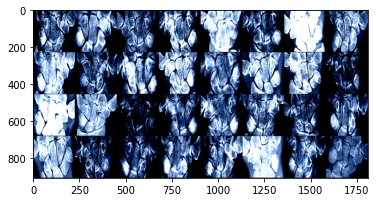

In [11]:
for i in range(2):
    # Get a batch of training data
    inputs, l, c, r, a= next(iter(test_loader))
    # Make a grid from batch
    out = torchvision.utils.make_grid(inputs)
    plt.imshow(out.permute(1, 2, 0))

In [14]:
from sklearn.metrics import matthews_corrcoef, r2_score, accuracy_score, balanced_accuracy_score, f1_score, roc_auc_score, confusion_matrix, classification_report, mean_squared_error
import seaborn as sns
import math
from performance_metrics import evaluate_test_set_multi_wrist, evaluate_test_set_multi_task, roc_auc_score_multiclass, multi_acc, accuracy, multi_mcc, root_mean_squared_error, save_confusion_matrix, draw_roc_curve, evaluate_test_set, calculate_roc_plot
from sklearn.metrics import roc_curve, auc

def calculate_roc_plot_test(y_score, y_test, n_classes):
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    y_test_pred = [[]] * len(y_test)
    for i, t in enumerate(y_test):
        arr = [0] * (n_classes+1)
        arr[t] = 1
        y_test_pred[i] = arr
    y_test_pred = np.array(y_test_pred)
        
    for i in range(n_classes):
        print(y_test_pred, y_score)
        fpr[i], tpr[i], _ = roc_curve(y_test_pred[i, :], y_score[i, :])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Plot of a ROC curve for a specific class
    for i in range(n_classes):
        plt.figure()
        plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic example')
        plt.legend(loc="lower right")
        plt.show()

def save_best_dict(test_metrics, best_dict):
    acc, f1, roc, e = test_metrics

    if(best_dict["accuracy"] > acc):
        best_dict["accuracy"] = acc
    elif(best_dict["f1_score"] > f1):
        best_dict["f1_score"] = f1
        best_dict["roc_auc"] = roc
    
    return best_dict

def draw_roc_multiclass(X,y,model, classes=class_names):
    visualizer = ROCAUC(model, classes=classes)

    visualizer.fit(X, y)        # Fit the training data to the visualizer
    visualizer.score(X, X)        # Evaluate the model on the test data
    visualizer.show()                       # Finalize and render the figure
    plt.savefig()

device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")
print(device)


cuda:3


In [15]:
from models import CNN_MC, MTL_ViTModule, MTL_ViTModule_Wrist
## Is it Regression analysis or multi-class classification?
IsRegression = False
# Epochs and LR Scheduler gamma
EPOCHS = 200
gamma = 0.6

# Learning rate to begin with. Num of classes for multi-class classification
LEARNING_RATE = 0.00001
NUM_CLASSES = 1

model = MTL_ViTModule_Wrist(input_size = IMAGE_SIZE, output_size = NUM_CLASSES)
model.to(device)

## Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# Fine-tune first four params
for param in reversed(list(model.parameters())[-10:]):
    param.requires_grad = True

# for param in reversed(list(model.parameters())):
#     if(param.requires_grad == True):
#         print(param)
# weight=class_weights.to(device)
# criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
criterion = nn.MSELoss()
if(IsRegression == True):
    criterion = nn.MSELoss()

# model = Ditill_ViT(input_size=(224, 224), output_size = NUM_CLASSES)
# distill_criterion = model.get_distiller

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

ModuleNotFoundError: No module named 'torchvision.models.vision_transformer'

In [27]:
import gc
gc.collect()
torch.cuda.empty_cache() # Clear CUDA memory

In [28]:
import json 

# Define model name for filenames
MODEL_NAME_BASE = "ViT_MultiTask_Wrist"
if(IsRegression == True):
    MODEL_NAME_BASE = "ViT_MSE_"

MODEL_NAME = MODEL_NAME_BASE + "_E"

train_metrics = []
val_metrics = []
test_metrics = []

def save_metrics(acc_stats, f1_stats, rmse_stats, roc_stats, prefix="final"):
    cols = []
    stat_dict = {}
    for t in ["train", "val", "test"]:
        for m in ["accuracy", "f1", "rmse", "auc_roc"]:
            stats = None
            if(m == "accuracy"):
                stats = acc_stats
            elif(m == "f1"):
                stats = f1_stats
            elif(m == "rmse"):
                stats = rmse_stats
            elif(m == "auc_roc"):
                stats = roc_stats

            key = f"{t}_{m}"
            stat_dict[key] = stats[t]

    df = pd.DataFrame(stat_dict)
    df.to_csv(f"./logs/{MODEL_NAME}_{prefix}_results.csv")


def save_metrics_multi_score(acc_stats, f1_stats, rmse_stats, roc_stats, prefix="final"):
    cols = []
    stat_dict = {}
    for s in ["E", "J"]:
        for t in ["train", "val", "test"]:
            for m in ["accuracy", "f1", "rmse", "auc_roc"]:
                stats = None
                if(m == "accuracy"):
                    stats = acc_stats
                elif(m == "f1"):
                    stats = f1_stats
                elif(m == "rmse"):
                    stats = rmse_stats
                elif(m == "auc_roc"):
                    stats = roc_stats

                key = f"{t}_{m}_{s}"
                stat_dict[key] = stats[s][t]
            

    df = pd.DataFrame(stat_dict)
    df.to_csv(f"./logs/{MODEL_NAME}_{prefix}_results.csv")

In [29]:
def get_performance_metrics(y_batch, y_hat, weights=None, isRegression=True):
    '''
    Calculate Performance Metrics
        y_batch = The truth values
        y_hat = The predicitons from the model
    '''
    y_batch = y_batch.cpu().numpy()
    y_hat = y_hat.cpu().numpy()
    

    # Weights of samples
    # class_keys = [i for i in Counter(np.squeeze(y_batch)).keys()]
    # class_count = [i for i in Counter(np.squeeze(y_batch)).values()]
    # class_weights = 1./torch.tensor(class_count, dtype=torch.float) 
    # print(class_keys, class_weights, np.squeeze(y_batch))
    
    # Define class weights for samples
    acc = accuracy_score(y_batch, y_hat)
    
    # Sample weights for balanced accuracy
    if(weights != None):
        class_weights_all = weights[np.squeeze(y_batch)]
        acc = balanced_accuracy_score(y_batch, y_hat, sample_weight=class_weights_all)

    r2 = r2_score(y_batch, y_hat)
    f1 = f1_score(y_batch, y_hat, average="macro", labels=np.unique(y_hat))
    rmse = root_mean_squared_error(y_batch, y_hat)
    roc_auc = 0
    try:
        roc_auc = roc_auc_score(y_batch, y_hat,average='weighted')
    except:
        roc_auc = 0
        

    return {'accuracy':acc, 'r2':r2, 'f1':f1, 'rmse':rmse, 'roc_auc':roc_auc}

In [30]:
import warnings
warnings.filterwarnings('ignore')

In [31]:
class MetricsLogKeeper():
    def __init__(self, metric_names, cat_keys, split_keys):
        '''
        A Helper class to keep log of metrics and their values. Generating dictionaries for each metric and splits.

            metric_names : Loss metric names to keep track.
            cat_keys : the keys of the types of categories if multi-task.
            split_keys : the different splits to keep track of (e.g train, test, validation).
        '''
        
        self.metric_names = metric_names
        self.cat_keys = cat_keys
        self.split_keys = split_keys


        self.log_dict = self.__generate_dictionaries()  # Initiate dictionaries
        self.epoch_dict = self.__generate_dictionaries(is_epoch_dict = True) # Initiate Epoch dictionaries

    def __generate_dictionaries(self, is_epoch_dict = False):
        out = {}
        if(self.split_keys and self.cat_keys and self.metric_names):
            for metric in self.metric_names:
                for cat in self.cat_keys:
                    for split in self.split_keys:
                        if(metric not in out.keys()):
                            out[metric] = {}

                        if(cat not in out[metric].keys()):
                            out[metric][cat] = {}
                        
                        if(is_epoch_dict == True):
                            out[metric][cat][split] = 0
                        else:
                            out[metric][cat][split] = []
        
        return out
    

    def update_epoch_values(self, length_dict):
        for metric in self.metric_names:
            for cat in self.cat_keys:
                for split in self.split_keys:
                    if(split == 'test'):
                        self.log_dict[metric][cat][split].append(self.epoch_dict[metric][cat][split])
                    else:
                        self.log_dict[metric][cat][split].append(self.epoch_dict[metric][cat][split] / length_dict[split])
                        print(f"{split} {cat} {metric}", self.log_dict[metric][cat][split][-1])
        self.epoch_dict = self.__generate_dictionaries(is_epoch_dict = True) # Re-Initiate Epoch dictionaries

    def save_log_dict(self, prefix="Wrist_erosion"):

        stat_dict = {}
        for split in self.split_keys:
            for metric in self.metric_names:
                for cat in self.cat_keys:
                    key = f"{split}_{metric}_{cat}"
                    stat_dict[key] = self.log_dict[metric][cat][split]

        df = pd.DataFrame(stat_dict)
        df.to_csv(f"./logs/{MODEL_NAME}_{prefix}_results.csv")



In [32]:
METRIC_NAMES = ['accuracy', 'loss', 'rmse', 'f1', 'r2','roc_auc']
CAT_KEYS = ['lun', 'mc1', 'mul', 'nav']
SPLIT_KEYS = ['train', 'val', 'test']

logger = MetricsLogKeeper(metric_names=METRIC_NAMES, cat_keys=CAT_KEYS, split_keys=SPLIT_KEYS)
logger.epoch_dict

{'accuracy': {'lun': {'train': 0, 'val': 0, 'test': 0},
  'mc1': {'train': 0, 'val': 0, 'test': 0},
  'mul': {'train': 0, 'val': 0, 'test': 0},
  'nav': {'train': 0, 'val': 0, 'test': 0}},
 'loss': {'lun': {'train': 0, 'val': 0, 'test': 0},
  'mc1': {'train': 0, 'val': 0, 'test': 0},
  'mul': {'train': 0, 'val': 0, 'test': 0},
  'nav': {'train': 0, 'val': 0, 'test': 0}},
 'rmse': {'lun': {'train': 0, 'val': 0, 'test': 0},
  'mc1': {'train': 0, 'val': 0, 'test': 0},
  'mul': {'train': 0, 'val': 0, 'test': 0},
  'nav': {'train': 0, 'val': 0, 'test': 0}},
 'f1': {'lun': {'train': 0, 'val': 0, 'test': 0},
  'mc1': {'train': 0, 'val': 0, 'test': 0},
  'mul': {'train': 0, 'val': 0, 'test': 0},
  'nav': {'train': 0, 'val': 0, 'test': 0}},
 'r2': {'lun': {'train': 0, 'val': 0, 'test': 0},
  'mc1': {'train': 0, 'val': 0, 'test': 0},
  'mul': {'train': 0, 'val': 0, 'test': 0},
  'nav': {'train': 0, 'val': 0, 'test': 0}},
 'roc_auc': {'lun': {'train': 0, 'val': 0, 'test': 0},
  'mc1': {'train': 0

In [33]:
import tqdm
import pprint 
from time import time
pp = pprint.PrettyPrinter() # Pretty print

# Prepare the diagram for CNN architecture and vision transformer
best_test_f1 = 0
best_test_dict = {
    "epoch":-1,
    "f1_score":-1,
    "accuracy":-1,
    "roc_auc":-1
}

if __name__ == '__main__':    

   
    print("Begin training.")
    for e in tqdm.tqdm(range(1, EPOCHS+1)):
 
        batch_y_true = []
        batch_y_hat = []

        val_y_true = []
        val_y_hat = []

        model.train()

        for X_train_batch, y_train_batch_lun, y_train_batch_mc1, y_train_batch_mul, y_train_batch_nav in train_loader:
            # Transfer to GPU device
            X_train_batch, y_train_batch_lun, y_train_batch_mc1, y_train_batch_mul, y_train_batch_nav = X_train_batch.to(device), y_train_batch_lun.to(device), y_train_batch_mc1.to(device), y_train_batch_mul.to(device), y_train_batch_nav.to(device)
            # Generate Predicitons
            preds = model(X_train_batch)
            (y_train_pred_lun, y_train_pred_mc1, y_train_pred_mul, y_train_pred_nav) = preds
            y_train_pred_lun, y_train_pred_mc1, y_train_pred_mul, y_train_pred_nav = y_train_pred_lun.float(), y_train_pred_mc1.float(), y_train_pred_mul.float(), y_train_pred_nav.float()
            # Detach predictions for loss calculation
            y_train_hat_lun, y_train_hat_mc1, y_train_hat_mul, y_train_hat_nav = torch.round(y_train_pred_lun).detach(), torch.round(y_train_pred_mc1).detach(), torch.round(y_train_pred_mul).detach(), torch.round(y_train_pred_nav).detach()
            y_train_hat_lun, y_train_hat_mc1, y_train_hat_mul, y_train_hat_nav = y_train_hat_lun.squeeze(0).float(), y_train_hat_mc1.squeeze(0).float(), y_train_hat_mul.squeeze(0).float(), y_train_hat_nav.squeeze(0).float()
            
    
            train_loss_lun = criterion(y_train_pred_lun.to(torch.float32), y_train_batch_lun.to(torch.float32))
            train_loss_mc1 = criterion(y_train_pred_mc1.to(torch.float32), y_train_batch_mc1.to(torch.float32))
            train_loss_mul = criterion(y_train_pred_mul.to(torch.float32), y_train_batch_mul.to(torch.float32))
            train_loss_nav = criterion(y_train_pred_nav.to(torch.float32), y_train_batch_nav.to(torch.float32))

            #distill_loss = distill_criterion(X_train_batch, y_train_batch)
            train_metrics = {}
            train_metrics['lun'] = get_performance_metrics(y_train_batch_lun, y_train_hat_lun, weights=None)
            train_metrics['mc1'] = get_performance_metrics(y_train_batch_mc1, y_train_hat_mc1, weights=None)
            train_metrics['mul'] = get_performance_metrics(y_train_batch_mul, y_train_hat_mul, weights=None)
            train_metrics['nav'] = get_performance_metrics(y_train_batch_nav, y_train_hat_nav, weights=None)

            for key in METRIC_NAMES:
                for cat in CAT_KEYS:
                    if('loss' not in key):
                        logger.epoch_dict[key][cat]['train'] += train_metrics[cat][key]
            

                
            #train_acc, train_r2, train_f1, train_rmse, train_roc = train_metrics_lun['accuracy'], train_metrics_e['r2'], train_metrics_e['f1'], train_metrics_e['rmse'], train_metrics_e['roc_auc'] 
          
            # train_acc = accuracy_score(y_train_batch.cpu().numpy(), y_train_hat.cpu().numpy())
            # train_mcc = multi_mcc(y_train_batch.cpu().numpy(), y_train_hat.cpu().numpy())
            # train_f1 = f1_score(y_train_batch.cpu().numpy(), y_train_hat.cpu().numpy(), average="macro", labels=np.unique(y_train_hat.cpu().numpy()))
            # train_rmse = root_mean_squared_error(y_train_batch.cpu().numpy(), y_train_hat.cpu().numpy())


            final_loss = train_loss_lun + train_loss_mc1 + train_loss_mul + train_loss_nav

            optimizer.zero_grad()
            final_loss.backward()
            #distill_loss.backward()
            optimizer.step()
            
            logger.epoch_dict["loss"]['lun']['train'] += final_loss.item()

            
            # # For Erosion
            # train_epoch_acc["E"] += train_acc
            # train_epoch_r2["E"] += train_r2
            # train_epoch_f1["E"] += train_f1
            # train_epoch_rmse["E"] += train_rmse
            # train_epoch_roc["E"] += train_roc

            # # For JSN
            # train_epoch_acc["J"] += train_acc_j
            # train_epoch_r2["J"] += train_r2_j
            # train_epoch_f1["J"] += train_f1_j
            # train_epoch_rmse["J"] += train_rmse_j
            # train_epoch_roc["J"] += train_roc_j
            
            # if(e % 10 == 0):
            #     # Draw ROC Curve for Train
            #     # draw_roc_curve(X_train_batch.cpu().detach().numpy(), y_train_batch.cpu().detach().numpy(), y_train_pred.cpu().detach().numpy(), model.classes, f"{MODEL_NAME}_{e}_roc")
            torch.cuda.empty_cache() # Clear CUDA memory
            
            
        # VALIDATION    
        with torch.no_grad():
        

            model.eval()
            for X_val_batch, y_val_batch_lun, y_val_batch_mc1, y_val_batch_mul, y_val_batch_nav in val_loader:

                X_val_batch,  y_val_batch_lun, y_val_batch_mc1, y_val_batch_mul, y_val_batch_nav = X_val_batch.to(device), y_val_batch_lun.to(device), y_val_batch_mc1.to(device), y_val_batch_mul.to(device), y_val_batch_nav.to(device)

                val_preds = model(X_val_batch)
                (y_val_pred_lun, y_val_pred_mc1, y_val_pred_mul, y_val_pred_nav) = val_preds
                y_val_pred_lun, y_val_pred_mc1, y_val_pred_mul, y_val_pred_nav = y_val_pred_lun.float(), y_val_pred_mc1.float(), y_val_pred_mul.float(), y_val_pred_nav.float()
                # Detach predictions for loss calculation
                y_val_hat_lun, y_val_hat_mc1, y_val_hat_mul, y_val_hat_nav = torch.round(y_val_pred_lun).detach(), torch.round(y_val_pred_mc1).detach(), torch.round(y_val_pred_mul).detach(), torch.round(y_val_pred_nav).detach()
                y_val_hat_lun, y_val_hat_mc1, y_val_hat_mul, y_val_hat_nav = y_val_hat_lun.squeeze(0).float(), y_val_hat_mc1.squeeze(0).float(), y_val_hat_mul.squeeze(0).float(), y_val_hat_nav.squeeze(0).float()
                
            
                val_loss_lun = criterion(y_val_pred_lun.to(torch.float32), y_val_batch_lun.to(torch.float32))
                val_loss_mc1 = criterion(y_val_pred_mc1.to(torch.float32), y_val_batch_mc1.to(torch.float32))
                val_loss_mul = criterion(y_val_pred_mul.to(torch.float32), y_val_batch_mul.to(torch.float32))
                val_loss_nav = criterion(y_val_pred_nav.to(torch.float32), y_val_batch_nav.to(torch.float32))

                #distill_loss = distill_criterion(X_train_batch, y_train_batch)
                val_metrics = {}
                val_metrics['lun'] = get_performance_metrics(y_val_batch_lun, y_val_hat_lun, weights=None)
                val_metrics['mc1'] = get_performance_metrics(y_val_batch_mc1, y_val_hat_mc1, weights=None)
                val_metrics['mul'] = get_performance_metrics(y_val_batch_mul, y_val_hat_mul, weights=None)
                val_metrics['nav'] = get_performance_metrics(y_val_batch_nav, y_val_hat_nav, weights=None)

          
                for key in METRIC_NAMES:
                    for cat in CAT_KEYS:
                        if('loss' not in key):
                            logger.epoch_dict[key][cat]['val'] += train_metrics[cat][key]

                    val_loss = val_loss_lun + val_loss_mc1 + val_loss_mul + val_loss_nav

                
                    
                logger.epoch_dict["loss"]['lun']['val'] += final_loss.item()

                # # For Erosion
                # val_epoch_acc["E"] += val_acc
                # val_epoch_r2["E"] += val_r2
                # val_epoch_f1["E"] += val_f1
                # val_epoch_rmse["E"] += val_rmse
                # val_epoch_roc["E"] += val_roc
                # # For JSN
                # val_epoch_acc["J"] += val_acc_j
                # val_epoch_r2["J"] += val_r2_j
                # val_epoch_f1["J"] += val_f1_j
                # val_epoch_rmse["J"] += val_rmse_j
                # val_epoch_roc["J"] += val_roc_j
                torch.cuda.empty_cache() # Clear CUDA memory


        # Evaluate on test and save best result
        test_metrics = evaluate_test_set_multi_wrist(model, test_loader, e,regression = IsRegression, class_weights = None)
        
        for key in METRIC_NAMES:
                for cat in CAT_KEYS:
                    if('loss' not in key):
                        logger.epoch_dict[key][cat]['test'] += test_metrics[key][cat]
        
        # Update logger epoch values 
        logger.update_epoch_values({'train':len(train_dl), 'val':len(val_dl), 'test': len(test_dl) })
        
        # Save confusion matrix, test metrics, every 5 minutes 
        if(e % 5 == 0):
            ## save_metrics_multi_score(accuracy_stats,f1_stats,rmse_stats,roc_stats=roc_auc_stats, prefix=e)
            # save_confusion_matrix(val_y_true, val_y_hat, e)
            test_eval = evaluate_test_set_multi_wrist(model, test_loader, e ,regression = IsRegression, class_weights = None)
            logger.save_log_dict(prefix=f"erosion_{e}")
            print("Best Test metrics till now: ")

            pp.pprint(best_test_dict)
        
        
# save_metrics_multi_score(accuracy_stats,f1_stats,rmse_stats,roc_auc _stats)

Begin training.


  0%|          | 1/200 [00:26<1:26:36, 26.11s/it]

Test Metrics | {'accuracy': {'lun': 0.6239436619718309, 'mc1': 0.49295774647887325, 'mul': 0.49859154929577465, 'nav': 0.5140845070422535}, 'loss': {'lun': [], 'mc1': [], 'mul': [], 'nav': []}, 'rmse': {'lun': 0.8307471597251588, 'mc1': 0.8873127699527329, 'mul': 0.858265524719618, 'nav': 0.9843851421984181}, 'f1': {'lun': 0.7567209974550185, 'mc1': 0.6288278410328474, 'mul': 0.6406561166264397, 'nav': 0.6575671405328681}, 'r2': {'lun': -3.615037394864487, 'mc1': -2.3300612042000144, 'mul': -3.626300512850511, 'nav': -2.8763332571221123}, 'roc_auc': {'lun': -1, 'mc1': -1, 'mul': -1, 'nav': -1}}
train lun accuracy 0.329229797979798
val lun accuracy 0.4166666666666667
train mc1 accuracy 0.33207070707070707
val mc1 accuracy 0.4166666666666667
train mul accuracy 0.3162878787878788
val mul accuracy 0.25
train nav accuracy 0.33933080808080807
val nav accuracy 0.3333333333333332
train lun loss 5.728285536621556
val lun loss 5.122615337371826
train mc1 loss 0.0
val mc1 loss 0.0
train mul loss 

  1%|          | 2/200 [00:52<1:25:54, 26.03s/it]

train lun accuracy 0.3429608585858586
val lun accuracy 0.4166666666666667
train mc1 accuracy 0.3355429292929293
val mc1 accuracy 0.20833333333333334
train mul accuracy 0.3368055555555556
val mul accuracy 0.4166666666666667
train nav accuracy 0.3420138888888889
val nav accuracy 0.1666666666666666
train lun loss 5.607455932732784
val lun loss 6.522083282470703
train mc1 loss 0.0
val mc1 loss 0.0
train mul loss 0.0
val mul loss 0.0
train nav loss 0.0
val nav loss 0.0
train lun rmse 1.219070622967813
val lun rmse 1.2747548783981957
train mc1 rmse 1.214064327380678
val mc1 rmse 1.338531518840792
train mul rmse 1.1995595734528302
val mul rmse 1.2076147453015655
train nav rmse 1.2054787088511902
val nav rmse 1.5138252032977673
train lun f1 0.09298835645951607
val lun f1 0.09803921568627455
train mc1 f1 0.0946993679419461
val mc1 f1 0.07142857142857141
train mul f1 0.09468858300532092
val mul f1 0.19612903225806458
train nav f1 0.09911117745905494
val nav f1 0.059259259259259275
train lun r2 -

  2%|▏         | 3/200 [01:18<1:25:39, 26.09s/it]

train lun accuracy 0.33207070707070707
val lun accuracy 0.4166666666666667
train mc1 accuracy 0.34816919191919193
val mc1 accuracy 0.2916666666666668
train mul accuracy 0.33791035353535354
val mul accuracy 0.3333333333333332
train nav accuracy 0.34832702020202017
val nav accuracy 0.3333333333333332
train lun loss 5.389106121930209
val lun loss 5.097973346710205
train mc1 loss 0.0
val mc1 loss 0.0
train mul loss 0.0
val mul loss 0.0
train nav loss 0.0
val nav loss 0.0
train lun rmse 1.178815213555159
val lun rmse 1.2583057550014478
train mc1 rmse 1.1593250592002322
val mc1 rmse 1.3228756555322958
train mul rmse 1.2194364386301817
val mul rmse 1.2416386861443376
train nav rmse 1.1568762434963928
val nav rmse 1.1180339887498945
train lun f1 0.09316988818842126
val lun f1 0.09803921568627455
train mc1 f1 0.10093803255303274
val mc1 f1 0.07777777777777774
train mul f1 0.09232987721739533
val mul f1 0.10666666666666665
train nav f1 0.10745060003400113
val nav f1 0.1032258064516129
train lun 

  2%|▏         | 4/200 [01:44<1:25:43, 26.24s/it]

train lun accuracy 0.3435921717171717
val lun accuracy 0.45833333333333337
train mc1 accuracy 0.3565340909090909
val mc1 accuracy 0.25
train mul accuracy 0.3390151515151515
val mul accuracy 0.375
train nav accuracy 0.344854797979798
val nav accuracy 0.2916666666666668
train lun loss 5.383415435299729
val lun loss 5.672582149505615
train mc1 loss 0.0
val mc1 loss 0.0
train mul loss 0.0
val mul loss 0.0
train nav loss 0.0
val nav loss 0.0
train lun rmse 1.19624768587659
val lun rmse 1.0801234313402508
train mc1 rmse 1.165989974360951
val mc1 rmse 1.2583057550014478
train mul rmse 1.2093074467460658
val mul rmse 1.443375645443858
train nav rmse 1.1545864798065957
val nav rmse 1.3693063937629153
train lun f1 0.09392393688686618
val lun f1 0.15714285714285706
train mc1 f1 0.10099647006839803
val mc1 f1 0.06666666666666667
train mul f1 0.09515542806982637
val mul f1 0.09375000000000001
train nav f1 0.10242127166567494
val nav f1 0.07777777777777774
train lun r2 -4.438659287926151
val lun r2 

  2%|▎         | 5/200 [02:16<1:31:49, 28.25s/it]

Best Test metrics till now: 
{'accuracy': -1, 'epoch': -1, 'f1_score': -1, 'roc_auc': -1}


  3%|▎         | 6/200 [02:43<1:29:54, 27.81s/it]

train lun accuracy 0.32417929292929293
val lun accuracy 0.20833333333333334
train mc1 accuracy 0.3475378787878788
val mc1 accuracy 0.375
train mul accuracy 0.3429608585858586
val mul accuracy 0.2916666666666668
train nav accuracy 0.3524305555555556
val nav accuracy 0.1666666666666666
train lun loss 5.223550532803391
val lun loss 5.974589824676514
train mc1 loss 0.0
val mc1 loss 0.0
train mul loss 0.0
val mul loss 0.0
train nav loss 0.0
val nav loss 0.0
train lun rmse 1.2032054215021502
val lun rmse 1.3228756555322958
train mc1 rmse 1.1528473243346544
val mc1 rmse 1.3070322769808564
train mul rmse 1.1703862724873557
val mul rmse 1.2747548783981957
train nav rmse 1.1384087327888948
val nav rmse 1.1547005555856307
train lun f1 0.08752389596177194
val lun f1 0.05747126436781611
train mc1 f1 0.10340131324535862
val mc1 f1 0.14157706093189967
train mul f1 0.10014503374133199
val mul f1 0.09333333333333331
train nav f1 0.10355453264371693
val nav f1 0.059259259259259275
train lun r2 -4.776805

  4%|▎         | 7/200 [03:10<1:28:14, 27.43s/it]

train lun accuracy 0.3226010101010101
val lun accuracy 0.2916666666666668
train mc1 accuracy 0.34722222222222227
val mc1 accuracy 0.2916666666666668
train mul accuracy 0.3385416666666667
val mul accuracy 0.25
train nav accuracy 0.35400883838383834
val nav accuracy 0.3333333333333332
train lun loss 5.278349995613098
val lun loss 5.6575798988342285
train mc1 loss 0.0
val mc1 loss 0.0
train mul loss 0.0
val mul loss 0.0
train nav loss 0.0
val nav loss 0.0
train lun rmse 1.2142949493064075
val lun rmse 1.3228756555322958
train mc1 rmse 1.1481441803923391
val mc1 rmse 1.443375645443858
train mul rmse 1.1899119703420016
val mul rmse 1.2909944333459515
train nav rmse 1.1357030672368373
val nav rmse 1.1902380547311682
train lun f1 0.08737566478326896
val lun f1 0.06451612903225802
train mc1 f1 0.10244541327529132
val mc1 f1 0.07777777777777774
train mul f1 0.09592004100714713
val mul f1 0.08571428571428567
train nav f1 0.10802010606452411
val nav f1 0.1032258064516129
train lun r2 -5.335273784

  4%|▍         | 8/200 [03:36<1:26:55, 27.16s/it]

train lun accuracy 0.3503787878787879
val lun accuracy 0.25
train mc1 accuracy 0.3584280303030303
val mc1 accuracy 0.375
train mul accuracy 0.3584280303030303
val mul accuracy 0.5
train nav accuracy 0.3314393939393939
val nav accuracy 0.375
train lun loss 5.204373468052257
val lun loss 6.474675178527832
train mc1 loss 0.0
val mc1 loss 0.0
train mul loss 0.0
val mul loss 0.0
train nav loss 0.0
val nav loss 0.0
train lun rmse 1.1679246501326979
val lun rmse 1.2909944333459515
train mc1 rmse 1.1474044340848977
val mc1 rmse 1.3994046495098411
train mul rmse 1.1766267663271124
val mul rmse 1.2416386861443376
train nav rmse 1.1703141107505861
val nav rmse 1.2747548783981957
train lun f1 0.09417443986708736
val lun f1 0.08000000000000003
train mc1 f1 0.10296316063663193
val mc1 f1 0.08035714285714284
train mul f1 0.1020573750064399
val mul f1 0.14117647058823526
train nav f1 0.09734050593252806
val nav f1 0.11249999999999998
train lun r2 -4.349706403078836
val lun r2 0.0
train mc1 r2 -3.60004

  4%|▍         | 9/200 [04:03<1:26:10, 27.07s/it]

train lun accuracy 0.35400883838383834
val lun accuracy 0.3333333333333332
train mc1 accuracy 0.3595328282828283
val mc1 accuracy 0.4166666666666667
train mul accuracy 0.342645202020202
val mul accuracy 0.3333333333333332
train nav accuracy 0.3546401515151515
val nav accuracy 0.375
train lun loss 5.154745874982892
val lun loss 6.004508972167969
train mc1 loss 0.0
val mc1 loss 0.0
train mul loss 0.0
val mul loss 0.0
train nav loss 0.0
val nav loss 0.0
train lun rmse 1.164247742715109
val lun rmse 1.3228756555322958
train mc1 rmse 1.1586277567348564
val mc1 rmse 1.1365151239337896
train mul rmse 1.1785744247921335
val mul rmse 1.3070322769808564
train nav rmse 1.127835542125015
val nav rmse 1.1547005555856307
train lun f1 0.09426499956988299
val lun f1 0.0833333333333333
train mc1 f1 0.10120641639261159
val mc1 f1 0.09803921568627455
train mul f1 0.10008621140793234
val mul f1 0.08888888888888884
train nav f1 0.10383662466165826
val nav f1 0.09375
train lun r2 -4.736788464061191
val lun 

  5%|▌         | 10/200 [04:35<1:29:57, 28.41s/it]

Best Test metrics till now: 
{'accuracy': -1, 'epoch': -1, 'f1_score': -1, 'roc_auc': -1}


  6%|▌         | 11/200 [05:01<1:27:37, 27.82s/it]

train lun accuracy 0.3536931818181818
val lun accuracy 0.375
train mc1 accuracy 0.35984848484848486
val mc1 accuracy 0.375
train mul accuracy 0.3333333333333333
val mul accuracy 0.125
train nav accuracy 0.37042297979797983
val nav accuracy 0.2916666666666668
train lun loss 5.106535832087199
val lun loss 7.056629657745361
train mc1 loss 0.0
val mc1 loss 0.0
train mul loss 0.0
val mul loss 0.0
train nav loss 0.0
val nav loss 0.0
train lun rmse 1.1566412408975228
val lun rmse 1.1180339887498945
train mc1 rmse 1.1284133827615699
val mc1 rmse 1.3070322769808564
train mul rmse 1.1841526308337362
val mul rmse 1.3540064154463096
train nav rmse 1.1375601524105206
val nav rmse 1.338531518840792
train lun f1 0.09714059386455658
val lun f1 0.10909090909090909
train mc1 f1 0.10533075735973159
val mc1 f1 0.11249999999999998
train mul f1 0.09276147439902989
val mul f1 0.03846153846153844
train nav f1 0.11025357940790713
val nav f1 0.07777777777777774
train lun r2 -4.397352142806689
val lun r2 0.0
tra

  6%|▌         | 12/200 [05:28<1:26:24, 27.58s/it]

train lun accuracy 0.3420138888888889
val lun accuracy 0.2916666666666668
train mc1 accuracy 0.35495580808080807
val mc1 accuracy 0.5833333333333336
train mul accuracy 0.3500631313131313
val mul accuracy 0.1666666666666666
train nav accuracy 0.37105429292929293
val nav accuracy 0.3333333333333332
train lun loss 5.101593172911442
val lun loss 4.933802604675293
train mc1 loss 0.0
val mc1 loss 0.0
train mul loss 0.0
val mul loss 0.0
train nav loss 0.0
val nav loss 0.0
train lun rmse 1.1813983002404116
val lun rmse 1.2909944333459515
train mc1 rmse 1.1623605835060524
val mc1 rmse 0.9574271181321746
train mul rmse 1.1763095726875799
val mul rmse 1.4142135623730956
train nav rmse 1.1171242607634346
val nav rmse 1.0206207066928623
train lun f1 0.0926678241160128
val lun f1 0.07526881720430105
train mc1 f1 0.09877332969997751
val mc1 f1 0.15135135135135142
train mul f1 0.10052810820024353
val mul f1 0.12333333333333336
train nav f1 0.11346655567044395
val nav f1 0.13333333333333333
train lun r

  6%|▋         | 13/200 [05:54<1:24:54, 27.24s/it]

train lun accuracy 0.3409090909090909
val lun accuracy 0.25
train mc1 accuracy 0.358270202020202
val mc1 accuracy 0.45833333333333337
train mul accuracy 0.36537247474747475
val mul accuracy 0.3333333333333332
train nav accuracy 0.354324494949495
val nav accuracy 0.4166666666666667
train lun loss 5.126025618928852
val lun loss 4.733150482177734
train mc1 loss 0.0
val mc1 loss 0.0
train mul loss 0.0
val mul loss 0.0
train nav loss 0.0
val nav loss 0.0
train lun rmse 1.1746199386020684
val lun rmse 1.3070322769808564
train mc1 rmse 1.1113758207882667
val mc1 rmse 0.9574271181321746
train mul rmse 1.16464652952869
val mul rmse 1.2747548783981957
train nav rmse 1.151020436221398
val nav rmse 0.8416253997266948
train lun f1 0.09330997268667084
val lun f1 0.06666666666666667
train mc1 f1 0.10803950073690956
val mc1 f1 0.1783549783549784
train mul f1 0.10735175969827365
val mul f1 0.10666666666666665
train nav f1 0.10529477335847559
val nav f1 0.19062499999999993
train lun r2 -4.00010631271628

  7%|▋         | 14/200 [06:22<1:24:14, 27.18s/it]

train lun accuracy 0.33933080808080807
val lun accuracy 0.20833333333333334
train mc1 accuracy 0.37941919191919193
val mc1 accuracy 0.2916666666666668
train mul accuracy 0.3435921717171717
val mul accuracy 0.3333333333333332
train nav accuracy 0.35527146464646464
val nav accuracy 0.4166666666666667
train lun loss 4.939511541164283
val lun loss 5.507808208465576
train mc1 loss 0.0
val mc1 loss 0.0
train mul loss 0.0
val mul loss 0.0
train nav loss 0.0
val nav loss 0.0
train lun rmse 1.1709940576908655
val lun rmse 1.2416386861443376
train mc1 rmse 1.1219627335089803
val mc1 rmse 1.1902380547311682
train mul rmse 1.158443290183705
val mul rmse 1.2909944333459515
train nav rmse 1.1004124035582243
val nav rmse 1.2247448713915892
train lun f1 0.09075774641425431
val lun f1 0.0689655172413793
train mc1 f1 0.11017504714227452
val mc1 f1 0.09333333333333331
train mul f1 0.09820560747088292
val mul f1 0.08602150537634402
train nav f1 0.1067775081460548
val nav f1 0.08403361344537812
train lun r

  8%|▊         | 15/200 [06:53<1:27:31, 28.39s/it]

Best Test metrics till now: 
{'accuracy': -1, 'epoch': -1, 'f1_score': -1, 'roc_auc': -1}


  8%|▊         | 16/200 [07:20<1:25:43, 27.96s/it]

train lun accuracy 0.3301767676767677
val lun accuracy 0.2916666666666668
train mc1 accuracy 0.3879419191919192
val mc1 accuracy 0.4166666666666667
train mul accuracy 0.3500631313131313
val mul accuracy 0.1666666666666666
train nav accuracy 0.3428030303030303
val nav accuracy 0.5
train lun loss 5.044076157338692
val lun loss 5.030920028686523
train mc1 loss 0.0
val mc1 loss 0.0
train mul loss 0.0
val mul loss 0.0
train nav loss 0.0
val nav loss 0.0
train lun rmse 1.1891220187107787
val lun rmse 1.2909944333459515
train mc1 rmse 1.101711222237767
val mc1 rmse 1.0408330188218289
train mul rmse 1.1554495098693096
val mul rmse 1.338531518840792
train nav rmse 1.1203944944381419
val nav rmse 0.8660254037844386
train lun f1 0.0904501520861143
val lun f1 0.07526881720430105
train mc1 f1 0.11253393785654983
val mc1 f1 0.11764705882352942
train mul f1 0.10166775566248737
val mul f1 0.05925925925925927
train nav f1 0.10149325904369276
val nav f1 0.13714285714285704
train lun r2 -4.98986376933591

  8%|▊         | 17/200 [07:47<1:24:14, 27.62s/it]

train lun accuracy 0.3374368686868687
val lun accuracy 0.45833333333333337
train mc1 accuracy 0.37642045454545453
val mc1 accuracy 0.375
train mul accuracy 0.3716856060606061
val mul accuracy 0.25
train nav accuracy 0.36000631313131315
val nav accuracy 0.4166666666666667
train lun loss 4.874541051460035
val lun loss 5.6671833992004395
train mc1 loss 0.0
val mc1 loss 0.0
train mul loss 0.0
val mul loss 0.0
train nav loss 0.0
val nav loss 0.0
train lun rmse 1.1897400419340023
val lun rmse 1.1547005555856307
train mc1 rmse 1.0932515955230382
val mc1 rmse 1.1726039399558568
train mul rmse 1.1435062097597128
val mul rmse 1.4860461816042163
train nav rmse 1.1067601287634563
val nav rmse 1.1902380547311682
train lun f1 0.08994850469454327
val lun f1 0.10476190476190479
train mc1 f1 0.11195253037501418
val mc1 f1 0.11249999999999998
train mul f1 0.1091706574355248
val mul f1 0.0689655172413793
train nav f1 0.11067411474394206
val nav f1 0.10101010101010104
train lun r2 -4.576682554981675
val l

  9%|▉         | 18/200 [08:13<1:22:47, 27.30s/it]

train lun accuracy 0.3445391414141414
val lun accuracy 0.45833333333333337
train mc1 accuracy 0.39015151515151514
val mc1 accuracy 0.625
train mul accuracy 0.36063762626262624
val mul accuracy 0.0833333333333333
train nav accuracy 0.3612689393939394
val nav accuracy 0.375
train lun loss 4.79373756683234
val lun loss 5.230649948120117
train mc1 loss 0.0
val mc1 loss 0.0
train mul loss 0.0
val mul loss 0.0
train nav loss 0.0
val nav loss 0.0
train lun rmse 1.142723287295923
val lun rmse 1.384437296135233
train mc1 rmse 1.0749029561909496
val mc1 rmse 0.7071067811865478
train mul rmse 1.1214011811213855
val mul rmse 1.4142135623730956
train nav rmse 1.1162720184756223
val nav rmse 1.2076147453015655
train lun f1 0.09603731974970185
val lun f1 0.10476190476190479
train mc1 f1 0.1106089699638386
val mc1 f1 0.15789473684210528
train mul f1 0.10388653814182468
val mul f1 0.02564102564102565
train nav f1 0.11068562234491192
val nav f1 0.09375
train lun r2 -4.669293886302684
val lun r2 0.0
trai

 10%|▉         | 19/200 [08:40<1:21:50, 27.13s/it]

train lun accuracy 0.35321969696969696
val lun accuracy 0.375
train mc1 accuracy 0.391729797979798
val mc1 accuracy 0.4166666666666667
train mul accuracy 0.3664772727272727
val mul accuracy 0.25
train nav accuracy 0.3574810606060606
val nav accuracy 0.375
train lun loss 4.758302341807973
val lun loss 6.329743385314941
train mc1 loss 0.0
val mc1 loss 0.0
train mul loss 0.0
val mul loss 0.0
train nav loss 0.0
val nav loss 0.0
train lun rmse 1.1245094878264132
val lun rmse 1.471960171383562
train mc1 rmse 1.1012097145740107
val mc1 rmse 1.0408330188218289
train mul rmse 1.1141118213133108
val mul rmse 1.457737973711325
train nav rmse 1.091042455112417
val nav rmse 1.1726039399558568
train lun f1 0.09836613969872025
val lun f1 0.07792207792207793
train mc1 f1 0.11172121308233157
val mc1 f1 0.11764705882352942
train mul f1 0.10686804705607961
val mul f1 0.06122448979591838
train nav f1 0.1124094230300255
val nav f1 0.10909090909090909
train lun r2 -4.153300397875179
val lun r2 0.0
train mc1

 10%|█         | 20/200 [09:11<1:25:22, 28.46s/it]

Best Test metrics till now: 
{'accuracy': -1, 'epoch': -1, 'f1_score': -1, 'roc_auc': -1}


 10%|█         | 21/200 [09:38<1:23:23, 27.95s/it]

train lun accuracy 0.3630050505050505
val lun accuracy 0.45833333333333337
train mc1 accuracy 0.38083964646464646
val mc1 accuracy 0.2916666666666668
train mul accuracy 0.3734217171717171
val mul accuracy 0.3333333333333332
train nav accuracy 0.36553030303030304
val nav accuracy 0.375
train lun loss 4.578559907999906
val lun loss 4.778104782104492
train mc1 loss 0.0
val mc1 loss 0.0
train mul loss 0.0
val mul loss 0.0
train nav loss 0.0
val nav loss 0.0
train lun rmse 1.1111246253182632
val lun rmse 1.0606601717798216
train mc1 rmse 1.0631746421736072
val mc1 rmse 1.2076147453015655
train mul rmse 1.090238218928709
val mul rmse 1.2416386861443376
train nav rmse 1.0975986879878936
val nav rmse 1.1547005555856307
train lun f1 0.1036877568463892
val lun f1 0.12571428571428575
train mc1 f1 0.1147617141786147
val mc1 f1 0.0903225806451613
train mul f1 0.1102585157177851
val mul f1 0.10322580645161288
train nav f1 0.11240208243336176
val nav f1 0.11249999999999998
train lun r2 -3.69845879112

 11%|█         | 22/200 [10:05<1:21:45, 27.56s/it]

train lun accuracy 0.34958964646464646
val lun accuracy 0.4166666666666667
train mc1 accuracy 0.3802083333333333
val mc1 accuracy 0.5
train mul accuracy 0.3767361111111111
val mul accuracy 0.45833333333333337
train nav accuracy 0.3489583333333333
val nav accuracy 0.375
train lun loss 4.872479706099539
val lun loss 4.053775787353516
train mc1 loss 0.0
val mc1 loss 0.0
train mul loss 0.0
val mul loss 0.0
train nav loss 0.0
val nav loss 0.0
train lun rmse 1.1324837687105882
val lun rmse 1.0801234313402508
train mc1 rmse 1.092983355820786
val mc1 rmse 0.7071067811865478
train mul rmse 1.1476998241756389
val mul rmse 1.2747548783981957
train nav rmse 1.121446653548067
val nav rmse 1.1726039399558568
train lun f1 0.09743063165523481
val lun f1 0.09803921568627455
train mc1 f1 0.11677840747336529
val mc1 f1 0.2897603485838779
train mul f1 0.10576067582641978
val mul f1 0.12941176470588237
train nav f1 0.10996478898268845
val nav f1 0.11249999999999998
train lun r2 -4.217197139777784
val lun r

 12%|█▏        | 23/200 [10:31<1:20:33, 27.31s/it]

train lun accuracy 0.34801136363636365
val lun accuracy 0.25
train mc1 accuracy 0.376104797979798
val mc1 accuracy 0.5416666666666665
train mul accuracy 0.37263257575757575
val mul accuracy 0.25
train nav accuracy 0.3768939393939394
val nav accuracy 0.625
train lun loss 4.631967801036256
val lun loss 3.943953275680542
train mc1 loss 0.0
val mc1 loss 0.0
train mul loss 0.0
val mul loss 0.0
train nav loss 0.0
val nav loss 0.0
train lun rmse 1.1252834323017187
val lun rmse 1.1180339887498945
train mc1 rmse 1.073484506577949
val mc1 rmse 0.7637626028191736
train mul rmse 1.0948718620931315
val mul rmse 1.0
train nav rmse 1.083094690915895
val nav rmse 0.7071067811865478
train lun f1 0.099775931116254
val lun f1 0.08000000000000003
train mc1 f1 0.11497671819059649
val mc1 f1 0.17567567567567555
train mul f1 0.1136261498023259
val mul f1 0.10344827586206896
train nav f1 0.11322822166072034
val nav f1 0.2891891891891892
train lun r2 -4.616243450261045
val lun r2 0.0
train mc1 r2 -2.9269458505

 12%|█▏        | 24/200 [10:58<1:19:41, 27.17s/it]

train lun accuracy 0.3678977272727273
val lun accuracy 0.375
train mc1 accuracy 0.3821022727272727
val mc1 accuracy 0.5
train mul accuracy 0.3701073232323232
val mul accuracy 0.20833333333333334
train nav accuracy 0.37847222222222227
val nav accuracy 0.2916666666666668
train lun loss 4.61124983700839
val lun loss 4.378576278686523
train mc1 loss 0.0
val mc1 loss 0.0
train mul loss 0.0
val mul loss 0.0
train nav loss 0.0
val nav loss 0.0
train lun rmse 1.0904373091772155
val lun rmse 1.0606601717798216
train mc1 rmse 1.075859639453518
val mc1 rmse 1.0606601717798216
train mul rmse 1.1289945838406406
val mul rmse 1.1365151239337896
train nav rmse 1.0749361461631328
val nav rmse 0.9789450002247927
train lun f1 0.10336549149294716
val lun f1 0.10909090909090909
train mc1 f1 0.11703449269711602
val mc1 f1 0.13714285714285704
train mul f1 0.10461543657677069
val mul f1 0.08928571428571423
train nav f1 0.11406816061268082
val nav f1 0.0903225806451613
train lun r2 -4.3736471413890765
val lun 

 12%|█▎        | 25/200 [11:30<1:22:59, 28.45s/it]

Best Test metrics till now: 
{'accuracy': -1, 'epoch': -1, 'f1_score': -1, 'roc_auc': -1}


 13%|█▎        | 26/200 [11:56<1:20:56, 27.91s/it]

train lun accuracy 0.3645833333333333
val lun accuracy 0.375
train mc1 accuracy 0.38115530303030304
val mc1 accuracy 0.375
train mul accuracy 0.34816919191919193
val mul accuracy 0.2916666666666668
train nav accuracy 0.37736742424242425
val nav accuracy 0.25
train lun loss 4.564142563126304
val lun loss 4.624271392822266
train mc1 loss 0.0
val mc1 loss 0.0
train mul loss 0.0
val mul loss 0.0
train nav loss 0.0
val nav loss 0.0
train lun rmse 1.0929310326887538
val lun rmse 1.0408330188218289
train mc1 rmse 1.092332232269626
val mc1 rmse 1.3228756555322958
train mul rmse 1.1140982255434926
val mul rmse 1.2747548783981957
train nav rmse 1.0711114968329276
val nav rmse 1.2076147453015655
train lun f1 0.10474591955821769
val lun f1 0.10909090909090909
train mc1 f1 0.11052110942472639
val mc1 f1 0.11249999999999998
train mul f1 0.10664847499106533
val mul f1 0.12068965517241374
train nav f1 0.11139738126434537
val nav f1 0.09656084656084653
train lun r2 -4.011023906038569
val lun r2 0.0
tra

 14%|█▎        | 27/200 [12:23<1:19:38, 27.62s/it]

train lun accuracy 0.3603219696969697
val lun accuracy 0.5
train mc1 accuracy 0.3877840909090909
val mc1 accuracy 0.375
train mul accuracy 0.36916035353535354
val mul accuracy 0.20833333333333334
train nav accuracy 0.3797348484848485
val nav accuracy 0.125
train lun loss 4.4485555995594375
val lun loss 4.192107677459717
train mc1 loss 0.0
val mc1 loss 0.0
train mul loss 0.0
val mul loss 0.0
train nav loss 0.0
val nav loss 0.0
train lun rmse 1.1119309662457149
val lun rmse 0.8660254037844386
train mc1 rmse 1.052851551374653
val mc1 rmse 1.0408330188218289
train mul rmse 1.086625589230697
val mul rmse 1.3540064154463096
train nav rmse 1.0873813142900737
val nav rmse 1.2247448713915892
train lun f1 0.09950518118544742
val lun f1 0.1666666666666666
train mc1 f1 0.11901660588774375
val mc1 f1 0.140625
train mul f1 0.11551210460432475
val mul f1 0.09259259259259257
train nav f1 0.11461943846111376
val nav f1 0.04444444444444442
train lun r2 -4.699265999559254
val lun r2 0.0
train mc1 r2 -3.1

 14%|█▍        | 28/200 [12:50<1:18:29, 27.38s/it]

train lun accuracy 0.3611111111111111
val lun accuracy 0.20833333333333334
train mc1 accuracy 0.39378156565656564
val mc1 accuracy 0.3333333333333332
train mul accuracy 0.3626893939393939
val mul accuracy 0.375
train nav accuracy 0.37626262626262624
val nav accuracy 0.45833333333333337
train lun loss 4.526349295269359
val lun loss 4.220720291137695
train mc1 loss 0.0
val mc1 loss 0.0
train mul loss 0.0
val mul loss 0.0
train nav loss 0.0
val nav loss 0.0
train lun rmse 1.1137541077430184
val lun rmse 1.3070322769808564
train mc1 rmse 1.0610847681237556
val mc1 rmse 1.0206207066928623
train mul rmse 1.1067036404924504
val mul rmse 1.0408330188218289
train nav rmse 1.0873034034537326
val nav rmse 1.0
train lun f1 0.10130107952503034
val lun f1 0.05747126436781611
train mc1 f1 0.11785624131902918
val mc1 f1 0.14333333333333342
train mul f1 0.10786135373599581
val mul f1 0.2583333333333332
train nav f1 0.11090112502025154
val nav f1 0.12941176470588237
train lun r2 -4.14953655012306
val lu

 14%|█▍        | 29/200 [13:17<1:17:24, 27.16s/it]

train lun accuracy 0.3622159090909091
val lun accuracy 0.25
train mc1 accuracy 0.4013573232323232
val mc1 accuracy 0.45833333333333337
train mul accuracy 0.3734217171717171
val mul accuracy 0.3333333333333332
train nav accuracy 0.3817866161616162
val nav accuracy 0.6666666666666664
train lun loss 4.493432554331693
val lun loss 5.3181610107421875
train mc1 loss 0.0
val mc1 loss 0.0
train mul loss 0.0
val mul loss 0.0
train nav loss 0.0
val nav loss 0.0
train lun rmse 1.0981152466746276
val lun rmse 1.4288690444332277
train mc1 rmse 1.03943948436171
val mc1 rmse 1.0206207066928623
train mul rmse 1.1176539706221513
val mul rmse 1.6708281617627605
train nav rmse 1.0814542141639336
val nav rmse 0.6770032077231548
train lun f1 0.1039658550449267
val lun f1 0.06666666666666667
train mc1 f1 0.12388826276771356
val mc1 f1 0.12941176470588237
train mul f1 0.10741664955841719
val mul f1 0.07373271889400917
train nav f1 0.11588719791804143
val nav f1 0.26879699248120303
train lun r2 -4.12188254886

 15%|█▌        | 30/200 [13:48<1:20:47, 28.51s/it]

Best Test metrics till now: 
{'accuracy': -1, 'epoch': -1, 'f1_score': -1, 'roc_auc': -1}


 16%|█▌        | 31/200 [14:15<1:18:52, 28.01s/it]

train lun accuracy 0.3527462121212121
val lun accuracy 0.25
train mc1 accuracy 0.3955176767676768
val mc1 accuracy 0.4166666666666667
train mul accuracy 0.3742108585858586
val mul accuracy 0.2916666666666668
train nav accuracy 0.36695075757575757
val nav accuracy 0.375
train lun loss 4.470283428827922
val lun loss 5.020833969116211
train mc1 loss 0.0
val mc1 loss 0.0
train mul loss 0.0
val mul loss 0.0
train nav loss 0.0
val nav loss 0.0
train lun rmse 1.1142591382763247
val lun rmse 1.5138252032977673
train mc1 rmse 1.048640413091041
val mc1 rmse 1.0206207066928623
train mul rmse 1.0929330114396838
val mul rmse 1.2909944333459515
train nav rmse 1.0663957797676167
val nav rmse 0.8660254037844386
train lun f1 0.10095563713070999
val lun f1 0.057142857142857155
train mc1 f1 0.11919921143136535
val mc1 f1 0.17916666666666667
train mul f1 0.11144921124989257
val mul f1 0.09333333333333331
train nav f1 0.11463740231089257
val nav f1 0.13636363636363627
train lun r2 -4.015581941681648
val lu

 16%|█▌        | 32/200 [14:42<1:17:37, 27.72s/it]

train lun accuracy 0.37815656565656564
val lun accuracy 0.3333333333333332
train mc1 accuracy 0.3702651515151515
val mc1 accuracy 0.375
train mul accuracy 0.37436868686868685
val mul accuracy 0.20833333333333334
train nav accuracy 0.3731060606060606
val nav accuracy 0.375
train lun loss 4.374383706035036
val lun loss 4.614738464355469
train mc1 loss 0.0
val mc1 loss 0.0
train mul loss 0.0
val mul loss 0.0
train nav loss 0.0
val nav loss 0.0
train lun rmse 1.0426734864820613
val lun rmse 0.8897565321675817
train mc1 rmse 1.0472609874464924
val mc1 rmse 0.9354143466934854
train mul rmse 1.0894166816428055
val mul rmse 1.4142135623730956
train nav rmse 1.090373925385515
val nav rmse 1.0
train lun f1 0.10983371835046205
val lun f1 0.125
train mc1 f1 0.11916351571445392
val mc1 f1 0.10909090909090909
train mul f1 0.11492764483854424
val mul f1 0.061728395061728426
train nav f1 0.1155631479484924
val nav f1 0.15322580645161296
train lun r2 -3.2985065114097374
val lun r2 0.0
train mc1 r2 -2.7

 16%|█▋        | 33/200 [15:09<1:16:19, 27.42s/it]

train lun accuracy 0.38415404040404044
val lun accuracy 0.5416666666666665
train mc1 accuracy 0.38415404040404044
val mc1 accuracy 0.5416666666666665
train mul accuracy 0.38652146464646464
val mul accuracy 0.4166666666666667
train nav accuracy 0.37941919191919193
val nav accuracy 0.4166666666666667
train lun loss 4.296540516795534
val lun loss 3.497971773147583
train mc1 loss 0.0
val mc1 loss 0.0
train mul loss 0.0
val mul loss 0.0
train nav loss 0.0
val nav loss 0.0
train lun rmse 1.0983374032870583
val lun rmse 0.9128709182930071
train mc1 rmse 1.0544341935002368
val mc1 rmse 0.9128709182930071
train mul rmse 1.075124566390695
val mul rmse 0.9789450002247927
train nav rmse 1.0538019381799866
val nav rmse 0.9128709182930071
train lun f1 0.10595002656170795
val lun f1 0.14054054054054047
train mc1 f1 0.11749129778397846
val mc1 f1 0.2171428571428571
train mul f1 0.1161193158269358
val mul f1 0.2125
train nav f1 0.12046773277599511
val nav f1 0.11764705882352942
train lun r2 -3.81308701

 17%|█▋        | 34/200 [15:36<1:15:37, 27.33s/it]

train lun accuracy 0.36726641414141414
val lun accuracy 0.45833333333333337
train mc1 accuracy 0.4100378787878788
val mc1 accuracy 0.5
train mul accuracy 0.37263257575757575
val mul accuracy 0.375
train nav accuracy 0.36395202020202017
val nav accuracy 0.3333333333333332
train lun loss 4.194335215019457
val lun loss 3.720402956008911
train mc1 loss 0.0
val mc1 loss 0.0
train mul loss 0.0
val mul loss 0.0
train nav loss 0.0
val nav loss 0.0
train lun rmse 1.0668409041899658
val lun rmse 0.8897565321675817
train mc1 rmse 1.0143750455877392
val mc1 rmse 0.7905694150420948
train mul rmse 1.0626464446318045
val mul rmse 1.2247448713915892
train nav rmse 1.030191004554887
val nav rmse 1.1180339887498945
train lun f1 0.10665631916327219
val lun f1 0.12571428571428575
train mc1 f1 0.12656710902252502
val mc1 f1 0.22426470588235298
train mul f1 0.11381676604891444
val mul f1 0.20666666666666664
train nav f1 0.11880865156636357
val nav f1 0.1032258064516129
train lun r2 -3.9256920336099217
val l

 18%|█▊        | 35/200 [16:08<1:18:30, 28.55s/it]

Best Test metrics till now: 
{'accuracy': -1, 'epoch': -1, 'f1_score': -1, 'roc_auc': -1}


 18%|█▊        | 36/200 [16:35<1:16:41, 28.06s/it]

train lun accuracy 0.37720959595959597
val lun accuracy 0.3333333333333332
train mc1 accuracy 0.37926136363636365
val mc1 accuracy 0.125
train mul accuracy 0.38099747474747475
val mul accuracy 0.45833333333333337
train nav accuracy 0.3993055555555556
val nav accuracy 0.2916666666666668
train lun loss 4.235824014201309
val lun loss 4.762211799621582
train mc1 loss 0.0
val mc1 loss 0.0
train mul loss 0.0
val mul loss 0.0
train nav loss 0.0
val nav loss 0.0
train lun rmse 1.0456890232809632
val lun rmse 1.0801234313402508
train mc1 rmse 1.0477166204922899
val mc1 rmse 1.0992421812638755
train mul rmse 1.0913083279553473
val mul rmse 0.8897565321675817
train nav rmse 1.0498258529828315
val nav rmse 1.1902380547311682
train lun f1 0.11059843759921811
val lun f1 0.10000000000000003
train mc1 f1 0.11599768365653808
val mc1 f1 0.05555555555555556
train mul f1 0.11374085781206103
val mul f1 0.27651515151515144
train nav f1 0.11913201329164295
val nav f1 0.09333333333333331
train lun r2 -3.88047

 18%|█▊        | 37/200 [17:01<1:14:57, 27.59s/it]

train lun accuracy 0.3821022727272727
val lun accuracy 0.5
train mc1 accuracy 0.40025252525252525
val mc1 accuracy 0.4166666666666667
train mul accuracy 0.3879419191919192
val mul accuracy 0.5416666666666665
train nav accuracy 0.40230429292929293
val nav accuracy 0.3333333333333332
train lun loss 4.140404968550711
val lun loss 3.9210095405578613
train mc1 loss 0.0
val mc1 loss 0.0
train mul loss 0.0
val mul loss 0.0
train nav loss 0.0
val nav loss 0.0
train lun rmse 1.0648054914949932
val lun rmse 0.9354143466934854
train mc1 rmse 1.0177410972899519
val mc1 rmse 0.7637626028191736
train mul rmse 1.047283774659357
val mul rmse 1.0992421812638755
train nav rmse 1.034134121893725
val nav rmse 1.2909944333459515
train lun f1 0.11095651351395579
val lun f1 0.13333333333333333
train mc1 f1 0.12341912744426967
val mc1 f1 0.15151515151515146
train mul f1 0.11742583318926432
val mul f1 0.14054054054054055
train nav f1 0.12606249547178203
val nav f1 0.1032258064516129
train lun r2 -3.43899899383

 19%|█▉        | 38/200 [17:28<1:13:53, 27.37s/it]

train lun accuracy 0.3806818181818182
val lun accuracy 0.375
train mc1 accuracy 0.3813131313131313
val mc1 accuracy 0.4166666666666667
train mul accuracy 0.36521464646464646
val mul accuracy 0.4166666666666667
train nav accuracy 0.3857323232323232
val nav accuracy 0.3333333333333332
train lun loss 4.247979651797902
val lun loss 3.1901631355285645
train mc1 loss 0.0
val mc1 loss 0.0
train mul loss 0.0
val mul loss 0.0
train nav loss 0.0
val nav loss 0.0
train lun rmse 1.0720969758260415
val lun rmse 0.8660254037844386
train mc1 rmse 1.0487418250268137
val mc1 rmse 0.8416253997266948
train mul rmse 1.0645838895685014
val mul rmse 0.9128709182930071
train nav rmse 1.0407652440546957
val nav rmse 1.0801234313402508
train lun f1 0.10561904714548874
val lun f1 0.13636363636363627
train mc1 f1 0.11676688915788498
val mc1 f1 0.14705882352941171
train mul f1 0.11120261607795152
val mul f1 0.125
train nav f1 0.12063839232156215
val nav f1 0.1032258064516129
train lun r2 -4.504661060672791
val lu

 20%|█▉        | 39/200 [17:55<1:12:59, 27.20s/it]

train lun accuracy 0.3768939393939394
val lun accuracy 0.375
train mc1 accuracy 0.4128787878787879
val mc1 accuracy 0.5
train mul accuracy 0.38652146464646464
val mul accuracy 0.4166666666666667
train nav accuracy 0.385574494949495
val nav accuracy 0.2916666666666668
train lun loss 4.139645590926662
val lun loss 4.095437049865723
train mc1 loss 0.0
val mc1 loss 0.0
train mul loss 0.0
val mul loss 0.0
train nav loss 0.0
val nav loss 0.0
train lun rmse 1.0492343352893694
val lun rmse 0.9354143466934854
train mc1 rmse 1.0200013084668305
val mc1 rmse 0.9354143466934854
train mul rmse 1.050781452760263
val mul rmse 0.9789450002247927
train nav rmse 1.0340399194633234
val nav rmse 1.0992421812638755
train lun f1 0.11020235697062408
val lun f1 0.13636363636363627
train mc1 f1 0.12811306505954112
val mc1 f1 0.13333333333333333
train mul f1 0.11845315686290676
val mul f1 0.15151515151515146
train nav f1 0.11884047020153916
val nav f1 0.0903225806451613
train lun r2 -4.251214800188407
val lun r2

 20%|██        | 40/200 [18:26<1:16:00, 28.50s/it]

Best Test metrics till now: 
{'accuracy': -1, 'epoch': -1, 'f1_score': -1, 'roc_auc': -1}


 20%|██        | 41/200 [18:53<1:14:12, 28.00s/it]

train lun accuracy 0.3686868686868687
val lun accuracy 0.3333333333333332
train mc1 accuracy 0.3797348484848485
val mc1 accuracy 0.25
train mul accuracy 0.3731060606060606
val mul accuracy 0.375
train nav accuracy 0.390625
val nav accuracy 0.375
train lun loss 4.067656921617912
val lun loss 4.092263698577881
train mc1 loss 0.0
val mc1 loss 0.0
train mul loss 0.0
val mul loss 0.0
train nav loss 0.0
val nav loss 0.0
train lun rmse 1.0694256856540498
val lun rmse 1.1180339887498945
train mc1 rmse 1.0247880486744492
val mc1 rmse 1.1180339887498945
train mul rmse 1.0579744535054478
val mul rmse 1.1547005555856307
train nav rmse 1.0230906052863065
val nav rmse 1.0992421812638755
train lun f1 0.10941194401704803
val lun f1 0.0833333333333333
train mc1 f1 0.12233987983264333
val mc1 f1 0.08000000000000003
train mul f1 0.1167426904380614
val mul f1 0.11249999999999998
train nav f1 0.12452850930392272
val nav f1 0.11249999999999998
train lun r2 -3.8624081034638227
val lun r2 0.0
train mc1 r2 -2.

 21%|██        | 42/200 [19:20<1:12:47, 27.64s/it]

train lun accuracy 0.3888888888888889
val lun accuracy 0.4166666666666667
train mc1 accuracy 0.41224747474747475
val mc1 accuracy 0.45833333333333337
train mul accuracy 0.3839962121212121
val mul accuracy 0.25
train nav accuracy 0.3868371212121212
val nav accuracy 0.375
train lun loss 4.0886167143330425
val lun loss 3.9545273780822754
train mc1 loss 0.0
val mc1 loss 0.0
train mul loss 0.0
val mul loss 0.0
train nav loss 0.0
val nav loss 0.0
train lun rmse 1.056930494677472
val lun rmse 0.9789450002247927
train mc1 rmse 1.019729225827633
val mc1 rmse 0.9574271181321746
train mul rmse 1.0623979636146998
val mul rmse 1.1547005555856307
train nav rmse 1.0172979227410266
val nav rmse 1.0
train lun f1 0.11094939903402272
val lun f1 0.11764705882352942
train mc1 f1 0.12687577851560855
val mc1 f1 0.1712121212121213
train mul f1 0.11787393794782307
val mul f1 0.10344827586206896
train nav f1 0.12086300494442849
val nav f1 0.10909090909090909
train lun r2 -3.716360667680316
val lun r2 0.0
train 

 22%|██▏       | 43/200 [19:47<1:11:32, 27.34s/it]

train lun accuracy 0.37452651515151514
val lun accuracy 0.375
train mc1 accuracy 0.41429924242424243
val mc1 accuracy 0.5
train mul accuracy 0.38446969696969696
val mul accuracy 0.25
train nav accuracy 0.3975694444444444
val nav accuracy 0.3333333333333332
train lun loss 4.071251825852827
val lun loss 3.763425588607788
train mc1 loss 0.0
val mc1 loss 0.0
train mul loss 0.0
val mul loss 0.0
train nav loss 0.0
val nav loss 0.0
train lun rmse 1.042983976893111
val lun rmse 1.0408330188218289
train mc1 rmse 0.9997889432588991
val mc1 rmse 0.9789450002247927
train mul rmse 1.0746434260502942
val mul rmse 1.2416386861443376
train nav rmse 1.0175171945807544
val nav rmse 1.0206207066928623
train lun f1 0.11032524795853942
val lun f1 0.10909090909090909
train mc1 f1 0.13044637597414083
val mc1 f1 0.13333333333333333
train mul f1 0.1193137766583873
val mul f1 0.10714285714285716
train nav f1 0.1268216260591729
val nav f1 0.10000000000000003
train lun r2 -3.925186120494039
val lun r2 0.0
train m

 22%|██▏       | 44/200 [20:13<1:10:43, 27.20s/it]

train lun accuracy 0.39851641414141414
val lun accuracy 0.45833333333333337
train mc1 accuracy 0.4005681818181818
val mc1 accuracy 0.375
train mul accuracy 0.3757891414141414
val mul accuracy 0.3333333333333332
train nav accuracy 0.39709595959595956
val nav accuracy 0.20833333333333334
train lun loss 4.069935155637337
val lun loss 4.622730255126953
train mc1 loss 0.0
val mc1 loss 0.0
train mul loss 0.0
val mul loss 0.0
train nav loss 0.0
val nav loss 0.0
train lun rmse 1.0626762667988827
val lun rmse 1.1180339887498945
train mc1 rmse 1.0058388210349931
val mc1 rmse 1.0
train mul rmse 1.0637051153418697
val mul rmse 1.384437296135233
train nav rmse 1.0272120760377215
val nav rmse 1.2416386861443376
train lun f1 0.10896361800223511
val lun f1 0.10476190476190479
train mc1 f1 0.12728567370058955
val mc1 f1 0.11249999999999998
train mul f1 0.11310827704723987
val mul f1 0.10322580645161288
train nav f1 0.12293302282347503
val nav f1 0.10925925925925921
train lun r2 -3.9417797582020455
val 

 22%|██▎       | 45/200 [20:45<1:13:21, 28.40s/it]

Best Test metrics till now: 
{'accuracy': -1, 'epoch': -1, 'f1_score': -1, 'roc_auc': -1}


 23%|██▎       | 46/200 [21:12<1:11:46, 27.97s/it]

train lun accuracy 0.3836805555555556
val lun accuracy 0.4166666666666667
train mc1 accuracy 0.3994633838383838
val mc1 accuracy 0.45833333333333337
train mul accuracy 0.3868371212121212
val mul accuracy 0.25
train nav accuracy 0.39788510101010105
val nav accuracy 0.2916666666666668
train lun loss 4.071723522561969
val lun loss 4.939398288726807
train mc1 loss 0.0
val mc1 loss 0.0
train mul loss 0.0
val mul loss 0.0
train nav loss 0.0
val nav loss 0.0
train lun rmse 1.0290286296940703
val lun rmse 0.9789450002247927
train mc1 rmse 1.0180807580835023
val mc1 rmse 1.0606601717798216
train mul rmse 1.0401659407688597
val mul rmse 1.3228756555322958
train nav rmse 1.0320132032651228
val nav rmse 1.0801234313402508
train lun f1 0.11249865807304034
val lun f1 0.11764705882352942
train mc1 f1 0.1275122330412698
val mc1 f1 0.12941176470588237
train mul f1 0.11873482307964571
val mul f1 0.12839506172839507
train nav f1 0.11977651234288078
val nav f1 0.07777777777777774
train lun r2 -3.113258849

 24%|██▎       | 47/200 [21:39<1:10:35, 27.68s/it]

train lun accuracy 0.39709595959595956
val lun accuracy 0.45833333333333337
train mc1 accuracy 0.4059343434343434
val mc1 accuracy 0.2916666666666668
train mul accuracy 0.41066919191919193
val mul accuracy 0.4166666666666667
train nav accuracy 0.38446969696969696
val nav accuracy 0.25
train lun loss 3.9592957496643066
val lun loss 4.747901439666748
train mc1 loss 0.0
val mc1 loss 0.0
train mul loss 0.0
val mul loss 0.0
train nav loss 0.0
val nav loss 0.0
train lun rmse 1.001790604278465
val lun rmse 1.1547005555856307
train mc1 rmse 1.030553950449029
val mc1 rmse 1.0408330188218289
train mul rmse 1.0417826164373487
val mul rmse 1.1180339887498945
train nav rmse 1.0158136271117302
val nav rmse 1.2747548783981957
train lun f1 0.11855924567683661
val lun f1 0.10476190476190479
train mc1 f1 0.12556006195559177
val mc1 f1 0.0903225806451613
train mul f1 0.12345473832851195
val mul f1 0.15625
train nav f1 0.12076914166879318
val nav f1 0.08000000000000003
train lun r2 -3.1862448402037846
val

 24%|██▍       | 48/200 [22:05<1:09:22, 27.38s/it]

train lun accuracy 0.37058080808080807
val lun accuracy 0.3333333333333332
train mc1 accuracy 0.42250631313131315
val mc1 accuracy 0.2916666666666668
train mul accuracy 0.3994633838383838
val mul accuracy 0.3333333333333332
train nav accuracy 0.389520202020202
val nav accuracy 0.45833333333333337
train lun loss 3.9625459259206597
val lun loss 3.798541784286499
train mc1 loss 0.0
val mc1 loss 0.0
train mul loss 0.0
val mul loss 0.0
train nav loss 0.0
val nav loss 0.0
train lun rmse 1.0392600710554591
val lun rmse 0.8897565321675817
train mc1 rmse 0.9923736641871889
val mc1 rmse 1.0992421812638755
train mul rmse 1.0336929682667693
val mul rmse 1.2076147453015655
train nav rmse 1.0016866047286448
val nav rmse 0.8897565321675817
train lun f1 0.10653295148345417
val lun f1 0.125
train mc1 f1 0.13207678415342025
val mc1 f1 0.11666666666666668
train mul f1 0.12779665543158628
val mul f1 0.13333333333333333
train nav f1 0.12830824290336973
val nav f1 0.18787878787878792
train lun r2 -3.2573735

 24%|██▍       | 49/200 [22:32<1:08:35, 27.25s/it]

train lun accuracy 0.38462752525252525
val lun accuracy 0.4166666666666667
train mc1 accuracy 0.4438131313131313
val mc1 accuracy 0.4166666666666667
train mul accuracy 0.3879419191919192
val mul accuracy 0.4166666666666667
train nav accuracy 0.40404040404040403
val nav accuracy 0.2916666666666668
train lun loss 3.9322776035829023
val lun loss 3.888634204864502
train mc1 loss 0.0
val mc1 loss 0.0
train mul loss 0.0
val mul loss 0.0
train nav loss 0.0
val nav loss 0.0
train lun rmse 1.0355634951476806
val lun rmse 0.9128709182930071
train mc1 rmse 0.9735578278680579
val mc1 rmse 0.8416253997266948
train mul rmse 1.036732472222573
val mul rmse 1.1547005555856307
train nav rmse 1.0179351326843735
val nav rmse 1.0408330188218289
train lun f1 0.11045748815073553
val lun f1 0.11764705882352942
train mc1 f1 0.14070150606303278
val mc1 f1 0.19062499999999993
train mul f1 0.11649547841956848
val mul f1 0.12121212121212115
train nav f1 0.1302241772694735
val nav f1 0.0903225806451613
train lun r2

 25%|██▌       | 50/200 [23:04<1:11:15, 28.51s/it]

Best Test metrics till now: 
{'accuracy': -1, 'epoch': -1, 'f1_score': -1, 'roc_auc': -1}


 26%|██▌       | 51/200 [23:30<1:09:16, 27.89s/it]

train lun accuracy 0.3963068181818182
val lun accuracy 0.5
train mc1 accuracy 0.4180871212121212
val mc1 accuracy 0.375
train mul accuracy 0.3944128787878788
val mul accuracy 0.25
train nav accuracy 0.3939393939393939
val nav accuracy 0.375
train lun loss 3.9072866692687525
val lun loss 4.240867614746094
train mc1 loss 0.0
val mc1 loss 0.0
train mul loss 0.0
val mul loss 0.0
train nav loss 0.0
val nav loss 0.0
train lun rmse 0.989127054938933
val lun rmse 0.7905694150420948
train mc1 rmse 1.0012965983169513
val mc1 rmse 0.8660254037844386
train mul rmse 1.0663386930203569
val mul rmse 1.3540064154463096
train nav rmse 1.030273853392881
val nav rmse 1.3070322769808564
train lun f1 0.11592544604788169
val lun f1 0.1666666666666666
train mc1 f1 0.1277911567104592
val mc1 f1 0.13636363636363627
train mul f1 0.11729822478959495
val mul f1 0.06666666666666667
train nav f1 0.1193960715231148
val nav f1 0.09375
train lun r2 -3.2687239121256715
val lun r2 0.0
train mc1 r2 -2.3136323640747594
va

 26%|██▌       | 52/200 [23:57<1:08:00, 27.57s/it]

train lun accuracy 0.3925189393939394
val lun accuracy 0.375
train mc1 accuracy 0.4043560606060606
val mc1 accuracy 0.5
train mul accuracy 0.4144570707070707
val mul accuracy 0.5416666666666665
train nav accuracy 0.4133522727272727
val nav accuracy 0.375
train lun loss 3.8140926324959956
val lun loss 3.9401562213897705
train mc1 loss 0.0
val mc1 loss 0.0
train mul loss 0.0
val mul loss 0.0
train nav loss 0.0
val nav loss 0.0
train lun rmse 1.0124417469238765
val lun rmse 0.9354143466934854
train mc1 rmse 0.9939844304207968
val mc1 rmse 0.8660254037844386
train mul rmse 1.009768188383129
val mul rmse 1.1365151239337896
train nav rmse 0.965628511543489
val nav rmse 1.0992421812638755
train lun f1 0.11520989682539036
val lun f1 0.10909090909090909
train mc1 f1 0.13039240813288872
val mc1 f1 0.17142857142857135
train mul f1 0.12492712997894932
val mul f1 0.1444444444444444
train nav f1 0.141422268047393
val nav f1 0.14322580645161284
train lun r2 -3.5680174501288873
val lun r2 0.0
train mc

 26%|██▋       | 53/200 [24:24<1:06:54, 27.31s/it]

train lun accuracy 0.4078282828282829
val lun accuracy 0.2916666666666668
train mc1 accuracy 0.4190340909090909
val mc1 accuracy 0.25
train mul accuracy 0.39662247474747475
val mul accuracy 0.3333333333333332
train nav accuracy 0.41745580808080807
val nav accuracy 0.5833333333333336
train lun loss 3.7840211535945083
val lun loss 3.264603614807129
train mc1 loss 0.0
val mc1 loss 0.0
train mul loss 0.0
val mul loss 0.0
train nav loss 0.0
val nav loss 0.0
train lun rmse 1.0041685529634985
val lun rmse 1.0408330188218289
train mc1 rmse 0.9639852387258198
val mc1 rmse 0.9354143466934854
train mul rmse 1.0135018053033198
val mul rmse 0.8897565321675817
train nav rmse 1.000663530585337
val nav rmse 0.735980085691781
train lun f1 0.12289415143629394
val lun f1 0.11290322580645155
train mc1 f1 0.13783056198759222
val mc1 f1 0.10000000000000003
train mul f1 0.12568934383617247
val mul f1 0.17204301075268805
train nav f1 0.12859858483809364
val nav f1 0.25198412698412687
train lun r2 -3.241278890

 27%|██▋       | 54/200 [24:51<1:06:12, 27.21s/it]

train lun accuracy 0.4032512626262626
val lun accuracy 0.3333333333333332
train mc1 accuracy 0.4285037878787879
val mc1 accuracy 0.25
train mul accuracy 0.40482954545454547
val mul accuracy 0.625
train nav accuracy 0.41603535353535354
val nav accuracy 0.3333333333333332
train lun loss 3.7158568555658515
val lun loss 4.175901412963867
train mc1 loss 0.0
val mc1 loss 0.0
train mul loss 0.0
val mul loss 0.0
train nav loss 0.0
val nav loss 0.0
train lun rmse 0.9903547755577232
val lun rmse 1.2247448713915892
train mc1 rmse 0.9506265445661098
val mc1 rmse 1.1180339887498945
train mul rmse 1.0349941718353168
val mul rmse 1.0801234313402508
train nav rmse 0.9938598704455931
val nav rmse 0.9574271181321746
train lun f1 0.11933371656599356
val lun f1 0.0833333333333333
train mc1 f1 0.14415080868347033
val mc1 f1 0.10344827586206896
train mul f1 0.12358239045209686
val mul f1 0.20270270270270266
train nav f1 0.1302348006121046
val nav f1 0.1621212121212121
train lun r2 -3.099040223380399
val lun

 28%|██▊       | 55/200 [25:22<1:08:41, 28.43s/it]

Best Test metrics till now: 
{'accuracy': -1, 'epoch': -1, 'f1_score': -1, 'roc_auc': -1}


 28%|██▊       | 56/200 [25:49<1:07:10, 27.99s/it]

train lun accuracy 0.4147727272727273
val lun accuracy 0.625
train mc1 accuracy 0.4285037878787879
val mc1 accuracy 0.375
train mul accuracy 0.4078282828282829
val mul accuracy 0.4166666666666667
train nav accuracy 0.4199810606060606
val nav accuracy 0.375
train lun loss 3.7175702326225513
val lun loss 3.5224483013153076
train mc1 loss 0.0
val mc1 loss 0.0
train mul loss 0.0
val mul loss 0.0
train nav loss 0.0
val nav loss 0.0
train lun rmse 0.971868819534624
val lun rmse 0.9128709182930071
train mc1 rmse 0.9632904161151454
val mc1 rmse 0.9354143466934854
train mul rmse 1.0011342430244734
val mul rmse 1.2076147453015655
train nav rmse 1.0049481129090336
val nav rmse 1.0606601717798216
train lun f1 0.13021281879634516
val lun f1 0.15384615384615377
train mc1 f1 0.1370659356152706
val mc1 f1 0.14322580645161284
train mul f1 0.13145700464705504
val mul f1 0.15151515151515146
train nav f1 0.134832996354269
val nav f1 0.11249999999999998
train lun r2 -3.290225382307494
val lun r2 0.0
train 

 28%|██▊       | 57/200 [26:16<1:05:51, 27.63s/it]

train lun accuracy 0.4095643939393939
val lun accuracy 0.25
train mc1 accuracy 0.4267676767676768
val mc1 accuracy 0.5416666666666665
train mul accuracy 0.3923611111111111
val mul accuracy 0.20833333333333334
train nav accuracy 0.4078282828282829
val nav accuracy 0.4166666666666667
train lun loss 3.681263454032667
val lun loss 3.6337311267852783
train mc1 loss 0.0
val mc1 loss 0.0
train mul loss 0.0
val mul loss 0.0
train nav loss 0.0
val nav loss 0.0
train lun rmse 0.9849674305556325
val lun rmse 1.2076147453015655
train mc1 rmse 0.9534256009142075
val mc1 rmse 0.8416253997266948
train mul rmse 1.0267914536250486
val mul rmse 1.0801234313402508
train nav rmse 0.9790249113641442
val nav rmse 0.8416253997266948
train lun f1 0.12400901135136624
val lun f1 0.06666666666666667
train mc1 f1 0.13920779892363988
val mc1 f1 0.14054054054054047
train mul f1 0.1229659011692321
val mul f1 0.17407407407407408
train nav f1 0.12648148187865593
val nav f1 0.20202020202020207
train lun r2 -3.639543512

 29%|██▉       | 58/200 [26:43<1:04:53, 27.42s/it]

train lun accuracy 0.4303977272727273
val lun accuracy 0.375
train mc1 accuracy 0.4220328282828283
val mc1 accuracy 0.4166666666666667
train mul accuracy 0.4059343434343434
val mul accuracy 0.2916666666666668
train nav accuracy 0.4079861111111111
val nav accuracy 0.45833333333333337
train lun loss 3.683075883171775
val lun loss 3.9374287128448486
train mc1 loss 0.0
val mc1 loss 0.0
train mul loss 0.0
val mul loss 0.0
train nav loss 0.0
val nav loss 0.0
train lun rmse 0.945335790819782
val lun rmse 1.0606601717798216
train mc1 rmse 0.9909899343679788
val mc1 rmse 1.0408330188218289
train mul rmse 0.994725579393471
val mul rmse 0.9789450002247927
train nav rmse 1.0030107741549468
val nav rmse 0.9574271181321746
train lun f1 0.13133449201293998
val lun f1 0.10909090909090909
train mc1 f1 0.1310927745143121
val mc1 f1 0.17916666666666667
train mul f1 0.13037535344126794
val mul f1 0.1505376344086021
train nav f1 0.12541387312700042
val nav f1 0.12571428571428575
train lun r2 -3.35543843579

 30%|██▉       | 59/200 [27:09<1:04:00, 27.24s/it]

train lun accuracy 0.4059343434343434
val lun accuracy 0.4166666666666667
train mc1 accuracy 0.42913510101010105
val mc1 accuracy 0.4166666666666667
train mul accuracy 0.4147727272727273
val mul accuracy 0.375
train nav accuracy 0.42913510101010105
val nav accuracy 0.5416666666666665
train lun loss 3.7049237128460044
val lun loss 3.373411178588867
train mc1 loss 0.0
val mc1 loss 0.0
train mul loss 0.0
val mul loss 0.0
train nav loss 0.0
val nav loss 0.0
train lun rmse 1.0024328666022144
val lun rmse 1.0408330188218289
train mc1 rmse 0.9702197285587397
val mc1 rmse 1.0408330188218289
train mul rmse 1.0090568390861616
val mul rmse 1.1547005555856307
train nav rmse 0.9634741653342738
val nav rmse 0.6770032077231548
train lun f1 0.1204202624058551
val lun f1 0.11764705882352942
train mc1 f1 0.1340149305008851
val mc1 f1 0.15151515151515146
train mul f1 0.13061565093487126
val mul f1 0.11249999999999998
train nav f1 0.13402976931253757
val nav f1 0.31190476190476174
train lun r2 -3.13084107

 30%|███       | 60/200 [27:41<1:06:44, 28.60s/it]

Best Test metrics till now: 
{'accuracy': -1, 'epoch': -1, 'f1_score': -1, 'roc_auc': -1}


 30%|███       | 61/200 [28:08<1:05:09, 28.12s/it]

train lun accuracy 0.41603535353535354
val lun accuracy 0.45833333333333337
train mc1 accuracy 0.4319760101010101
val mc1 accuracy 0.5416666666666665
train mul accuracy 0.4292929292929293
val mul accuracy 0.45833333333333337
train nav accuracy 0.4144570707070707
val nav accuracy 0.4166666666666667
train lun loss 3.6168312845808086
val lun loss 3.0154669284820557
train mc1 loss 0.0
val mc1 loss 0.0
train mul loss 0.0
val mul loss 0.0
train nav loss 0.0
val nav loss 0.0
train lun rmse 0.9780791043890167
val lun rmse 0.9574271181321746
train mc1 rmse 0.9769483392169616
val mc1 rmse 0.7637626028191736
train mul rmse 0.9737074344070049
val mul rmse 1.1365151239337896
train nav rmse 0.9877793912963678
val nav rmse 1.0206207066928623
train lun f1 0.12395046600431422
val lun f1 0.12571428571428575
train mc1 f1 0.1341141818092431
val mc1 f1 0.17567567567567555
train mul f1 0.1354124106188637
val mul f1 0.1617647058823529
train nav f1 0.13476205434342928
val nav f1 0.11764705882352942
train lun 

 31%|███       | 62/200 [28:35<1:03:55, 27.79s/it]

train lun accuracy 0.43134469696969696
val lun accuracy 0.25
train mc1 accuracy 0.4136679292929293
val mc1 accuracy 0.3333333333333332
train mul accuracy 0.4089330808080808
val mul accuracy 0.45833333333333337
train nav accuracy 0.40845959595959597
val nav accuracy 0.3333333333333332
train lun loss 3.589856227238973
val lun loss 4.378799915313721
train mc1 loss 0.0
val mc1 loss 0.0
train mul loss 0.0
val mul loss 0.0
train nav loss 0.0
val nav loss 0.0
train lun rmse 0.949505614511157
val lun rmse 1.2583057550014478
train mc1 rmse 0.9624444675875357
val mc1 rmse 0.8897565321675817
train mul rmse 0.9937410627799704
val mul rmse 1.2583057550014478
train nav rmse 0.988417202022922
val nav rmse 1.0801234313402508
train lun f1 0.13134271744722725
val lun f1 0.06666666666666667
train mc1 f1 0.13384355228314046
val mc1 f1 0.125
train mul f1 0.13062592029992298
val mul f1 0.13333333333333333
train nav f1 0.12907801340864394
val nav f1 0.1032258064516129
train lun r2 -3.147965035941576
val lun 

 32%|███▏      | 63/200 [29:02<1:02:46, 27.49s/it]

train lun accuracy 0.41792929292929293
val lun accuracy 0.3333333333333332
train mc1 accuracy 0.44996843434343436
val mc1 accuracy 0.4166666666666667
train mul accuracy 0.40277777777777773
val mul accuracy 0.45833333333333337
train nav accuracy 0.4326073232323232
val nav accuracy 0.3333333333333332
train lun loss 3.544767152179371
val lun loss 3.7279272079467773
train mc1 loss 0.0
val mc1 loss 0.0
train mul loss 0.0
val mul loss 0.0
train nav loss 0.0
val nav loss 0.0
train lun rmse 0.9449199626941532
val lun rmse 0.9574271181321746
train mc1 rmse 0.9509263126873665
val mc1 rmse 1.0992421812638755
train mul rmse 0.9887183997453833
val mul rmse 0.9574271181321746
train nav rmse 0.9846782027212103
val nav rmse 1.0206207066928623
train lun f1 0.13051402729963554
val lun f1 0.10000000000000003
train mc1 f1 0.1406004340187139
val mc1 f1 0.11764705882352942
train mul f1 0.13131709377707168
val mul f1 0.15714285714285706
train nav f1 0.1368761117946776
val nav f1 0.10000000000000003
train lun

 32%|███▏      | 64/200 [29:29<1:01:57, 27.33s/it]

train lun accuracy 0.41051136363636365
val lun accuracy 0.375
train mc1 accuracy 0.4322916666666667
val mc1 accuracy 0.5
train mul accuracy 0.4149305555555556
val mul accuracy 0.2916666666666668
train nav accuracy 0.40309343434343436
val nav accuracy 0.2916666666666668
train lun loss 3.6471641677798647
val lun loss 3.598865032196045
train mc1 loss 0.0
val mc1 loss 0.0
train mul loss 0.0
val mul loss 0.0
train nav loss 0.0
val nav loss 0.0
train lun rmse 0.9657259107112136
val lun rmse 0.8660254037844386
train mc1 rmse 0.9782297375733999
val mc1 rmse 0.9128709182930071
train mul rmse 1.0166720623743453
val mul rmse 1.1547005555856307
train nav rmse 0.9858730810890957
val nav rmse 0.9789450002247927
train lun f1 0.12523445466236174
val lun f1 0.13636363636363627
train mc1 f1 0.13817241997064275
val mc1 f1 0.1666666666666666
train mul f1 0.1266805154527841
val mul f1 0.09333333333333331
train nav f1 0.1298836313477297
val nav f1 0.11666666666666668
train lun r2 -3.388397005405803
val lun 

 32%|███▎      | 65/200 [30:00<1:04:19, 28.59s/it]

Best Test metrics till now: 
{'accuracy': -1, 'epoch': -1, 'f1_score': -1, 'roc_auc': -1}


 33%|███▎      | 66/200 [30:27<1:02:31, 28.00s/it]

train lun accuracy 0.4046717171717171
val lun accuracy 0.3333333333333332
train mc1 accuracy 0.4286616161616162
val mc1 accuracy 0.4166666666666667
train mul accuracy 0.40482954545454547
val mul accuracy 0.375
train nav accuracy 0.42597853535353536
val nav accuracy 0.45833333333333337
train lun loss 3.534398758050167
val lun loss 3.6336536407470703
train mc1 loss 0.0
val mc1 loss 0.0
train mul loss 0.0
val mul loss 0.0
train nav loss 0.0
val nav loss 0.0
train lun rmse 0.9763818605265328
val lun rmse 1.1365151239337896
train mc1 rmse 0.9671498637876103
val mc1 rmse 0.9128709182930071
train mul rmse 0.9704916107596933
val mul rmse 1.0
train nav rmse 0.9517334194193108
val nav rmse 0.735980085691781
train lun f1 0.124925017099048
val lun f1 0.10000000000000003
train mc1 f1 0.13873267225437172
val mc1 f1 0.15694444444444453
train mul f1 0.1319550518650877
val mul f1 0.14062500000000003
train nav f1 0.13827261625707982
val nav f1 0.1617647058823529
train lun r2 -2.8340506023790484
val lun 

 34%|███▎      | 67/200 [30:54<1:01:17, 27.65s/it]

train lun accuracy 0.4251893939393939
val lun accuracy 0.375
train mc1 accuracy 0.4513888888888889
val mc1 accuracy 0.6666666666666664
train mul accuracy 0.3980429292929293
val mul accuracy 0.3333333333333332
train nav accuracy 0.4191919191919192
val nav accuracy 0.4166666666666667
train lun loss 3.452219255042799
val lun loss 3.26177978515625
train mc1 loss 0.0
val mc1 loss 0.0
train mul loss 0.0
val mul loss 0.0
train nav loss 0.0
val nav loss 0.0
train lun rmse 0.9409616363182186
val lun rmse 1.0
train mc1 rmse 0.9216783483589572
val mc1 rmse 0.5773502777928153
train mul rmse 0.9806145304683113
val mul rmse 1.0801234313402508
train nav rmse 0.9650752511967481
val nav rmse 1.0408330188218289
train lun f1 0.125139750189329
val lun f1 0.10909090909090909
train mc1 f1 0.14942836429362508
val mc1 f1 0.3583959899749374
train mul f1 0.13156170535517184
val mul f1 0.12500000000000003
train nav f1 0.1355981763257791
val nav f1 0.11764705882352942
train lun r2 -2.741516547968161
val lun r2 0.

 34%|███▍      | 68/200 [31:21<1:00:15, 27.39s/it]

train lun accuracy 0.41240530303030304
val lun accuracy 0.25
train mc1 accuracy 0.44917929292929293
val mc1 accuracy 0.45833333333333337
train mul accuracy 0.4119318181818182
val mul accuracy 0.375
train nav accuracy 0.42597853535353536
val nav accuracy 0.7083333333333336
train lun loss 3.5011228503602925
val lun loss 3.0554723739624023
train mc1 loss 0.0
val mc1 loss 0.0
train mul loss 0.0
val mul loss 0.0
train nav loss 0.0
val nav loss 0.0
train lun rmse 0.9647034343107758
val lun rmse 1.2076147453015655
train mc1 rmse 0.9370852819297676
val mc1 rmse 0.735980085691781
train mul rmse 0.9803361395663431
val mul rmse 0.9354143466934854
train nav rmse 0.9617801893690134
val nav rmse 0.5400617156701254
train lun f1 0.12456234149006092
val lun f1 0.06666666666666667
train mc1 f1 0.14639500835403985
val mc1 f1 0.1617647058823529
train mul f1 0.12781571651857696
val mul f1 0.14062500000000003
train nav f1 0.14454790692535022
val nav f1 0.44017094017094033
train lun r2 -2.855289578456734
val

 34%|███▍      | 69/200 [31:48<59:31, 27.26s/it]  

train lun accuracy 0.4133522727272727
val lun accuracy 0.375
train mc1 accuracy 0.4308712121212121
val mc1 accuracy 0.5
train mul accuracy 0.4338699494949495
val mul accuracy 0.4166666666666667
train nav accuracy 0.44097222222222227
val nav accuracy 0.6666666666666664
train lun loss 3.409900582197941
val lun loss 3.879866600036621
train mc1 loss 0.0
val mc1 loss 0.0
train mul loss 0.0
val mul loss 0.0
train nav loss 0.0
val nav loss 0.0
train lun rmse 0.955381916175219
val lun rmse 1.1180339887498945
train mc1 rmse 0.9734743625356392
val mc1 rmse 0.9789450002247927
train mul rmse 0.9525495571281883
val mul rmse 1.1365151239337896
train nav rmse 0.9523470638672638
val nav rmse 0.9574271181321746
train lun f1 0.12554535755285443
val lun f1 0.10909090909090909
train mc1 f1 0.13737920523719227
val mc1 f1 0.13714285714285704
train mul f1 0.1372075224103975
val mul f1 0.12121212121212115
train nav f1 0.14656320487116614
val nav f1 0.23789473684210535
train lun r2 -2.8701203000323234
val lun 

 35%|███▌      | 70/200 [32:19<1:01:33, 28.41s/it]

Best Test metrics till now: 
{'accuracy': -1, 'epoch': -1, 'f1_score': -1, 'roc_auc': -1}


 36%|███▌      | 71/200 [32:45<59:59, 27.90s/it]  

train lun accuracy 0.41571969696969696
val lun accuracy 0.5
train mc1 accuracy 0.4594381313131313
val mc1 accuracy 0.6666666666666664
train mul accuracy 0.42408459595959597
val mul accuracy 0.3333333333333332
train nav accuracy 0.4149305555555556
val nav accuracy 0.4166666666666667
train lun loss 3.40455860080141
val lun loss 3.033629894256592
train mc1 loss 0.0
val mc1 loss 0.0
train mul loss 0.0
val mul loss 0.0
train nav loss 0.0
val nav loss 0.0
train lun rmse 0.9573289047966103
val lun rmse 0.8660254037844386
train mc1 rmse 0.9412076944162664
val mc1 rmse 0.6770032077231548
train mul rmse 0.9526193925396047
val mul rmse 1.0206207066928623
train nav rmse 0.9534323929730959
val nav rmse 0.7637626028191736
train lun f1 0.12924524288195519
val lun f1 0.1666666666666666
train mc1 f1 0.15004907226572317
val mc1 f1 0.2807017543859649
train mul f1 0.1392710643803153
val mul f1 0.12500000000000003
train nav f1 0.13791107616575587
val nav f1 0.1960784313725491
train lun r2 -3.06804332845388

 36%|███▌      | 72/200 [33:12<58:44, 27.53s/it]

train lun accuracy 0.42124368686868685
val lun accuracy 0.5833333333333336
train mc1 accuracy 0.4479166666666667
val mc1 accuracy 0.625
train mul accuracy 0.4378156565656566
val mul accuracy 0.3333333333333332
train nav accuracy 0.4300820707070707
val nav accuracy 0.6666666666666664
train lun loss 3.370263023809953
val lun loss 2.58172607421875
train mc1 loss 0.0
val mc1 loss 0.0
train mul loss 0.0
val mul loss 0.0
train nav loss 0.0
val nav loss 0.0
train lun rmse 0.9452943796294091
val lun rmse 0.8164965930944735
train mc1 rmse 0.9352076605548286
val mc1 rmse 0.6123724356957946
train mul rmse 0.9711179476731754
val mul rmse 1.2247448713915892
train nav rmse 0.9365381640351486
val nav rmse 0.6770032077231548
train lun f1 0.1314036954334215
val lun f1 0.1842105263157894
train mc1 f1 0.14952029344914589
val mc1 f1 0.3474903474903474
train mul f1 0.1370840232821897
val mul f1 0.10322580645161288
train nav f1 0.14726737289256062
val nav f1 0.29736842105263156
train lun r2 -2.8310036005050

 36%|███▋      | 73/200 [33:39<57:53, 27.35s/it]

train lun accuracy 0.4182449494949495
val lun accuracy 0.5416666666666665
train mc1 accuracy 0.4367108585858586
val mc1 accuracy 0.4166666666666667
train mul accuracy 0.41540404040404044
val mul accuracy 0.4166666666666667
train nav accuracy 0.4318181818181818
val nav accuracy 0.375
train lun loss 3.34806662978548
val lun loss 2.9928743839263916
train mc1 loss 0.0
val mc1 loss 0.0
train mul loss 0.0
val mul loss 0.0
train nav loss 0.0
val nav loss 0.0
train lun rmse 0.9310144591755843
val lun rmse 0.6770032077231548
train mc1 rmse 0.9493444605407074
val mc1 rmse 0.8416253997266948
train mul rmse 0.9742264398593111
val mul rmse 1.0408330188218289
train nav rmse 0.9471541289824382
val nav rmse 1.0
train lun f1 0.12724883502553175
val lun f1 0.23423423423423423
train mc1 f1 0.141767568832362
val mc1 f1 0.14705882352941171
train mul f1 0.1355955117185171
val mul f1 0.12121212121212115
train nav f1 0.14167937287903185
val nav f1 0.140625
train lun r2 -3.208896935583153
val lun r2 0.0
train 

 37%|███▋      | 74/200 [34:06<57:03, 27.17s/it]

train lun accuracy 0.4395517676767677
val lun accuracy 0.4166666666666667
train mc1 accuracy 0.4510732323232323
val mc1 accuracy 0.5833333333333336
train mul accuracy 0.4281881313131313
val mul accuracy 0.5416666666666665
train nav accuracy 0.42503156565656564
val nav accuracy 0.3333333333333332
train lun loss 3.2904672586556636
val lun loss 3.333094596862793
train mc1 loss 0.0
val mc1 loss 0.0
train mul loss 0.0
val mul loss 0.0
train nav loss 0.0
val nav loss 0.0
train lun rmse 0.9372274304701853
val lun rmse 1.0992421812638755
train mc1 rmse 0.9232961012770884
val mc1 rmse 0.735980085691781
train mul rmse 0.9430003851925967
val mul rmse 0.9789450002247927
train nav rmse 0.9489928924522195
val nav rmse 0.8164965930944735
train lun f1 0.13244134652707773
val lun f1 0.11764705882352942
train mc1 f1 0.15096400181839245
val mc1 f1 0.263888888888889
train mul f1 0.14338750082870663
val mul f1 0.1444444444444444
train nav f1 0.1379782511295696
val nav f1 0.1666666666666666
train lun r2 -3.

 38%|███▊      | 75/200 [34:37<59:11, 28.41s/it]

Best Test metrics till now: 
{'accuracy': -1, 'epoch': -1, 'f1_score': -1, 'roc_auc': -1}


 38%|███▊      | 76/200 [35:03<57:28, 27.81s/it]

train lun accuracy 0.4255050505050505
val lun accuracy 0.3333333333333332
train mc1 accuracy 0.4550189393939394
val mc1 accuracy 0.5
train mul accuracy 0.4412878787878788
val mul accuracy 0.375
train nav accuracy 0.4345012626262626
val nav accuracy 0.45833333333333337
train lun loss 3.30092838677493
val lun loss 2.9309909343719482
train mc1 loss 0.0
val mc1 loss 0.0
train mul loss 0.0
val mul loss 0.0
train nav loss 0.0
val nav loss 0.0
train lun rmse 0.9228533019012536
val lun rmse 0.8897565321675817
train mc1 rmse 0.9073917218983256
val mc1 rmse 0.7071067811865478
train mul rmse 0.9617316972922293
val mul rmse 0.9789450002247927
train nav rmse 0.9396901637453858
val nav rmse 0.9574271181321746
train lun f1 0.13475058769273285
val lun f1 0.125
train mc1 f1 0.15893896896476914
val mc1 f1 0.2222222222222223
train mul f1 0.1410052500211841
val mul f1 0.19354838709677413
train nav f1 0.141630469652441
val nav f1 0.18787878787878792
train lun r2 -2.9104328711366843
val lun r2 0.0
train mc1

 38%|███▊      | 77/200 [35:30<56:27, 27.54s/it]

train lun accuracy 0.4163510101010101
val lun accuracy 0.1666666666666666
train mc1 accuracy 0.4605429292929293
val mc1 accuracy 0.5833333333333336
train mul accuracy 0.42771464646464646
val mul accuracy 0.4166666666666667
train nav accuracy 0.4236111111111111
val nav accuracy 0.8333333333333334
train lun loss 3.2902357469905508
val lun loss 2.5790138244628906
train mc1 loss 0.0
val mc1 loss 0.0
train mul loss 0.0
val mul loss 0.0
train nav loss 0.0
val nav loss 0.0
train lun rmse 0.9487103565776074
val lun rmse 0.9789450002247927
train mc1 rmse 0.9034355053280574
val mc1 rmse 0.6454972166729758
train mul rmse 0.9576918349258813
val mul rmse 0.9128709182930071
train nav rmse 0.940815711666822
val nav rmse 0.40824829654723677
train lun f1 0.13357916237352924
val lun f1 0.07142857142857141
train mc1 f1 0.15757265056822534
val mc1 f1 0.2456140350877192
train mul f1 0.13952753345698077
val mul f1 0.125
train nav f1 0.14175349210231086
val nav f1 0.3030303030303028
train lun r2 -2.878357940

 39%|███▉      | 78/200 [35:57<55:36, 27.35s/it]

train lun accuracy 0.4307133838383838
val lun accuracy 0.45833333333333337
train mc1 accuracy 0.47522095959595956
val mc1 accuracy 0.45833333333333337
train mul accuracy 0.43023989898989895
val mul accuracy 0.3333333333333332
train nav accuracy 0.4427083333333333
val nav accuracy 0.375
train lun loss 3.158640240177964
val lun loss 3.523775339126587
train mc1 loss 0.0
val mc1 loss 0.0
train mul loss 0.0
val mul loss 0.0
train nav loss 0.0
val nav loss 0.0
train lun rmse 0.9047321451159129
val lun rmse 0.735980085691781
train mc1 rmse 0.879641109390117
val mc1 rmse 1.0606601717798216
train mul rmse 0.94105640693687
val mul rmse 1.0801234313402508
train nav rmse 0.913325617041838
val nav rmse 0.7905694150420948
train lun f1 0.14049659047498353
val lun f1 0.20952380952380958
train mc1 f1 0.16099872718293753
val mc1 f1 0.1426767676767677
train mul f1 0.14285919380861262
val mul f1 0.10322580645161288
train nav f1 0.15192256085296107
val nav f1 0.18181818181818174
train lun r2 -2.68632631623

 40%|███▉      | 79/200 [36:24<54:53, 27.22s/it]

train lun accuracy 0.4463383838383838
val lun accuracy 0.7083333333333336
train mc1 accuracy 0.4666982323232323
val mc1 accuracy 0.3333333333333332
train mul accuracy 0.4215593434343434
val mul accuracy 0.5416666666666665
train nav accuracy 0.4226641414141414
val nav accuracy 0.45833333333333337
train lun loss 3.192752419096051
val lun loss 2.4949898719787598
train mc1 loss 0.0
val mc1 loss 0.0
train mul loss 0.0
val mul loss 0.0
train nav loss 0.0
val nav loss 0.0
train lun rmse 0.9107120796278175
val lun rmse 0.6454972166729758
train mc1 rmse 0.9095142513531018
val mc1 rmse 0.9574271181321746
train mul rmse 0.9407140377668433
val mul rmse 0.9789450002247927
train nav rmse 0.9392645762647631
val nav rmse 0.8164965930944735
train lun f1 0.1349857334667182
val lun f1 0.20731707317073175
train mc1 f1 0.15517063182073937
val mc1 f1 0.125
train mul f1 0.13935975627923988
val mul f1 0.14054054054054055
train nav f1 0.14244121913017724
val nav f1 0.21568627450980402
train lun r2 -2.618636235

 40%|████      | 80/200 [36:56<56:58, 28.49s/it]

Best Test metrics till now: 
{'accuracy': -1, 'epoch': -1, 'f1_score': -1, 'roc_auc': -1}


 40%|████      | 81/200 [37:22<55:30, 27.99s/it]

train lun accuracy 0.4460227272727273
val lun accuracy 0.375
train mc1 accuracy 0.44996843434343436
val mc1 accuracy 0.4166666666666667
train mul accuracy 0.4338699494949495
val mul accuracy 0.6666666666666664
train nav accuracy 0.45912247474747475
val nav accuracy 0.45833333333333337
train lun loss 3.1786206563313804
val lun loss 2.786818027496338
train mc1 loss 0.0
val mc1 loss 0.0
train mul loss 0.0
val mul loss 0.0
train nav loss 0.0
val nav loss 0.0
train lun rmse 0.9112433550557899
val lun rmse 0.8660254037844386
train mc1 rmse 0.9179948078054341
val mc1 rmse 0.8416253997266948
train mul rmse 0.943031598147189
val mul rmse 0.7637626028191736
train nav rmse 0.9167372485941114
val nav rmse 0.8164965930944735
train lun f1 0.14406430010303425
val lun f1 0.13636363636363627
train mc1 f1 0.15278806358695068
val mc1 f1 0.19618055555555547
train mul f1 0.13706535815490412
val mul f1 0.29549549549549536
train nav f1 0.15765562317820347
val nav f1 0.15714285714285706
train lun r2 -2.477231

 41%|████      | 82/200 [37:49<54:27, 27.69s/it]

train lun accuracy 0.4300820707070707
val lun accuracy 0.5416666666666665
train mc1 accuracy 0.47522095959595956
val mc1 accuracy 0.45833333333333337
train mul accuracy 0.44554924242424243
val mul accuracy 0.5
train nav accuracy 0.42960858585858586
val nav accuracy 0.5416666666666665
train lun loss 3.164940599239234
val lun loss 2.4766767024993896
train mc1 loss 0.0
val mc1 loss 0.0
train mul loss 0.0
val mul loss 0.0
train nav loss 0.0
val nav loss 0.0
train lun rmse 0.9214246456142349
val lun rmse 0.9128709182930071
train mc1 rmse 0.8966010278853056
val mc1 rmse 0.735980085691781
train mul rmse 0.938135935955317
val mul rmse 0.7905694150420948
train nav rmse 0.9321963021210661
val nav rmse 0.6770032077231548
train lun f1 0.13294478579036667
val lun f1 0.1756756756756758
train mc1 f1 0.1625855213381875
val mc1 f1 0.20952380952380958
train mul f1 0.14534048877148817
val mul f1 0.22857142857142862
train nav f1 0.14551903813149458
val nav f1 0.3238095238095236
train lun r2 -2.92530883909

 42%|████▏     | 83/200 [38:16<53:32, 27.46s/it]

train lun accuracy 0.4376578282828283
val lun accuracy 0.5416666666666665
train mc1 accuracy 0.4559659090909091
val mc1 accuracy 0.375
train mul accuracy 0.43986742424242425
val mul accuracy 0.375
train nav accuracy 0.4365530303030303
val nav accuracy 0.5
train lun loss 3.1246154669559365
val lun loss 2.7516708374023438
train mc1 loss 0.0
val mc1 loss 0.0
train mul loss 0.0
val mul loss 0.0
train nav loss 0.0
val nav loss 0.0
train lun rmse 0.8959980545380386
val lun rmse 0.6770032077231548
train mc1 rmse 0.9077541250962914
val mc1 rmse 0.7905694150420948
train mul rmse 0.9390325555425075
val mul rmse 1.2247448713915892
train nav rmse 0.9214684715283094
val nav rmse 0.9354143466934854
train lun f1 0.14381507166776
val lun f1 0.23423423423423423
train mc1 f1 0.15243665531779227
val mc1 f1 0.18181818181818174
train mul f1 0.14218671225263793
val mul f1 0.11612903225806455
train nav f1 0.14148136112485643
val nav f1 0.17142857142857135
train lun r2 -2.624776461726608
val lun r2 0.0
train 

 42%|████▏     | 84/200 [38:43<52:44, 27.28s/it]

train lun accuracy 0.4308712121212121
val lun accuracy 0.375
train mc1 accuracy 0.45770202020202017
val mc1 accuracy 0.5833333333333336
train mul accuracy 0.46070075757575757
val mul accuracy 0.375
train nav accuracy 0.4550189393939394
val nav accuracy 0.375
train lun loss 3.1545300863005896
val lun loss 2.7623772621154785
train mc1 loss 0.0
val mc1 loss 0.0
train mul loss 0.0
val mul loss 0.0
train nav loss 0.0
val nav loss 0.0
train lun rmse 0.9185460130245608
val lun rmse 0.9354143466934854
train mc1 rmse 0.9130660683169426
val mc1 rmse 0.6454972166729758
train mul rmse 0.9187619101857398
val mul rmse 0.8660254037844386
train nav rmse 0.9204365417622824
val nav rmse 0.9354143466934854
train lun f1 0.13069521373279128
val lun f1 0.10909090909090909
train mc1 f1 0.15572582728920212
val mc1 f1 0.3240740740740742
train mul f1 0.1453200495483019
val mul f1 0.1451612903225806
train nav f1 0.15348155534488403
val nav f1 0.140625
train lun r2 -2.8660781382189002
val lun r2 0.0
train mc1 r2 

 42%|████▎     | 85/200 [39:15<54:34, 28.47s/it]

Best Test metrics till now: 
{'accuracy': -1, 'epoch': -1, 'f1_score': -1, 'roc_auc': -1}


 43%|████▎     | 86/200 [39:41<53:01, 27.90s/it]

train lun accuracy 0.4376578282828283
val lun accuracy 0.2916666666666668
train mc1 accuracy 0.4561237373737374
val mc1 accuracy 0.4166666666666667
train mul accuracy 0.4376578282828283
val mul accuracy 0.4166666666666667
train nav accuracy 0.44965277777777773
val nav accuracy 0.7083333333333336
train lun loss 3.103947802023454
val lun loss 2.9770610332489014
train mc1 loss 0.0
val mc1 loss 0.0
train mul loss 0.0
val mul loss 0.0
train nav loss 0.0
val nav loss 0.0
train lun rmse 0.9134163224614666
val lun rmse 1.0408330188218289
train mc1 rmse 0.9155471960420677
val mc1 rmse 0.9128709182930071
train mul rmse 0.9304603664963225
val mul rmse 0.9789450002247927
train nav rmse 0.8939522970154159
val nav rmse 0.5400617156701254
train lun f1 0.13486919381901696
val lun f1 0.09032258064516129
train mc1 f1 0.15300374551769902
val mc1 f1 0.14705882352941171
train mul f1 0.14734079576988582
val mul f1 0.15151515151515146
train nav f1 0.16479490103759203
val nav f1 0.406837606837607
train lun r2

 44%|████▎     | 87/200 [40:08<51:58, 27.60s/it]

train lun accuracy 0.4482323232323232
val lun accuracy 0.45833333333333337
train mc1 accuracy 0.46227904040404044
val mc1 accuracy 0.2916666666666668
train mul accuracy 0.4341856060606061
val mul accuracy 0.375
train nav accuracy 0.45707070707070707
val nav accuracy 0.5416666666666665
train lun loss 2.997779633059646
val lun loss 3.31288743019104
train mc1 loss 0.0
val mc1 loss 0.0
train mul loss 0.0
val mul loss 0.0
train nav loss 0.0
val nav loss 0.0
train lun rmse 0.8923584627441589
val lun rmse 0.9574271181321746
train mc1 rmse 0.8871926603959455
val mc1 rmse 0.9128709182930071
train mul rmse 0.9324002368116436
val mul rmse 1.0606601717798216
train nav rmse 0.8969265943098941
val nav rmse 0.9128709182930071
train lun f1 0.14291450727070013
val lun f1 0.12571428571428575
train mc1 f1 0.1590746078325172
val mc1 f1 0.1489028213166144
train mul f1 0.13992889835985908
val mul f1 0.10909090909090909
train nav f1 0.15678158109690057
val nav f1 0.1444444444444444
train lun r2 -2.6901875576

 44%|████▍     | 88/200 [40:35<50:56, 27.29s/it]

train lun accuracy 0.44286616161616166
val lun accuracy 0.4166666666666667
train mc1 accuracy 0.486584595959596
val mc1 accuracy 0.5833333333333336
train mul accuracy 0.458175505050505
val mul accuracy 0.3333333333333332
train nav accuracy 0.4602272727272727
val nav accuracy 0.5
train lun loss 3.012196183204651
val lun loss 3.204784393310547
train mc1 loss 0.0
val mc1 loss 0.0
train mul loss 0.0
val mul loss 0.0
train nav loss 0.0
val nav loss 0.0
train lun rmse 0.9051923949962629
val lun rmse 0.9128709182930071
train mc1 rmse 0.8966051045435546
val mc1 rmse 0.735980085691781
train mul rmse 0.8977756280549507
val mul rmse 1.1726039399558568
train nav rmse 0.8922198615784229
val nav rmse 0.8660254037844386
train lun f1 0.13953551219729646
val lun f1 0.14705882352941171
train mc1 f1 0.15452005065083058
val mc1 f1 0.2522522522522523
train mul f1 0.1531893389257076
val mul f1 0.10666666666666665
train nav f1 0.1568119268949119
val nav f1 0.1865546218487396
train lun r2 -2.2782236987515576


 44%|████▍     | 89/200 [41:02<50:22, 27.23s/it]

train lun accuracy 0.4657512626262626
val lun accuracy 0.3333333333333332
train mc1 accuracy 0.4690656565656566
val mc1 accuracy 0.45833333333333337
train mul accuracy 0.46101641414141414
val mul accuracy 0.20833333333333334
train nav accuracy 0.45549242424242425
val nav accuracy 0.5
train lun loss 2.938669103564638
val lun loss 3.3763203620910645
train mc1 loss 0.0
val mc1 loss 0.0
train mul loss 0.0
val mul loss 0.0
train nav loss 0.0
val nav loss 0.0
train lun rmse 0.8672180682920769
val lun rmse 1.0206207066928623
train mc1 rmse 0.8881215870294082
val mc1 rmse 1.1902380547311682
train mul rmse 0.8822649911509449
val mul rmse 0.9574271181321746
train nav rmse 0.9016952584983614
val nav rmse 0.8660254037844386
train lun f1 0.15529858093892904
val lun f1 0.10000000000000003
train mc1 f1 0.16699411984476134
val mc1 f1 0.12941176470588237
train mul f1 0.1588722774993927
val mul f1 0.11904761904761905
train nav f1 0.15130505738221078
val nav f1 0.13333333333333333
train lun r2 -2.5136637

 45%|████▌     | 90/200 [41:33<52:22, 28.57s/it]

Best Test metrics till now: 
{'accuracy': -1, 'epoch': -1, 'f1_score': -1, 'roc_auc': -1}


 46%|████▌     | 91/200 [42:00<50:52, 28.00s/it]

train lun accuracy 0.4382891414141414
val lun accuracy 0.5833333333333336
train mc1 accuracy 0.4668560606060606
val mc1 accuracy 0.5
train mul accuracy 0.4594381313131313
val mul accuracy 0.4166666666666667
train nav accuracy 0.4460227272727273
val nav accuracy 0.625
train lun loss 3.0103930451653222
val lun loss 2.296099901199341
train mc1 loss 0.0
val mc1 loss 0.0
train mul loss 0.0
val mul loss 0.0
train nav loss 0.0
val nav loss 0.0
train lun rmse 0.8862744092644
val lun rmse 0.8164965930944735
train mc1 rmse 0.891869775782567
val mc1 rmse 0.7905694150420948
train mul rmse 0.910052095941646
val mul rmse 0.8416253997266948
train nav rmse 0.8971910740419852
val nav rmse 0.7071067811865478
train lun f1 0.14856849147746887
val lun f1 0.14736842105263157
train mc1 f1 0.15914891373453766
val mc1 f1 0.2331932773109244
train mul f1 0.16025497864206587
val mul f1 0.3072916666666668
train nav f1 0.15105396800539506
val nav f1 0.2631578947368422
train lun r2 -2.6380579993483217
val lun r2 0.0

 46%|████▌     | 92/200 [42:27<49:58, 27.76s/it]

train lun accuracy 0.4529671717171717
val lun accuracy 0.45833333333333337
train mc1 accuracy 0.4807449494949495
val mc1 accuracy 0.4166666666666667
train mul accuracy 0.46085858585858586
val mul accuracy 0.2916666666666668
train nav accuracy 0.44176136363636365
val nav accuracy 0.375
train lun loss 2.9878314119396787
val lun loss 3.361525058746338
train mc1 loss 0.0
val mc1 loss 0.0
train mul loss 0.0
val mul loss 0.0
train nav loss 0.0
val nav loss 0.0
train lun rmse 0.8901303519475039
val lun rmse 0.9574271181321746
train mc1 rmse 0.8764394699914263
val mc1 rmse 0.9789450002247927
train mul rmse 0.9020978520323457
val mul rmse 1.1902380547311682
train nav rmse 0.8926085438778582
val nav rmse 0.9354143466934854
train lun f1 0.14289961776550142
val lun f1 0.12571428571428575
train mc1 f1 0.16278075946092124
val mc1 f1 0.16964285714285718
train mul f1 0.15790466467234346
val mul f1 0.09333333333333331
train nav f1 0.1553632587041153
val nav f1 0.140625
train lun r2 -2.2458920681794585


 46%|████▋     | 93/200 [42:54<49:03, 27.51s/it]

train lun accuracy 0.45849116161616166
val lun accuracy 0.5416666666666665
train mc1 accuracy 0.47837752525252525
val mc1 accuracy 0.5416666666666665
train mul accuracy 0.46922348484848486
val mul accuracy 0.625
train nav accuracy 0.46875
val nav accuracy 0.5
train lun loss 2.914346268682769
val lun loss 2.8684349060058594
train mc1 loss 0.0
val mc1 loss 0.0
train mul loss 0.0
val mul loss 0.0
train nav loss 0.0
val nav loss 0.0
train lun rmse 0.8798414158650155
val lun rmse 0.8416253997266948
train mc1 rmse 0.8691865722830507
val mc1 rmse 0.6770032077231548
train mul rmse 0.9036012233088541
val mul rmse 0.9789450002247927
train nav rmse 0.8767153508916774
val nav rmse 0.8660254037844386
train lun f1 0.14571796145371094
val lun f1 0.14054054054054047
train mc1 f1 0.16963582697767454
val mc1 f1 0.31190476190476174
train mul f1 0.158086201664662
val mul f1 0.19736842105263155
train nav f1 0.16128440006262626
val nav f1 0.21732026143790859
train lun r2 -2.7819310699076096
val lun r2 0.0
t

 47%|████▋     | 94/200 [43:21<48:07, 27.24s/it]

train lun accuracy 0.4704861111111111
val lun accuracy 0.5833333333333336
train mc1 accuracy 0.4850063131313131
val mc1 accuracy 0.4166666666666667
train mul accuracy 0.4513888888888889
val mul accuracy 0.5416666666666665
train nav accuracy 0.48674242424242425
val nav accuracy 0.625
train lun loss 2.84163080923485
val lun loss 2.248103380203247
train mc1 loss 0.0
val mc1 loss 0.0
train mul loss 0.0
val mul loss 0.0
train nav loss 0.0
val nav loss 0.0
train lun rmse 0.868520189498707
val lun rmse 0.735980085691781
train mc1 rmse 0.8652338380029001
val mc1 rmse 0.9128709182930071
train mul rmse 0.9026016390688831
val mul rmse 0.8416253997266948
train nav rmse 0.8718966932732588
val nav rmse 0.7071067811865478
train lun f1 0.15007864620595254
val lun f1 0.1842105263157894
train mc1 f1 0.16939907564298773
val mc1 f1 0.14705882352941171
train mul f1 0.16035982010462185
val mul f1 0.18055555555555547
train nav f1 0.16472401711354792
val nav f1 0.1923076923076924
train lun r2 -2.7116651351255

 48%|████▊     | 95/200 [43:52<49:53, 28.51s/it]

Best Test metrics till now: 
{'accuracy': -1, 'epoch': -1, 'f1_score': -1, 'roc_auc': -1}


 48%|████▊     | 96/200 [44:19<48:30, 27.98s/it]

train lun accuracy 0.45075757575757575
val lun accuracy 0.5
train mc1 accuracy 0.4971590909090909
val mc1 accuracy 0.625
train mul accuracy 0.4654356060606061
val mul accuracy 0.625
train nav accuracy 0.45849116161616166
val nav accuracy 0.6666666666666664
train lun loss 2.8959317658886765
val lun loss 2.1026837825775146
train mc1 loss 0.0
val mc1 loss 0.0
train mul loss 0.0
val mul loss 0.0
train nav loss 0.0
val nav loss 0.0
train lun rmse 0.8651407510494712
val lun rmse 0.7071067811865478
train mc1 rmse 0.8748755323601898
val mc1 rmse 0.6123724356957946
train mul rmse 0.9008715671505636
val mul rmse 0.7905694150420948
train nav rmse 0.895868436953378
val nav rmse 0.5773502777928153
train lun f1 0.1543078532285067
val lun f1 0.2222222222222223
train mc1 f1 0.16527657413490113
val mc1 f1 0.19736842105263155
train mul f1 0.15011064162168114
val mul f1 0.19736842105263155
train nav f1 0.1565038043229342
val nav f1 0.3742690058479532
train lun r2 -2.3840348638002595
val lun r2 0.0
train 

 48%|████▊     | 97/200 [44:46<47:24, 27.61s/it]

train lun accuracy 0.46117424242424243
val lun accuracy 0.5
train mc1 accuracy 0.48027146464646464
val mc1 accuracy 0.5416666666666665
train mul accuracy 0.46101641414141414
val mul accuracy 0.45833333333333337
train nav accuracy 0.47017045454545453
val nav accuracy 0.375
train lun loss 2.8833133415742354
val lun loss 2.6732683181762695
train mc1 loss 0.0
val mc1 loss 0.0
train mul loss 0.0
val mul loss 0.0
train nav loss 0.0
val nav loss 0.0
train lun rmse 0.8840741361483218
val lun rmse 0.7071067811865478
train mc1 rmse 0.8835062910490386
val mc1 rmse 0.7637626028191736
train mul rmse 0.8879251509227704
val mul rmse 1.1365151239337896
train nav rmse 0.8824114782454975
val nav rmse 0.8660254037844386
train lun f1 0.1458086579185592
val lun f1 0.2222222222222223
train mc1 f1 0.16539826183055265
val mc1 f1 0.2407407407407407
train mul f1 0.15588251958932095
val mul f1 0.22499999999999995
train nav f1 0.15968336654435555
val nav f1 0.13636363636363627
train lun r2 -2.839140331808954
val 

 49%|████▉     | 98/200 [45:12<46:27, 27.32s/it]

train lun accuracy 0.4578598484848485
val lun accuracy 0.5
train mc1 accuracy 0.492739898989899
val mc1 accuracy 0.45833333333333337
train mul accuracy 0.4599116161616162
val mul accuracy 0.4166666666666667
train nav accuracy 0.4540719696969697
val nav accuracy 0.5
train lun loss 2.8802177906036377
val lun loss 2.8423540592193604
train mc1 loss 0.0
val mc1 loss 0.0
train mul loss 0.0
val mul loss 0.0
train nav loss 0.0
val nav loss 0.0
train lun rmse 0.8583750969386361
val lun rmse 0.9128709182930071
train mc1 rmse 0.8593590786254655
val mc1 rmse 0.735980085691781
train mul rmse 0.8952065573041157
val mul rmse 0.9128709182930071
train nav rmse 0.8941696131344439
val nav rmse 0.8660254037844386
train lun f1 0.15169995289797156
val lun f1 0.1666666666666666
train mc1 f1 0.17064698754679963
val mc1 f1 0.2853535353535354
train mul f1 0.1528304512429843
val mul f1 0.1960784313725491
train nav f1 0.15885641147435084
val nav f1 0.1865546218487396
train lun r2 -2.450224522951796
val lun r2 0.0

 50%|████▉     | 99/200 [45:39<45:51, 27.24s/it]

train lun accuracy 0.4714330808080808
val lun accuracy 0.5833333333333336
train mc1 accuracy 0.4720643939393939
val mc1 accuracy 0.625
train mul accuracy 0.4895833333333333
val mul accuracy 0.375
train nav accuracy 0.463699494949495
val nav accuracy 0.4166666666666667
train lun loss 2.7722544796539075
val lun loss 2.6792714595794678
train mc1 loss 0.0
val mc1 loss 0.0
train mul loss 0.0
val mul loss 0.0
train nav loss 0.0
val nav loss 0.0
train lun rmse 0.8461188945974666
val lun rmse 0.8164965930944735
train mc1 rmse 0.8639051570801457
val mc1 rmse 0.7071067811865478
train mul rmse 0.862360805656452
val mul rmse 1.0
train nav rmse 0.8794343903179129
val nav rmse 0.7637626028191736
train lun f1 0.16021125563482805
val lun f1 0.14736842105263157
train mc1 f1 0.17029978132188642
val mc1 f1 0.1923076923076924
train mul f1 0.1682939999200544
val mul f1 0.13636363636363635
train nav f1 0.1610812319124885
val nav f1 0.2615740740740741
train lun r2 -1.9706570392787401
val lun r2 0.0
train mc1

 50%|█████     | 100/200 [46:11<47:35, 28.55s/it]

Best Test metrics till now: 
{'accuracy': -1, 'epoch': -1, 'f1_score': -1, 'roc_auc': -1}


 50%|█████     | 101/200 [46:38<46:19, 28.08s/it]

train lun accuracy 0.47269570707070707
val lun accuracy 0.5416666666666665
train mc1 accuracy 0.4908459595959596
val mc1 accuracy 0.45833333333333337
train mul accuracy 0.4816919191919192
val mul accuracy 0.4166666666666667
train nav accuracy 0.4684343434343434
val nav accuracy 0.4166666666666667
train lun loss 2.7370788382761404
val lun loss 2.7729709148406982
train mc1 loss 0.0
val mc1 loss 0.0
train mul loss 0.0
val mul loss 0.0
train nav loss 0.0
val nav loss 0.0
train lun rmse 0.8601103254267123
val lun rmse 0.7637626028191736
train mc1 rmse 0.8495296901184526
val mc1 rmse 0.9574271181321746
train mul rmse 0.8605746481631106
val mul rmse 1.0206207066928623
train nav rmse 0.8623262233801129
val nav rmse 0.8416253997266948
train lun f1 0.15020736306734195
val lun f1 0.1756756756756758
train mc1 f1 0.17584985454821492
val mc1 f1 0.12571428571428575
train mul f1 0.1682846606751465
val mul f1 0.20202020202020207
train nav f1 0.16638560436451713
val nav f1 0.14705882352941171
train lun 

 51%|█████     | 102/200 [47:05<45:12, 27.68s/it]

train lun accuracy 0.454229797979798
val lun accuracy 0.4166666666666667
train mc1 accuracy 0.4742739898989899
val mc1 accuracy 0.45833333333333337
train mul accuracy 0.45059974747474746
val mul accuracy 0.45833333333333337
train nav accuracy 0.483270202020202
val nav accuracy 0.5833333333333336
train lun loss 2.844470006046873
val lun loss 2.639021873474121
train mc1 loss 0.0
val mc1 loss 0.0
train mul loss 0.0
val mul loss 0.0
train nav loss 0.0
val nav loss 0.0
train lun rmse 0.8754643779981854
val lun rmse 0.9128709182930071
train mc1 rmse 0.8780766523185857
val mc1 rmse 0.8164965930944735
train mul rmse 0.9031497206141269
val mul rmse 0.8897565321675817
train nav rmse 0.852223959971599
val nav rmse 0.6454972166729758
train lun f1 0.14372000982646174
val lun f1 0.14705882352941171
train mc1 f1 0.1680506816555467
val mc1 f1 0.15714285714285706
train mul f1 0.15408402475211544
val mul f1 0.2545454545454546
train nav f1 0.17079673800014034
val nav f1 0.2456140350877192
train lun r2 -2

 52%|█████▏    | 103/200 [47:32<44:18, 27.41s/it]

train lun accuracy 0.4689078282828283
val lun accuracy 0.4166666666666667
train mc1 accuracy 0.48800505050505055
val mc1 accuracy 0.5833333333333336
train mul accuracy 0.47001262626262624
val mul accuracy 0.3333333333333332
train nav accuracy 0.4679608585858586
val nav accuracy 0.4166666666666667
train lun loss 2.7373916434519217
val lun loss 2.707052707672119
train mc1 loss 0.0
val mc1 loss 0.0
train mul loss 0.0
val mul loss 0.0
train nav loss 0.0
val nav loss 0.0
train lun rmse 0.8381215819748143
val lun rmse 0.8416253997266948
train mc1 rmse 0.8538316363636608
val mc1 rmse 0.735980085691781
train mul rmse 0.8785306442422781
val mul rmse 0.8897565321675817
train nav rmse 0.8760002305667394
val nav rmse 1.0408330188218289
train lun f1 0.15537576469041997
val lun f1 0.14705882352941171
train mc1 f1 0.17729756868530464
val mc1 f1 0.2522522522522523
train mul f1 0.15823247940390017
val mul f1 0.13333333333333333
train nav f1 0.16519434285919984
val nav f1 0.15151515151515146
train lun r

 52%|█████▏    | 104/200 [47:59<43:41, 27.31s/it]

train lun accuracy 0.4742739898989899
val lun accuracy 0.3333333333333332
train mc1 accuracy 0.49731691919191917
val mc1 accuracy 0.4166666666666667
train mul accuracy 0.4635416666666667
val mul accuracy 0.5
train nav accuracy 0.4657512626262626
val nav accuracy 0.3333333333333332
train lun loss 2.7831095005526687
val lun loss 2.573495626449585
train mc1 loss 0.0
val mc1 loss 0.0
train mul loss 0.0
val mul loss 0.0
train nav loss 0.0
val nav loss 0.0
train lun rmse 0.847880945747959
val lun rmse 0.8897565321675817
train mc1 rmse 0.8489676783677598
val mc1 rmse 0.8416253997266948
train mul rmse 0.887035376684917
val mul rmse 0.8660254037844386
train nav rmse 0.878378252994167
val nav rmse 0.8164965930944735
train lun f1 0.1542696102299723
val lun f1 0.125
train mc1 f1 0.17485428128169578
val mc1 f1 0.20202020202020207
train mul f1 0.15530133630316442
val mul f1 0.17142857142857135
train nav f1 0.16556460413984453
val nav f1 0.1666666666666666
train lun r2 -2.19882326861799
val lun r2 0.

 52%|█████▎    | 105/200 [48:30<45:13, 28.56s/it]

Best Test metrics till now: 
{'accuracy': -1, 'epoch': -1, 'f1_score': -1, 'roc_auc': -1}


 53%|█████▎    | 106/200 [48:57<43:51, 27.99s/it]

train lun accuracy 0.4777462121212121
val lun accuracy 0.375
train mc1 accuracy 0.4878472222222222
val mc1 accuracy 0.5416666666666665
train mul accuracy 0.4668560606060606
val mul accuracy 0.375
train nav accuracy 0.4654356060606061
val nav accuracy 0.25
train lun loss 2.703572471936544
val lun loss 2.836102247238159
train mc1 loss 0.0
val mc1 loss 0.0
train mul loss 0.0
val mul loss 0.0
train nav loss 0.0
val nav loss 0.0
train lun rmse 0.8399063547794159
val lun rmse 0.7905694150420948
train mc1 rmse 0.8536094451525992
val mc1 rmse 0.7637626028191736
train mul rmse 0.8737257745267255
val mul rmse 1.0992421812638755
train nav rmse 0.8696302247527369
val nav rmse 1.0606601717798216
train lun f1 0.16238911846379386
val lun f1 0.18181818181818174
train mc1 f1 0.17582267645001243
val mc1 f1 0.17567567567567555
train mul f1 0.1649034936987256
val mul f1 0.14062500000000003
train nav f1 0.15946311431895702
val nav f1 0.08000000000000003
train lun r2 -2.3937121203983374
val lun r2 0.0
train

 54%|█████▎    | 107/200 [49:24<42:57, 27.72s/it]

train lun accuracy 0.48121843434343436
val lun accuracy 0.4166666666666667
train mc1 accuracy 0.5031565656565657
val mc1 accuracy 0.3333333333333332
train mul accuracy 0.4774305555555556
val mul accuracy 0.4166666666666667
train nav accuracy 0.4810606060606061
val nav accuracy 0.25
train lun loss 2.6930398399179634
val lun loss 3.366797924041748
train mc1 loss 0.0
val mc1 loss 0.0
train mul loss 0.0
val mul loss 0.0
train nav loss 0.0
val nav loss 0.0
train lun rmse 0.8613162400986598
val lun rmse 1.0408330188218289
train mc1 rmse 0.838085944664268
val mc1 rmse 0.8164965930944735
train mul rmse 0.8641577214802725
val mul rmse 0.9789450002247927
train nav rmse 0.8474905790075379
val nav rmse 1.0606601717798216
train lun f1 0.15302006434951737
val lun f1 0.11764705882352942
train mc1 f1 0.17816716582245282
val mc1 f1 0.1666666666666666
train mul f1 0.16286392143314032
val mul f1 0.14705882352941171
train nav f1 0.16959935430453332
val nav f1 0.08000000000000003
train lun r2 -2.3589017043

 54%|█████▍    | 108/200 [49:51<42:05, 27.45s/it]

train lun accuracy 0.4928977272727273
val lun accuracy 0.375
train mc1 accuracy 0.4996843434343434
val mc1 accuracy 0.5416666666666665
train mul accuracy 0.4736426767676768
val mul accuracy 0.2916666666666668
train nav accuracy 0.4777462121212121
val nav accuracy 0.5
train lun loss 2.6532480536085186
val lun loss 2.613738536834717
train mc1 loss 0.0
val mc1 loss 0.0
train mul loss 0.0
val mul loss 0.0
train nav loss 0.0
val nav loss 0.0
train lun rmse 0.817612806501435
val lun rmse 0.8660254037844386
train mc1 rmse 0.8442746336384143
val mc1 rmse 0.6770032077231548
train mul rmse 0.8821599966043587
val mul rmse 0.9128709182930071
train nav rmse 0.837675931900118
val nav rmse 0.7905694150420948
train lun f1 0.17046857701073173
val lun f1 0.13636363636363627
train mc1 f1 0.18409007312505746
val mc1 f1 0.31190476190476174
train mul f1 0.1561352399565787
val mul f1 0.15555555555555547
train nav f1 0.17093892356659693
val nav f1 0.22426470588235298
train lun r2 -2.30435305977828
val lun r2 

 55%|█████▍    | 109/200 [50:18<41:21, 27.27s/it]

train lun accuracy 0.48090277777777773
val lun accuracy 0.3333333333333332
train mc1 accuracy 0.5235164141414141
val mc1 accuracy 0.5833333333333336
train mul accuracy 0.48390151515151514
val mul accuracy 0.5
train nav accuracy 0.4894255050505051
val nav accuracy 0.5833333333333336
train lun loss 2.682339249235211
val lun loss 2.3901896476745605
train mc1 loss 0.0
val mc1 loss 0.0
train mul loss 0.0
val mul loss 0.0
train nav loss 0.0
val nav loss 0.0
train lun rmse 0.8318309395808255
val lun rmse 1.0206207066928623
train mc1 rmse 0.8247521085135994
val mc1 rmse 0.6454972166729758
train mul rmse 0.8717886070159853
val mul rmse 0.8660254037844386
train nav rmse 0.8639300984904341
val nav rmse 0.8897565321675817
train lun f1 0.1607354299173122
val lun f1 0.10000000000000003
train mc1 f1 0.17957589154030582
val mc1 f1 0.2456140350877192
train mul f1 0.16777577258624043
val mul f1 0.22222222222222224
train nav f1 0.16475934914272983
val nav f1 0.14736842105263157
train lun r2 -2.1787222878

 55%|█████▌    | 110/200 [50:49<42:49, 28.55s/it]

Best Test metrics till now: 
{'accuracy': -1, 'epoch': -1, 'f1_score': -1, 'roc_auc': -1}


 56%|█████▌    | 111/200 [51:16<41:29, 27.97s/it]

train lun accuracy 0.4869002525252525
val lun accuracy 0.4166666666666667
train mc1 accuracy 0.4946338383838384
val mc1 accuracy 0.5833333333333336
train mul accuracy 0.4900568181818182
val mul accuracy 0.25
train nav accuracy 0.4864267676767676
val nav accuracy 0.4166666666666667
train lun loss 2.557420548164483
val lun loss 2.775432825088501
train mc1 loss 0.0
val mc1 loss 0.0
train mul loss 0.0
val mul loss 0.0
train nav loss 0.0
val nav loss 0.0
train lun rmse 0.8177836490442996
val lun rmse 0.7637626028191736
train mc1 rmse 0.8341868798307224
val mc1 rmse 0.735980085691781
train mul rmse 0.8416156811070826
val mul rmse 1.2076147453015655
train nav rmse 0.8282675554996893
val nav rmse 0.7637626028191736
train lun f1 0.16572378823008324
val lun f1 0.1960784313725491
train mc1 f1 0.18319685243479067
val mc1 f1 0.25198412698412687
train mul f1 0.17550589192044824
val mul f1 0.08275862068965513
train nav f1 0.1750007662744497
val nav f1 0.1960784313725491
train lun r2 -2.52183886494737

 56%|█████▌    | 112/200 [51:43<40:34, 27.66s/it]

train lun accuracy 0.47995580808080807
val lun accuracy 0.45833333333333337
train mc1 accuracy 0.5069444444444445
val mc1 accuracy 0.5833333333333336
train mul accuracy 0.5045770202020202
val mul accuracy 0.45833333333333337
train nav accuracy 0.48579545454545453
val nav accuracy 0.5
train lun loss 2.5841730742743523
val lun loss 2.1330392360687256
train mc1 loss 0.0
val mc1 loss 0.0
train mul loss 0.0
val mul loss 0.0
train nav loss 0.0
val nav loss 0.0
train lun rmse 0.8298506084662286
val lun rmse 0.8164965930944735
train mc1 rmse 0.8283300887952165
val mc1 rmse 0.6454972166729758
train mul rmse 0.8538334387360598
val mul rmse 0.8897565321675817
train nav rmse 0.8323588903593651
val nav rmse 0.8660254037844386
train lun f1 0.1631930339959122
val lun f1 0.15714285714285706
train mc1 f1 0.18665626694653792
val mc1 f1 0.2456140350877192
train mul f1 0.16693726285329616
val mul f1 0.20952380952380958
train nav f1 0.18089215638247777
val nav f1 0.13333333333333333
train lun r2 -2.1509720

 56%|█████▋    | 113/200 [52:09<39:41, 27.37s/it]

train lun accuracy 0.4993686868686869
val lun accuracy 0.45833333333333337
train mc1 accuracy 0.5190972222222222
val mc1 accuracy 0.5416666666666665
train mul accuracy 0.48611111111111116
val mul accuracy 0.45833333333333337
train nav accuracy 0.4834280303030303
val nav accuracy 0.625
train lun loss 2.559820346760027
val lun loss 2.2086422443389893
train mc1 loss 0.0
val mc1 loss 0.0
train mul loss 0.0
val mul loss 0.0
train nav loss 0.0
val nav loss 0.0
train lun rmse 0.807250611358061
val lun rmse 0.735980085691781
train mc1 rmse 0.8235843133049869
val mc1 rmse 0.6770032077231548
train mul rmse 0.8647700381448303
val mul rmse 1.0
train nav rmse 0.8368866427361947
val nav rmse 0.7905694150420948
train lun f1 0.17033838390835865
val lun f1 0.20952380952380958
train mc1 f1 0.18208909541472693
val mc1 f1 0.2342342342342342
train mul f1 0.1740957538355105
val mul f1 0.21568627450980402
train nav f1 0.1732659239129906
val nav f1 0.15384615384615377
train lun r2 -2.059547034913604
val lun r

 57%|█████▋    | 114/200 [52:36<38:58, 27.19s/it]

train lun accuracy 0.48516414141414144
val lun accuracy 0.7083333333333336
train mc1 accuracy 0.5268308080808081
val mc1 accuracy 0.5833333333333336
train mul accuracy 0.4853219696969697
val mul accuracy 0.375
train nav accuracy 0.5190972222222222
val nav accuracy 0.4166666666666667
train lun loss 2.5321232224955703
val lun loss 2.7639830112457275
train mc1 loss 0.0
val mc1 loss 0.0
train mul loss 0.0
val mul loss 0.0
train nav loss 0.0
val nav loss 0.0
train lun rmse 0.8247118347524923
val lun rmse 0.6454972166729758
train mc1 rmse 0.8191641713418634
val mc1 rmse 0.735980085691781
train mul rmse 0.8538696498210592
val mul rmse 1.1547005555856307
train nav rmse 0.8128222601877229
val nav rmse 0.9128709182930071
train lun f1 0.16658284471715729
val lun f1 0.20731707317073175
train mc1 f1 0.18187660703941466
val mc1 f1 0.1842105263157894
train mul f1 0.17019489579488642
val mul f1 0.11249999999999998
train nav f1 0.1897642856435487
val nav f1 0.19618055555555547
train lun r2 -2.193408611

 57%|█████▊    | 115/200 [53:08<40:20, 28.48s/it]

Best Test metrics till now: 
{'accuracy': -1, 'epoch': -1, 'f1_score': -1, 'roc_auc': -1}


 58%|█████▊    | 116/200 [53:34<39:10, 27.98s/it]

train lun accuracy 0.5149936868686869
val lun accuracy 0.5833333333333336
train mc1 accuracy 0.5140467171717172
val mc1 accuracy 0.5833333333333336
train mul accuracy 0.4666982323232323
val mul accuracy 0.3333333333333332
train nav accuracy 0.4921085858585858
val nav accuracy 0.5416666666666665
train lun loss 2.5232667977159675
val lun loss 2.403590440750122
train mc1 loss 0.0
val mc1 loss 0.0
train mul loss 0.0
val mul loss 0.0
train nav loss 0.0
val nav loss 0.0
train lun rmse 0.8069238616139998
val lun rmse 0.8164965930944735
train mc1 rmse 0.8047105242751804
val mc1 rmse 0.8164965930944735
train mul rmse 0.8576855849142486
val mul rmse 1.0801234313402508
train nav rmse 0.810816648907342
val nav rmse 0.7637626028191736
train lun f1 0.17141740175762726
val lun f1 0.14736842105263157
train mc1 f1 0.19106007560656899
val mc1 f1 0.18918918918918917
train mul f1 0.16700804185746576
val mul f1 0.12500000000000003
train nav f1 0.18430965888212908
val nav f1 0.2407407407407407
train lun r2 

 58%|█████▊    | 117/200 [54:01<38:19, 27.70s/it]

train lun accuracy 0.4981060606060606
val lun accuracy 0.5
train mc1 accuracy 0.5146780303030303
val mc1 accuracy 0.5
train mul accuracy 0.48926767676767674
val mul accuracy 0.5416666666666665
train nav accuracy 0.4971590909090909
val nav accuracy 0.5
train lun loss 2.5017033490267666
val lun loss 2.64557147026062
train mc1 loss 0.0
val mc1 loss 0.0
train mul loss 0.0
val mul loss 0.0
train nav loss 0.0
val nav loss 0.0
train lun rmse 0.7997060274134473
val lun rmse 0.8660254037844386
train mc1 rmse 0.8174907573036119
val mc1 rmse 0.7905694150420948
train mul rmse 0.8555771225785915
val mul rmse 1.1726039399558568
train nav rmse 0.819202133258198
val nav rmse 0.7905694150420948
train lun f1 0.1751220234638876
val lun f1 0.1666666666666666
train mc1 f1 0.18624199796857122
val mc1 f1 0.1666666666666666
train mul f1 0.17073871386776027
val mul f1 0.18571428571428583
train nav f1 0.1785169649325725
val nav f1 0.2331932773109244
train lun r2 -1.7899329084079814
val lun r2 0.0
train mc1 r2 -

 59%|█████▉    | 118/200 [54:29<37:36, 27.52s/it]

train lun accuracy 0.4987373737373737
val lun accuracy 0.4166666666666667
train mc1 accuracy 0.5107323232323233
val mc1 accuracy 0.5833333333333336
train mul accuracy 0.47601010101010105
val mul accuracy 0.5416666666666665
train nav accuracy 0.49053030303030304
val nav accuracy 0.375
train lun loss 2.5301090171842864
val lun loss 2.6611075401306152
train mc1 loss 0.0
val mc1 loss 0.0
train mul loss 0.0
val mul loss 0.0
train nav loss 0.0
val nav loss 0.0
train lun rmse 0.8107780894480481
val lun rmse 1.0801234313402508
train mc1 rmse 0.8117351427806814
val mc1 rmse 0.735980085691781
train mul rmse 0.8505597018447518
val mul rmse 1.0206207066928623
train nav rmse 0.8386767567641245
val nav rmse 0.7905694150420948
train lun f1 0.1680293867461048
val lun f1 0.09803921568627455
train mc1 f1 0.1853362906183033
val mc1 f1 0.1842105263157894
train mul f1 0.16763747275658744
val mul f1 0.18055555555555547
train nav f1 0.18295979790412017
val nav f1 0.18181818181818174
train lun r2 -2.065292934

 60%|█████▉    | 119/200 [54:55<36:47, 27.26s/it]

train lun accuracy 0.4965277777777778
val lun accuracy 0.7083333333333336
train mc1 accuracy 0.5127840909090909
val mc1 accuracy 0.5
train mul accuracy 0.5066287878787878
val mul accuracy 0.375
train nav accuracy 0.49984217171717177
val nav accuracy 0.45833333333333337
train lun loss 2.4571711204268714
val lun loss 2.0615158081054688
train mc1 loss 0.0
val mc1 loss 0.0
train mul loss 0.0
val mul loss 0.0
train nav loss 0.0
val nav loss 0.0
train lun rmse 0.8097611469638731
val lun rmse 0.5400617156701254
train mc1 rmse 0.8298730534086408
val mc1 rmse 0.7071067811865478
train mul rmse 0.835047153955344
val mul rmse 1.0
train nav rmse 0.8139432288047229
val nav rmse 0.8164965930944735
train lun f1 0.16968656642942828
val lun f1 0.2764227642276423
train mc1 f1 0.18005015160331195
val mc1 f1 0.2222222222222223
train mul f1 0.1756870921912794
val mul f1 0.13636363636363635
train nav f1 0.1809745615439471
val nav f1 0.21568627450980402
train lun r2 -2.2178575416112074
val lun r2 0.0
train mc

 60%|██████    | 120/200 [55:27<38:00, 28.51s/it]

Best Test metrics till now: 
{'accuracy': -1, 'epoch': -1, 'f1_score': -1, 'roc_auc': -1}


 60%|██████    | 121/200 [55:53<36:53, 28.02s/it]

train lun accuracy 0.5018939393939394
val lun accuracy 0.375
train mc1 accuracy 0.5105744949494949
val mc1 accuracy 0.4166666666666667
train mul accuracy 0.4884785353535354
val mul accuracy 0.45833333333333337
train nav accuracy 0.48311237373737376
val nav accuracy 0.4166666666666667
train lun loss 2.4828838109970093
val lun loss 2.8302524089813232
train mc1 loss 0.0
val mc1 loss 0.0
train mul loss 0.0
val mul loss 0.0
train nav loss 0.0
val nav loss 0.0
train lun rmse 0.8025780631304272
val lun rmse 0.8660254037844386
train mc1 rmse 0.8172060060177444
val mc1 rmse 0.7637626028191736
train mul rmse 0.8340300918106616
val mul rmse 1.1365151239337896
train nav rmse 0.826362882856207
val nav rmse 0.9128709182930071
train lun f1 0.17163263712548593
val lun f1 0.13636363636363627
train mc1 f1 0.1850730599127119
val mc1 f1 0.1960784313725491
train mul f1 0.1771923669497801
val mul f1 0.12571428571428575
train nav f1 0.18124828878195912
val nav f1 0.11764705882352942
train lun r2 -2.272509243

 61%|██████    | 122/200 [56:20<35:57, 27.66s/it]

train lun accuracy 0.5323547979797979
val lun accuracy 0.5416666666666665
train mc1 accuracy 0.5088383838383839
val mc1 accuracy 0.5833333333333336
train mul accuracy 0.4881628787878788
val mul accuracy 0.5
train nav accuracy 0.4947916666666667
val nav accuracy 0.625
train lun loss 2.4206445090698474
val lun loss 2.2931690216064453
train mc1 loss 0.0
val mc1 loss 0.0
train mul loss 0.0
val mul loss 0.0
train nav loss 0.0
val nav loss 0.0
train lun rmse 0.755509487187334
val lun rmse 0.7637626028191736
train mc1 rmse 0.819359382692488
val mc1 rmse 0.6454972166729758
train mul rmse 0.8550790946982395
val mul rmse 1.0992421812638755
train nav rmse 0.8164830746090299
val nav rmse 0.6123724356957946
train lun f1 0.19647408618614445
val lun f1 0.1756756756756758
train mc1 f1 0.18714593772718643
val mc1 f1 0.2456140350877192
train mul f1 0.16764395657005202
val mul f1 0.13714285714285704
train nav f1 0.18177441142939355
val nav f1 0.3474903474903474
train lun r2 -1.772425749551849
val lun r2 

 62%|██████▏   | 123/200 [56:47<35:03, 27.32s/it]

train lun accuracy 0.49700126262626265
val lun accuracy 0.45833333333333337
train mc1 accuracy 0.5482954545454546
val mc1 accuracy 0.625
train mul accuracy 0.488320707070707
val mul accuracy 0.5416666666666665
train nav accuracy 0.5146780303030303
val nav accuracy 0.5
train lun loss 2.4110425475871926
val lun loss 2.3800716400146484
train mc1 loss 0.0
val mc1 loss 0.0
train mul loss 0.0
val mul loss 0.0
train nav loss 0.0
val nav loss 0.0
train lun rmse 0.7962031328684044
val lun rmse 0.8897565321675817
train mc1 rmse 0.7835235967758628
val mc1 rmse 0.7071067811865478
train mul rmse 0.8385961151848136
val mul rmse 1.0206207066928623
train nav rmse 0.8043957272128348
val nav rmse 0.7071067811865478
train lun f1 0.17334724639780472
val lun f1 0.15714285714285706
train mc1 f1 0.20212897153583176
val mc1 f1 0.2725225225225225
train mul f1 0.1746513293479015
val mul f1 0.1756756756756758
train nav f1 0.190762260266457
val nav f1 0.2222222222222223
train lun r2 -1.9886810485050954
val lun r2

 62%|██████▏   | 124/200 [57:14<34:23, 27.16s/it]

train lun accuracy 0.5036300505050505
val lun accuracy 0.45833333333333337
train mc1 accuracy 0.5536616161616161
val mc1 accuracy 0.5416666666666665
train mul accuracy 0.5112058080808081
val mul accuracy 0.45833333333333337
train nav accuracy 0.4966856060606061
val nav accuracy 0.625
train lun loss 2.369146744410197
val lun loss 1.9992926120758057
train mc1 loss 0.0
val mc1 loss 0.0
train mul loss 0.0
val mul loss 0.0
train nav loss 0.0
val nav loss 0.0
train lun rmse 0.7863080377909523
val lun rmse 0.735980085691781
train mc1 rmse 0.7865560675888101
val mc1 rmse 0.7637626028191736
train mul rmse 0.8099608074587064
val mul rmse 0.9574271181321746
train nav rmse 0.8317108850790725
val nav rmse 0.7071067811865478
train lun f1 0.1811406238586256
val lun f1 0.20952380952380958
train mc1 f1 0.20364466613011017
val mc1 f1 0.17567567567567555
train mul f1 0.18894534397035795
val mul f1 0.15714285714285706
train nav f1 0.18276663014548675
val nav f1 0.1923076923076924
train lun r2 -2.076984273

 62%|██████▎   | 125/200 [57:45<35:34, 28.46s/it]

Best Test metrics till now: 
{'accuracy': -1, 'epoch': -1, 'f1_score': -1, 'roc_auc': -1}


 63%|██████▎   | 126/200 [58:12<34:33, 28.02s/it]

train lun accuracy 0.5025252525252525
val lun accuracy 0.4166666666666667
train mc1 accuracy 0.5411931818181818
val mc1 accuracy 0.5
train mul accuracy 0.5202020202020202
val mul accuracy 0.45833333333333337
train nav accuracy 0.5176767676767676
val nav accuracy 0.6666666666666664
train lun loss 2.3318777373342803
val lun loss 2.412498950958252
train mc1 loss 0.0
val mc1 loss 0.0
train mul loss 0.0
val mul loss 0.0
train nav loss 0.0
val nav loss 0.0
train lun rmse 0.7939050580206113
val lun rmse 1.0206207066928623
train mc1 rmse 0.7863313491727955
val mc1 rmse 0.7071067811865478
train mul rmse 0.8202888764575654
val mul rmse 0.8897565321675817
train nav rmse 0.7823187428355585
val nav rmse 0.6770032077231548
train lun f1 0.17060288341553967
val lun f1 0.11764705882352942
train mc1 f1 0.20007005546076215
val mc1 f1 0.2222222222222223
train mul f1 0.18770342439806867
val mul f1 0.1617647058823529
train nav f1 0.19383076565591903
val nav f1 0.20000000000000007
train lun r2 -2.06539097917

 64%|██████▎   | 127/200 [58:39<33:37, 27.63s/it]

train lun accuracy 0.5244633838383839
val lun accuracy 0.45833333333333337
train mc1 accuracy 0.5222537878787878
val mc1 accuracy 0.375
train mul accuracy 0.5168876262626263
val mul accuracy 0.5833333333333336
train nav accuracy 0.5236742424242424
val nav accuracy 0.625
train lun loss 2.298056403795878
val lun loss 2.485304117202759
train mc1 loss 0.0
val mc1 loss 0.0
train mul loss 0.0
val mul loss 0.0
train nav loss 0.0
val nav loss 0.0
train lun rmse 0.7677787784351026
val lun rmse 1.0
train mc1 rmse 0.7964472096226916
val mc1 rmse 0.8660254037844386
train mul rmse 0.8155989412091363
val mul rmse 0.8897565321675817
train nav rmse 0.7901830467447597
val nav rmse 0.6123724356957946
train lun f1 0.1870441316308851
val lun f1 0.12571428571428575
train mc1 f1 0.1959172284459716
val mc1 f1 0.13636363636363627
train mul f1 0.18071009308144334
val mul f1 0.1842105263157894
train nav f1 0.19179432437273816
val nav f1 0.3474903474903474
train lun r2 -1.702858822506916
val lun r2 0.0
train mc1

 64%|██████▍   | 128/200 [59:06<32:50, 27.37s/it]

train lun accuracy 0.5293560606060606
val lun accuracy 0.625
train mc1 accuracy 0.5219381313131313
val mc1 accuracy 0.5416666666666665
train mul accuracy 0.5176767676767676
val mul accuracy 0.5416666666666665
train nav accuracy 0.5063131313131313
val nav accuracy 0.4166666666666667
train lun loss 2.322572207812107
val lun loss 2.0179827213287354
train mc1 loss 0.0
val mc1 loss 0.0
train mul loss 0.0
val mul loss 0.0
train nav loss 0.0
val nav loss 0.0
train lun rmse 0.7633364361535375
val lun rmse 0.6123724356957946
train mc1 rmse 0.8027618415367869
val mc1 rmse 0.6770032077231548
train mul rmse 0.8177880208969027
val mul rmse 0.8897565321675817
train nav rmse 0.80401888395192
val nav rmse 0.7637626028191736
train lun f1 0.18601760187611543
val lun f1 0.25641025641025644
train mc1 f1 0.19579491845651673
val mc1 f1 0.2342342342342342
train mul f1 0.184504028113052
val mul f1 0.24761904761904763
train nav f1 0.191365081995789
val nav f1 0.1960784313725491
train lun r2 -1.7631784963163262

 64%|██████▍   | 129/200 [59:32<32:06, 27.13s/it]

train lun accuracy 0.513415404040404
val lun accuracy 0.4166666666666667
train mc1 accuracy 0.5411931818181818
val mc1 accuracy 0.625
train mul accuracy 0.5243055555555555
val mul accuracy 0.5416666666666665
train nav accuracy 0.5279356060606061
val nav accuracy 0.625
train lun loss 2.2850205573168667
val lun loss 2.441215753555298
train mc1 loss 0.0
val mc1 loss 0.0
train mul loss 0.0
val mul loss 0.0
train nav loss 0.0
val nav loss 0.0
train lun rmse 0.7878975044340331
val lun rmse 0.9574271181321746
train mc1 rmse 0.7849283100526169
val mc1 rmse 0.6123724356957946
train mul rmse 0.7986467852446114
val mul rmse 0.9128709182930071
train nav rmse 0.7818138530803895
val nav rmse 0.7071067811865478
train lun f1 0.1762472351517075
val lun f1 0.14705882352941171
train mc1 f1 0.20278193175515516
val mc1 f1 0.25641025641025644
train mul f1 0.1962523177328158
val mul f1 0.1756756756756758
train nav f1 0.19600220912683672
val nav f1 0.1923076923076924
train lun r2 -1.926796175476527
val lun r2

 65%|██████▌   | 130/200 [1:00:03<33:07, 28.40s/it]

Best Test metrics till now: 
{'accuracy': -1, 'epoch': -1, 'f1_score': -1, 'roc_auc': -1}


 66%|██████▌   | 131/200 [1:00:30<32:03, 27.88s/it]

train lun accuracy 0.5198863636363636
val lun accuracy 0.5
train mc1 accuracy 0.5243055555555555
val mc1 accuracy 0.5416666666666665
train mul accuracy 0.5276199494949495
val mul accuracy 0.6666666666666664
train nav accuracy 0.5331439393939394
val nav accuracy 0.75
train lun loss 2.282933639757561
val lun loss 1.9266554117202759
train mc1 loss 0.0
val mc1 loss 0.0
train mul loss 0.0
val mul loss 0.0
train nav loss 0.0
val nav loss 0.0
train lun rmse 0.7788048442568656
val lun rmse 0.7071067811865478
train mc1 rmse 0.8038513699740115
val mc1 rmse 0.6770032077231548
train mul rmse 0.798130274507521
val mul rmse 0.6770032077231548
train nav rmse 0.7733382540043443
val nav rmse 0.5
train lun f1 0.18060594827878498
val lun f1 0.2222222222222223
train mc1 f1 0.196258728956253
val mc1 f1 0.2342342342342342
train mul f1 0.19098492801804764
val mul f1 0.2735042735042735
train nav f1 0.20044650875972927
val nav f1 0.39444444444444454
train lun r2 -2.025942060546166
val lun r2 0.0
train mc1 r2 -

 66%|██████▌   | 132/200 [1:00:56<31:02, 27.39s/it]

train lun accuracy 0.5309343434343434
val lun accuracy 0.4166666666666667
train mc1 accuracy 0.549084595959596
val mc1 accuracy 0.3333333333333332
train mul accuracy 0.5318813131313131
val mul accuracy 0.6666666666666664
train nav accuracy 0.5197285353535354
val nav accuracy 0.5833333333333336
train lun loss 2.2067743160507898
val lun loss 2.2783775329589844
train mc1 loss 0.0
val mc1 loss 0.0
train mul loss 0.0
val mul loss 0.0
train nav loss 0.0
val nav loss 0.0
train lun rmse 0.7589627193415929
val lun rmse 0.8416253997266948
train mc1 rmse 0.7888119681766826
val mc1 rmse 0.9574271181321746
train mul rmse 0.7931014038722194
val mul rmse 0.9128709182930071
train nav rmse 0.7808738120830391
val nav rmse 0.6454972166729758
train lun f1 0.19017809824247203
val lun f1 0.14705882352941171
train mc1 f1 0.20531127775336477
val mc1 f1 0.12903225806451604
train mul f1 0.19190044545784446
val mul f1 0.16000000000000003
train nav f1 0.1971662764971311
val nav f1 0.2456140350877192
train lun r2 

 66%|██████▋   | 133/200 [1:01:23<30:24, 27.24s/it]

train lun accuracy 0.5451388888888888
val lun accuracy 0.4166666666666667
train mc1 accuracy 0.5588699494949495
val mc1 accuracy 0.6666666666666664
train mul accuracy 0.5198863636363636
val mul accuracy 0.5
train nav accuracy 0.515625
val nav accuracy 0.5
train lun loss 2.248468207590508
val lun loss 2.328173875808716
train mc1 loss 0.0
val mc1 loss 0.0
train mul loss 0.0
val mul loss 0.0
train nav loss 0.0
val nav loss 0.0
train lun rmse 0.7512450198506949
val lun rmse 0.8416253997266948
train mc1 rmse 0.7791898411203335
val mc1 rmse 0.8416253997266948
train mul rmse 0.7887067718972981
val mul rmse 0.8660254037844386
train nav rmse 0.8028013803521663
val nav rmse 0.8660254037844386
train lun f1 0.1886596380363149
val lun f1 0.14705882352941171
train mc1 f1 0.2061491681385839
val mc1 f1 0.2051282051282052
train mul f1 0.1961207932082088
val mul f1 0.22222222222222224
train nav f1 0.19039455591129306
val nav f1 0.1865546218487396
train lun r2 -1.8154742618085724
val lun r2 0.0
train mc1

 67%|██████▋   | 134/200 [1:01:50<29:48, 27.11s/it]

train lun accuracy 0.5277777777777778
val lun accuracy 0.5833333333333336
train mc1 accuracy 0.5631313131313131
val mc1 accuracy 0.6666666666666664
train mul accuracy 0.5118371212121212
val mul accuracy 0.5
train nav accuracy 0.5104166666666666
val nav accuracy 0.5
train lun loss 2.2638364416180234
val lun loss 2.7145118713378906
train mc1 loss 0.0
val mc1 loss 0.0
train mul loss 0.0
val mul loss 0.0
train nav loss 0.0
val nav loss 0.0
train lun rmse 0.7628566136031186
val lun rmse 0.735980085691781
train mc1 rmse 0.7810108151808387
val mc1 rmse 0.6770032077231548
train mul rmse 0.8054169712417443
val mul rmse 0.8660254037844386
train nav rmse 0.8086170819984677
val nav rmse 0.8660254037844386
train lun f1 0.19050111571531772
val lun f1 0.1842105263157894
train mc1 f1 0.20660075465354663
val mc1 f1 0.26879699248120303
train mul f1 0.1897700206826261
val mul f1 0.2627450980392157
train nav f1 0.18780664229530503
val nav f1 0.17941176470588224
train lun r2 -1.7578072627926
val lun r2 0.0

 68%|██████▊   | 135/200 [1:02:22<30:48, 28.44s/it]

Best Test metrics till now: 
{'accuracy': -1, 'epoch': -1, 'f1_score': -1, 'roc_auc': -1}


 68%|██████▊   | 136/200 [1:02:48<29:47, 27.93s/it]

train lun accuracy 0.52572601010101
val lun accuracy 0.4166666666666667
train mc1 accuracy 0.5696022727272727
val mc1 accuracy 0.625
train mul accuracy 0.5170454545454546
val mul accuracy 0.5
train nav accuracy 0.5285669191919191
val nav accuracy 0.4166666666666667
train lun loss 2.1823126619512383
val lun loss 2.477454423904419
train mc1 loss 0.0
val mc1 loss 0.0
train mul loss 0.0
val mul loss 0.0
train nav loss 0.0
val nav loss 0.0
train lun rmse 0.7656630845037462
val lun rmse 0.9128709182930071
train mc1 rmse 0.7589699956309035
val mc1 rmse 0.7905694150420948
train mul rmse 0.7960292605477552
val mul rmse 1.0992421812638755
train nav rmse 0.7741193644439901
val nav rmse 0.7637626028191736
train lun f1 0.18926575574804338
val lun f1 0.14705882352941171
train mc1 f1 0.21674596833589285
val mc1 f1 0.19736842105263155
train mul f1 0.19237994276523493
val mul f1 0.13714285714285704
train nav f1 0.20250804043714343
val nav f1 0.1960784313725491
train lun r2 -2.0541821163522043
val lun r

 68%|██████▊   | 137/200 [1:03:15<29:00, 27.63s/it]

train lun accuracy 0.5495580808080809
val lun accuracy 0.8333333333333334
train mc1 accuracy 0.5606060606060606
val mc1 accuracy 0.625
train mul accuracy 0.5326704545454546
val mul accuracy 0.5
train nav accuracy 0.5342487373737373
val nav accuracy 0.5416666666666665
train lun loss 2.135526817856413
val lun loss 1.7410485744476318
train mc1 loss 0.0
val mc1 loss 0.0
train mul loss 0.0
val mul loss 0.0
train nav loss 0.0
val nav loss 0.0
train lun rmse 0.743845493858042
val lun rmse 0.40824829654723677
train mc1 rmse 0.7723922253893301
val mc1 rmse 0.6123724356957946
train mul rmse 0.7766750355368838
val mul rmse 0.8660254037844386
train nav rmse 0.7718013906921006
val nav rmse 0.7637626028191736
train lun f1 0.19666832817408617
val lun f1 0.3030303030303029
train mc1 f1 0.20437481805516322
val mc1 f1 0.25641025641025644
train mul f1 0.20117127525936182
val mul f1 0.22222222222222224
train nav f1 0.1984983301411174
val nav f1 0.25476190476190474
train lun r2 -1.9076065674306142
val lun 

 69%|██████▉   | 138/200 [1:03:42<28:19, 27.41s/it]

train lun accuracy 0.525094696969697
val lun accuracy 0.375
train mc1 accuracy 0.5497159090909091
val mc1 accuracy 0.625
train mul accuracy 0.5160984848484849
val mul accuracy 0.5
train nav accuracy 0.55697601010101
val nav accuracy 0.5416666666666665
train lun loss 2.1911030863270615
val lun loss 2.5418190956115723
train mc1 loss 0.0
val mc1 loss 0.0
train mul loss 0.0
val mul loss 0.0
train nav loss 0.0
val nav loss 0.0
train lun rmse 0.7574077769255317
val lun rmse 0.7905694150420948
train mc1 rmse 0.7815641934266404
val mc1 rmse 0.7071067811865478
train mul rmse 0.7995290155091042
val mul rmse 1.0992421812638755
train nav rmse 0.7451094176774183
val nav rmse 0.7637626028191736
train lun f1 0.19355859456735056
val lun f1 0.18181818181818174
train mc1 f1 0.21056596069127217
val mc1 f1 0.1923076923076924
train mul f1 0.19079585042009495
val mul f1 0.17142857142857135
train nav f1 0.20674373400383222
val nav f1 0.1444444444444444
train lun r2 -1.8224399907684363
val lun r2 0.0
train mc

 70%|██████▉   | 139/200 [1:04:09<27:42, 27.26s/it]

train lun accuracy 0.537405303030303
val lun accuracy 0.375
train mc1 accuracy 0.5700757575757576
val mc1 accuracy 0.5
train mul accuracy 0.5268308080808081
val mul accuracy 0.45833333333333337
train nav accuracy 0.5006313131313131
val nav accuracy 0.6666666666666664
train lun loss 2.172754954208027
val lun loss 2.22636079788208
train mc1 loss 0.0
val mc1 loss 0.0
train mul loss 0.0
val mul loss 0.0
train nav loss 0.0
val nav loss 0.0
train lun rmse 0.7555807107229603
val lun rmse 0.7905694150420948
train mc1 rmse 0.7509975181153234
val mc1 rmse 0.7071067811865478
train mul rmse 0.7996630448214365
val mul rmse 0.9574271181321746
train nav rmse 0.8046160736876266
val nav rmse 0.6770032077231548
train lun f1 0.19079488342785075
val lun f1 0.18181818181818174
train mc1 f1 0.21379624956549503
val mc1 f1 0.2222222222222223
train mul f1 0.18911829487979395
val mul f1 0.15714285714285706
train nav f1 0.18908407874792396
val nav f1 0.20000000000000007
train lun r2 -1.8762379360619827
val lun r

 70%|███████   | 140/200 [1:04:41<28:36, 28.60s/it]

Best Test metrics till now: 
{'accuracy': -1, 'epoch': -1, 'f1_score': -1, 'roc_auc': -1}


 70%|███████   | 141/200 [1:05:08<27:36, 28.07s/it]

train lun accuracy 0.5495580808080809
val lun accuracy 0.5833333333333336
train mc1 accuracy 0.5588699494949495
val mc1 accuracy 0.4166666666666667
train mul accuracy 0.5492424242424242
val mul accuracy 0.625
train nav accuracy 0.5500315656565657
val nav accuracy 0.5833333333333336
train lun loss 2.0634654995166892
val lun loss 1.9376052618026733
train mc1 loss 0.0
val mc1 loss 0.0
train mul loss 0.0
val mul loss 0.0
train nav loss 0.0
val nav loss 0.0
train lun rmse 0.7405395185108741
val lun rmse 0.6454972166729758
train mc1 rmse 0.7563121388166981
val mc1 rmse 0.7637626028191736
train mul rmse 0.7780943200645428
val mul rmse 0.8660254037844386
train nav rmse 0.7599263856138649
val nav rmse 0.6454972166729758
train lun f1 0.1991939064108135
val lun f1 0.2456140350877192
train mc1 f1 0.21569024224098315
val mc1 f1 0.1960784313725491
train mul f1 0.20176650125185933
val mul f1 0.1923076923076924
train nav f1 0.20917459962872278
val nav f1 0.2456140350877192
train lun r2 -1.583400503048

 71%|███████   | 142/200 [1:05:34<26:40, 27.59s/it]

train lun accuracy 0.5650252525252525
val lun accuracy 0.6666666666666664
train mc1 accuracy 0.5814393939393939
val mc1 accuracy 0.625
train mul accuracy 0.5441919191919191
val mul accuracy 0.4166666666666667
train nav accuracy 0.5388257575757576
val nav accuracy 0.375
train lun loss 2.0517545505003496
val lun loss 2.2680983543395996
train mc1 loss 0.0
val mc1 loss 0.0
train mul loss 0.0
val mul loss 0.0
train nav loss 0.0
val nav loss 0.0
train lun rmse 0.7403842835211106
val lun rmse 0.7637626028191736
train mc1 rmse 0.7387305091198865
val mc1 rmse 0.7071067811865478
train mul rmse 0.7670596817734167
val mul rmse 0.9128709182930071
train nav rmse 0.7484975093551015
val nav rmse 0.8660254037844386
train lun f1 0.19388613403242294
val lun f1 0.16000000000000006
train mc1 f1 0.22568506286241044
val mc1 f1 0.2891891891891892
train mul f1 0.20411832755300138
val mul f1 0.1960784313725491
train nav f1 0.2090837366865707
val nav f1 0.1875
train lun r2 -1.7389170620842176
val lun r2 0.0
trai

 72%|███████▏  | 143/200 [1:06:01<25:55, 27.29s/it]

train lun accuracy 0.5293560606060606
val lun accuracy 0.5
train mc1 accuracy 0.5544507575757576
val mc1 accuracy 0.625
train mul accuracy 0.5254103535353536
val mul accuracy 0.5833333333333336
train nav accuracy 0.53125
val nav accuracy 0.625
train lun loss 2.1313082991224346
val lun loss 1.9768421649932861
train mc1 loss 0.0
val mc1 loss 0.0
train mul loss 0.0
val mul loss 0.0
train nav loss 0.0
val nav loss 0.0
train lun rmse 0.7402434981736016
val lun rmse 0.7905694150420948
train mc1 rmse 0.7663079136247247
val mc1 rmse 0.6123724356957946
train mul rmse 0.7926888420620908
val mul rmse 0.8164965930944735
train nav rmse 0.7775096434976537
val nav rmse 0.6123724356957946
train lun f1 0.19929601508840503
val lun f1 0.1666666666666666
train mc1 f1 0.21288309532041902
val mc1 f1 0.25641025641025644
train mul f1 0.193828264747263
val mul f1 0.2456140350877192
train nav f1 0.2025926665518634
val nav f1 0.25641025641025644
train lun r2 -1.5325718269999795
val lun r2 0.0
train mc1 r2 -1.403

 72%|███████▏  | 144/200 [1:06:28<25:27, 27.28s/it]

train lun accuracy 0.5582386363636364
val lun accuracy 0.5
train mc1 accuracy 0.5636047979797979
val mc1 accuracy 0.7916666666666666
train mul accuracy 0.5441919191919191
val mul accuracy 0.4166666666666667
train nav accuracy 0.5471906565656566
val nav accuracy 0.5833333333333336
train lun loss 2.049005035198096
val lun loss 2.0835931301116943
train mc1 loss 0.0
val mc1 loss 0.0
train mul loss 0.0
val mul loss 0.0
train nav loss 0.0
val nav loss 0.0
train lun rmse 0.7120929174860371
val lun rmse 0.7071067811865478
train mc1 rmse 0.7577515207920443
val mc1 rmse 0.5773502777928153
train mul rmse 0.787915289948839
val mul rmse 0.9128709182930071
train nav rmse 0.766820581073541
val nav rmse 0.735980085691781
train lun f1 0.21054317598657782
val lun f1 0.2222222222222223
train mc1 f1 0.2151204737835547
val mc1 f1 0.22093023255813957
train mul f1 0.19981870175932143
val mul f1 0.15151515151515146
train nav f1 0.20267148457783854
val nav f1 0.1842105263157894
train lun r2 -1.6655131769501268

 72%|███████▎  | 145/200 [1:06:59<26:07, 28.49s/it]

Best Test metrics till now: 
{'accuracy': -1, 'epoch': -1, 'f1_score': -1, 'roc_auc': -1}


 73%|███████▎  | 146/200 [1:07:26<25:14, 28.04s/it]

train lun accuracy 0.5381944444444445
val lun accuracy 0.7083333333333336
train mc1 accuracy 0.5561868686868687
val mc1 accuracy 0.7083333333333336
train mul accuracy 0.5333017676767676
val mul accuracy 0.5416666666666665
train nav accuracy 0.5454545454545454
val nav accuracy 0.5
train lun loss 2.0831468015006096
val lun loss 1.617102026939392
train mc1 loss 0.0
val mc1 loss 0.0
train mul loss 0.0
val mul loss 0.0
train nav loss 0.0
val nav loss 0.0
train lun rmse 0.7345480923284028
val lun rmse 0.5400617156701254
train mc1 rmse 0.7595399060731157
val mc1 rmse 0.5400617156701254
train mul rmse 0.7701776449514731
val mul rmse 0.7637626028191736
train nav rmse 0.7595544674454303
val nav rmse 0.7071067811865478
train lun f1 0.20014739664052628
val lun f1 0.2764227642276423
train mc1 f1 0.2178842809915247
val mc1 f1 0.3846153846153848
train mul f1 0.2055251568638118
val mul f1 0.24074074074074076
train nav f1 0.20697621785110948
val nav f1 0.29901960784313714
train lun r2 -1.66273211962361

 74%|███████▎  | 147/200 [1:07:53<24:31, 27.76s/it]

train lun accuracy 0.5607638888888888
val lun accuracy 0.6666666666666664
train mc1 accuracy 0.5774936868686869
val mc1 accuracy 0.7083333333333336
train mul accuracy 0.5328282828282828
val mul accuracy 0.5416666666666665
train nav accuracy 0.544665404040404
val nav accuracy 0.5416666666666665
train lun loss 2.0191456079483032
val lun loss 1.8316363096237183
train mc1 loss 0.0
val mc1 loss 0.0
train mul loss 0.0
val mul loss 0.0
train nav loss 0.0
val nav loss 0.0
train lun rmse 0.7205710376514087
val lun rmse 0.8416253997266948
train mc1 rmse 0.7288001009872191
val mc1 rmse 0.5400617156701254
train mul rmse 0.7772450329406315
val mul rmse 1.0206207066928623
train nav rmse 0.7432664256352179
val nav rmse 0.6770032077231548
train lun f1 0.20470894022887404
val lun f1 0.16000000000000006
train mc1 f1 0.22688053860822813
val mc1 f1 0.3846153846153848
train mul f1 0.19536125764119008
val mul f1 0.18055555555555547
train nav f1 0.21859630023814627
val nav f1 0.3238095238095236
train lun r2 

 74%|███████▍  | 148/200 [1:08:20<23:48, 27.46s/it]

train lun accuracy 0.55697601010101
val lun accuracy 0.6666666666666664
train mc1 accuracy 0.5844381313131313
val mc1 accuracy 0.5416666666666665
train mul accuracy 0.5620265151515151
val mul accuracy 0.25
train nav accuracy 0.5410353535353536
val nav accuracy 0.5833333333333336
train lun loss 1.9764505642833132
val lun loss 2.2518651485443115
train mc1 loss 0.0
val mc1 loss 0.0
train mul loss 0.0
val mul loss 0.0
train nav loss 0.0
val nav loss 0.0
train lun rmse 0.7128042035104176
val lun rmse 0.5773502777928153
train mc1 rmse 0.7266347136618164
val mc1 rmse 0.7637626028191736
train mul rmse 0.7535116176707749
val mul rmse 1.0
train nav rmse 0.7559822291547627
val nav rmse 0.6454972166729758
train lun f1 0.21067361701582846
val lun f1 0.26666666666666666
train mc1 f1 0.22781595065399773
val mc1 f1 0.17567567567567555
train mul f1 0.21294335712173718
val mul f1 0.10344827586206896
train nav f1 0.20509928400494654
val nav f1 0.2456140350877192
train lun r2 -2.003203443672652
val lun r2

 74%|███████▍  | 149/200 [1:08:47<23:15, 27.36s/it]

train lun accuracy 0.5640782828282828
val lun accuracy 0.4166666666666667
train mc1 accuracy 0.5901199494949495
val mc1 accuracy 0.5416666666666665
train mul accuracy 0.5430871212121212
val mul accuracy 0.75
train nav accuracy 0.5588699494949495
val nav accuracy 0.5416666666666665
train lun loss 2.062019185586409
val lun loss 2.0214409828186035
train mc1 loss 0.0
val mc1 loss 0.0
train mul loss 0.0
val mul loss 0.0
train nav loss 0.0
val nav loss 0.0
train lun rmse 0.7298867294390033
val lun rmse 0.7637626028191736
train mc1 rmse 0.7432648916582101
val mc1 rmse 0.7637626028191736
train mul rmse 0.7669129422896115
val mul rmse 0.7905694150420948
train nav rmse 0.7491643332331642
val nav rmse 0.7637626028191736
train lun f1 0.19907743373028208
val lun f1 0.1960784313725491
train mc1 f1 0.21536323355961046
val mc1 f1 0.17567567567567555
train mul f1 0.20324833674193352
val mul f1 0.21428571428571438
train nav f1 0.21471948051416173
val nav f1 0.2407407407407407
train lun r2 -1.93753428064

 75%|███████▌  | 150/200 [1:09:19<23:51, 28.64s/it]

Best Test metrics till now: 
{'accuracy': -1, 'epoch': -1, 'f1_score': -1, 'roc_auc': -1}


 76%|███████▌  | 151/200 [1:09:46<22:58, 28.13s/it]

train lun accuracy 0.5375631313131313
val lun accuracy 0.4166666666666667
train mc1 accuracy 0.5883838383838385
val mc1 accuracy 0.5833333333333336
train mul accuracy 0.5350378787878788
val mul accuracy 0.5
train nav accuracy 0.5535037878787878
val nav accuracy 0.5
train lun loss 2.0168880422910056
val lun loss 2.42206072807312
train mc1 loss 0.0
val mc1 loss 0.0
train mul loss 0.0
val mul loss 0.0
train nav loss 0.0
val nav loss 0.0
train lun rmse 0.7372777210487796
val lun rmse 0.7637626028191736
train mc1 rmse 0.7431623448365197
val mc1 rmse 0.6454972166729758
train mul rmse 0.783050486145646
val mul rmse 1.0992421812638755
train nav rmse 0.7533371460038624
val nav rmse 0.7905694150420948
train lun f1 0.19693397429098788
val lun f1 0.1960784313725491
train mc1 f1 0.2229407800807386
val mc1 f1 0.2456140350877192
train mul f1 0.19672610676207583
val mul f1 0.13714285714285704
train nav f1 0.21839222707187578
val nav f1 0.1666666666666666
train lun r2 -1.7470241716576027
val lun r2 0.0

 76%|███████▌  | 152/200 [1:10:13<22:11, 27.74s/it]

train lun accuracy 0.564709595959596
val lun accuracy 0.5833333333333336
train mc1 accuracy 0.5904356060606061
val mc1 accuracy 0.625
train mul accuracy 0.5531881313131313
val mul accuracy 0.5416666666666665
train nav accuracy 0.5528724747474748
val nav accuracy 0.5833333333333336
train lun loss 1.9506566072955276
val lun loss 1.9259424209594727
train mc1 loss 0.0
val mc1 loss 0.0
train mul loss 0.0
val mul loss 0.0
train nav loss 0.0
val nav loss 0.0
train lun rmse 0.7185921854377263
val lun rmse 0.6454972166729758
train mc1 rmse 0.7345110444228246
val mc1 rmse 0.7905694150420948
train mul rmse 0.7465104989058384
val mul rmse 0.9128709182930071
train nav rmse 0.7372598716117782
val nav rmse 0.6454972166729758
train lun f1 0.2087198496262767
val lun f1 0.2456140350877192
train mc1 f1 0.22952009540429535
val mc1 f1 0.19736842105263155
train mul f1 0.21433497723023048
val mul f1 0.1756756756756758
train nav f1 0.2137425641217496
val nav f1 0.2456140350877192
train lun r2 -1.4131153955200

 76%|███████▋  | 153/200 [1:10:40<21:32, 27.49s/it]

train lun accuracy 0.5568181818181818
val lun accuracy 0.625
train mc1 accuracy 0.5995896464646464
val mc1 accuracy 0.4166666666666667
train mul accuracy 0.5601325757575758
val mul accuracy 0.5
train nav accuracy 0.5782828282828283
val nav accuracy 0.5416666666666665
train lun loss 1.9042740355838428
val lun loss 2.0083515644073486
train mc1 loss 0.0
val mc1 loss 0.0
train mul loss 0.0
val mul loss 0.0
train nav loss 0.0
val nav loss 0.0
train lun rmse 0.7208088483650132
val lun rmse 0.7071067811865478
train mc1 rmse 0.7210180404665906
val mc1 rmse 0.7637626028191736
train mul rmse 0.7531173639860674
val mul rmse 1.1180339887498945
train nav rmse 0.710044800179746
val nav rmse 0.7637626028191736
train lun f1 0.2082013168913973
val lun f1 0.1923076923076924
train mc1 f1 0.23319465601237002
val mc1 f1 0.1960784313725491
train mul f1 0.21256928921654056
val mul f1 0.17142857142857135
train nav f1 0.22968690603952238
val nav f1 0.17567567567567555
train lun r2 -1.7490202205744725
val lun r

 77%|███████▋  | 154/200 [1:11:06<20:56, 27.31s/it]

train lun accuracy 0.5707070707070707
val lun accuracy 0.6666666666666664
train mc1 accuracy 0.5847537878787878
val mc1 accuracy 0.625
train mul accuracy 0.5631313131313131
val mul accuracy 0.4166666666666667
train nav accuracy 0.5752840909090909
val nav accuracy 0.625
train lun loss 1.9102433865720576
val lun loss 1.7107378244400024
train mc1 loss 0.0
val mc1 loss 0.0
train mul loss 0.0
val mul loss 0.0
train nav loss 0.0
val nav loss 0.0
train lun rmse 0.6917157550331053
val lun rmse 0.5773502777928153
train mc1 rmse 0.7531545699796866
val mc1 rmse 0.6123724356957946
train mul rmse 0.7389998443201488
val mul rmse 0.9128709182930071
train nav rmse 0.7160348283325207
val nav rmse 0.7071067811865478
train lun f1 0.22502325431810052
val lun f1 0.26666666666666666
train mc1 f1 0.2165970098430202
val mc1 f1 0.3474903474903474
train mul f1 0.2160081811768574
val mul f1 0.15151515151515146
train nav f1 0.22998173796025453
val nav f1 0.2631578947368422
train lun r2 -1.4995422303340191
val lun

 78%|███████▊  | 155/200 [1:11:38<21:27, 28.62s/it]

Best Test metrics till now: 
{'accuracy': -1, 'epoch': -1, 'f1_score': -1, 'roc_auc': -1}


 78%|███████▊  | 156/200 [1:12:05<20:36, 28.11s/it]

train lun accuracy 0.5722853535353536
val lun accuracy 0.45833333333333337
train mc1 accuracy 0.5855429292929293
val mc1 accuracy 0.7083333333333336
train mul accuracy 0.5565025252525252
val mul accuracy 0.5416666666666665
train nav accuracy 0.569760101010101
val nav accuracy 0.5416666666666665
train lun loss 1.8812333237041126
val lun loss 1.9730381965637207
train mc1 loss 0.0
val mc1 loss 0.0
train mul loss 0.0
val mul loss 0.0
train nav loss 0.0
val nav loss 0.0
train lun rmse 0.7046479258496962
val lun rmse 0.8897565321675817
train mc1 rmse 0.7225320189908438
val mc1 rmse 0.5400617156701254
train mul rmse 0.7495203408927413
val mul rmse 0.8416253997266948
train nav rmse 0.711720691611484
val nav rmse 0.6770032077231548
train lun f1 0.21564392206927122
val lun f1 0.15714285714285706
train mc1 f1 0.2316958986069149
val mc1 f1 0.2764227642276423
train mul f1 0.21806916099238027
val mul f1 0.23423423423423442
train nav f1 0.23653442253647552
val nav f1 0.31190476190476174
train lun r2 

 78%|███████▊  | 157/200 [1:12:32<19:51, 27.72s/it]

train lun accuracy 0.5751262626262627
val lun accuracy 0.5833333333333336
train mc1 accuracy 0.59927398989899
val mc1 accuracy 0.7083333333333336
train mul accuracy 0.5574494949494949
val mul accuracy 0.5416666666666665
train nav accuracy 0.5593434343434343
val nav accuracy 0.4166666666666667
train lun loss 1.90748336279031
val lun loss 1.9238826036453247
train mc1 loss 0.0
val mc1 loss 0.0
train mul loss 0.0
val mul loss 0.0
train nav loss 0.0
val nav loss 0.0
train lun rmse 0.6974139131806923
val lun rmse 0.6454972166729758
train mc1 rmse 0.7295229230971282
val mc1 rmse 0.5400617156701254
train mul rmse 0.7546320331274659
val mul rmse 0.8416253997266948
train nav rmse 0.7318817605182184
val nav rmse 0.8416253997266948
train lun f1 0.21033182108091497
val lun f1 0.2456140350877192
train mc1 f1 0.22872103349131845
val mc1 f1 0.406837606837607
train mul f1 0.21511759921076884
val mul f1 0.23423423423423442
train nav f1 0.21684728083702734
val nav f1 0.20202020202020207
train lun r2 -1.6

 79%|███████▉  | 158/200 [1:12:59<19:14, 27.48s/it]

train lun accuracy 0.5681818181818182
val lun accuracy 0.5
train mc1 accuracy 0.5988005050505051
val mc1 accuracy 0.7083333333333336
train mul accuracy 0.5752840909090909
val mul accuracy 0.75
train nav accuracy 0.5754419191919191
val nav accuracy 0.4166666666666667
train lun loss 1.8776332501209143
val lun loss 2.235842227935791
train mc1 loss 0.0
val mc1 loss 0.0
train mul loss 0.0
val mul loss 0.0
train nav loss 0.0
val nav loss 0.0
train lun rmse 0.7101466109037725
val lun rmse 0.7071067811865478
train mc1 rmse 0.7129149050861652
val mc1 rmse 0.6454972166729758
train mul rmse 0.7430361474402221
val mul rmse 0.8416253997266948
train nav rmse 0.7221677084627848
val nav rmse 0.8416253997266948
train lun f1 0.20671015111450394
val lun f1 0.2222222222222223
train mc1 f1 0.23379550264223342
val mc1 f1 0.33012820512820523
train mul f1 0.21640201974190484
val mul f1 0.22499999999999995
train nav f1 0.22461141102580479
val nav f1 0.14705882352941171
train lun r2 -1.722929205040642
val lun r

 80%|███████▉  | 159/200 [1:13:26<18:40, 27.32s/it]

train lun accuracy 0.5860164141414141
val lun accuracy 0.7083333333333336
train mc1 accuracy 0.6049558080808081
val mc1 accuracy 0.5833333333333336
train mul accuracy 0.5808080808080809
val mul accuracy 0.5833333333333336
train nav accuracy 0.5874368686868687
val nav accuracy 0.45833333333333337
train lun loss 1.8377427061398823
val lun loss 2.0499186515808105
train mc1 loss 0.0
val mc1 loss 0.0
train mul loss 0.0
val mul loss 0.0
train nav loss 0.0
val nav loss 0.0
train lun rmse 0.6987712886836231
val lun rmse 0.7905694150420948
train mc1 rmse 0.7251373860397141
val mc1 rmse 0.6454972166729758
train mul rmse 0.7334346906340299
val mul rmse 0.735980085691781
train nav rmse 0.7008409689076471
val nav rmse 0.735980085691781
train lun f1 0.22335955767340976
val lun f1 0.20731707317073175
train mc1 f1 0.22557571578559088
val mc1 f1 0.2456140350877192
train mul f1 0.22205433588203294
val mul f1 0.2522522522522523
train nav f1 0.236771267446675
val nav f1 0.20952380952380958
train lun r2 -1

 80%|████████  | 160/200 [1:13:57<19:02, 28.56s/it]

Best Test metrics till now: 
{'accuracy': -1, 'epoch': -1, 'f1_score': -1, 'roc_auc': -1}


 80%|████████  | 161/200 [1:14:24<18:10, 27.96s/it]

train lun accuracy 0.570864898989899
val lun accuracy 0.5833333333333336
train mc1 accuracy 0.602114898989899
val mc1 accuracy 0.8333333333333334
train mul accuracy 0.5666035353535354
val mul accuracy 0.7083333333333336
train nav accuracy 0.5861742424242424
val nav accuracy 0.625
train lun loss 1.849358320236206
val lun loss 1.4496495723724365
train mc1 loss 0.0
val mc1 loss 0.0
train mul loss 0.0
val mul loss 0.0
train nav loss 0.0
val nav loss 0.0
train lun rmse 0.6943473142154266
val lun rmse 0.6454972166729758
train mc1 rmse 0.7122204168698003
val mc1 rmse 0.5400617156701254
train mul rmse 0.7249350717203495
val mul rmse 0.6454972166729758
train nav rmse 0.7046212652140621
val nav rmse 0.6123724356957946
train lun f1 0.21399923659586367
val lun f1 0.2456140350877192
train mc1 f1 0.23304737608614776
val mc1 f1 0.31007751937984485
train mul f1 0.22643941848703372
val mul f1 0.28333333333333327
train nav f1 0.23172038722724178
val nav f1 0.33558558558558543
train lun r2 -1.62569916235

 81%|████████  | 162/200 [1:14:51<17:29, 27.62s/it]

train lun accuracy 0.5902777777777778
val lun accuracy 0.5833333333333336
train mc1 accuracy 0.6147411616161615
val mc1 accuracy 0.6666666666666664
train mul accuracy 0.5716540404040403
val mul accuracy 0.5416666666666665
train nav accuracy 0.5688131313131313
val nav accuracy 0.5416666666666665
train lun loss 1.8051294503789959
val lun loss 1.7543660402297974
train mc1 loss 0.0
val mc1 loss 0.0
train mul loss 0.0
val mul loss 0.0
train nav loss 0.0
val nav loss 0.0
train lun rmse 0.677219446357215
val lun rmse 0.6454972166729758
train mc1 rmse 0.7221577883304225
val mc1 rmse 0.6770032077231548
train mul rmse 0.7463857813636543
val mul rmse 0.8416253997266948
train nav rmse 0.7187068663698185
val nav rmse 0.6770032077231548
train lun f1 0.22584626941920533
val lun f1 0.2456140350877192
train mc1 f1 0.23561378227375188
val mc1 f1 0.2735042735042735
train mul f1 0.21172040642064566
val mul f1 0.23423423423423442
train nav f1 0.22606817320271436
val nav f1 0.3238095238095236
train lun r2 -

 82%|████████▏ | 163/200 [1:15:17<16:51, 27.34s/it]

train lun accuracy 0.6017992424242424
val lun accuracy 0.625
train mc1 accuracy 0.6104797979797979
val mc1 accuracy 0.6666666666666664
train mul accuracy 0.5577651515151515
val mul accuracy 0.625
train nav accuracy 0.5737058080808081
val nav accuracy 0.7083333333333336
train lun loss 1.8128326643596997
val lun loss 1.5733084678649902
train mc1 loss 0.0
val mc1 loss 0.0
train mul loss 0.0
val mul loss 0.0
train nav loss 0.0
val nav loss 0.0
train lun rmse 0.67986855964322
val lun rmse 0.6123724356957946
train mc1 rmse 0.7031035853198504
val mc1 rmse 0.5773502777928153
train mul rmse 0.7481311884087126
val mul rmse 0.7905694150420948
train nav rmse 0.723280185522031
val nav rmse 0.5400617156701254
train lun f1 0.22165488173832126
val lun f1 0.25641025641025644
train mc1 f1 0.24089161881376073
val mc1 f1 0.26666666666666666
train mul f1 0.21137680501944464
val mul f1 0.19736842105263155
train nav f1 0.22689722819808678
val nav f1 0.2764227642276423
train lun r2 -1.5172450228168701
val lun

 82%|████████▏ | 164/200 [1:15:44<16:22, 27.29s/it]

train lun accuracy 0.5924873737373737
val lun accuracy 0.6666666666666664
train mc1 accuracy 0.6175820707070707
val mc1 accuracy 0.6666666666666664
train mul accuracy 0.5912247474747475
val mul accuracy 0.5833333333333336
train nav accuracy 0.5718118686868687
val nav accuracy 0.45833333333333337
train lun loss 1.7675985549435471
val lun loss 1.897810697555542
train mc1 loss 0.0
val mc1 loss 0.0
train mul loss 0.0
val mul loss 0.0
train nav loss 0.0
val nav loss 0.0
train lun rmse 0.6734137635218452
val lun rmse 0.6770032077231548
train mc1 rmse 0.7069541407937998
val mc1 rmse 0.5773502777928153
train mul rmse 0.7152841879031664
val mul rmse 0.735980085691781
train nav rmse 0.7097240698827286
val nav rmse 0.735980085691781
train lun f1 0.23203886872684115
val lun f1 0.20000000000000007
train mc1 f1 0.2373594019723904
val mc1 f1 0.26666666666666666
train mul f1 0.23584566567766466
val mul f1 0.34722222222222227
train nav f1 0.2341845854247245
val nav f1 0.20952380952380958
train lun r2 -

 82%|████████▎ | 165/200 [1:16:16<16:39, 28.55s/it]

Best Test metrics till now: 
{'accuracy': -1, 'epoch': -1, 'f1_score': -1, 'roc_auc': -1}


 83%|████████▎ | 166/200 [1:16:43<15:55, 28.09s/it]

train lun accuracy 0.6202651515151515
val lun accuracy 0.75
train mc1 accuracy 0.6145833333333334
val mc1 accuracy 0.5
train mul accuracy 0.5855429292929293
val mul accuracy 0.5833333333333336
train nav accuracy 0.59927398989899
val nav accuracy 0.5833333333333336
train lun loss 1.7005517771749785
val lun loss 1.7094870805740356
train mc1 loss 0.0
val mc1 loss 0.0
train mul loss 0.0
val mul loss 0.0
train nav loss 0.0
val nav loss 0.0
train lun rmse 0.6479687235496245
val lun rmse 0.5
train mc1 rmse 0.6905085301065004
val mc1 rmse 0.7071067811865478
train mul rmse 0.7283275410810384
val mul rmse 0.9354143466934854
train nav rmse 0.6975685290538306
val nav rmse 0.735980085691781
train lun f1 0.2375319893630663
val lun f1 0.28571428571428564
train mc1 f1 0.24677231413196435
val mc1 f1 0.2222222222222223
train mul f1 0.2234872536297475
val mul f1 0.19444444444444453
train nav f1 0.22964208412920287
val nav f1 0.2522522522522523
train lun r2 -1.3630508950157045
val lun r2 0.0
train mc1 r2 

 84%|████████▎ | 167/200 [1:17:10<15:13, 27.69s/it]

train lun accuracy 0.5825441919191919
val lun accuracy 0.5416666666666665
train mc1 accuracy 0.6199494949494949
val mc1 accuracy 0.5416666666666665
train mul accuracy 0.5804924242424242
val mul accuracy 0.5
train nav accuracy 0.6003787878787878
val nav accuracy 0.75
train lun loss 1.7572994196053706
val lun loss 1.8767248392105103
train mc1 loss 0.0
val mc1 loss 0.0
train mul loss 0.0
val mul loss 0.0
train nav loss 0.0
val nav loss 0.0
train lun rmse 0.6787198637079036
val lun rmse 0.7637626028191736
train mc1 rmse 0.6981198460159462
val mc1 rmse 0.6770032077231548
train mul rmse 0.72874900706707
val mul rmse 0.9789450002247927
train nav rmse 0.6981912494934389
val nav rmse 0.5
train lun f1 0.2255857537706259
val lun f1 0.1756756756756758
train mc1 f1 0.2354679954565011
val mc1 f1 0.2342342342342342
train mul f1 0.2237754745688602
val mul f1 0.22857142857142862
train nav f1 0.23818908491798466
val nav f1 0.4166666666666667
train lun r2 -1.5237611525001555
val lun r2 0.0
train mc1 r2 -

 84%|████████▍ | 168/200 [1:17:37<14:39, 27.49s/it]

train lun accuracy 0.5896464646464646
val lun accuracy 0.6666666666666664
train mc1 accuracy 0.6294191919191919
val mc1 accuracy 0.5416666666666665
train mul accuracy 0.5893308080808081
val mul accuracy 0.45833333333333337
train nav accuracy 0.5845959595959597
val nav accuracy 0.45833333333333337
train lun loss 1.7530165368860418
val lun loss 1.8531633615493774
train mc1 loss 0.0
val mc1 loss 0.0
train mul loss 0.0
val mul loss 0.0
train nav loss 0.0
val nav loss 0.0
train lun rmse 0.6834238324865007
val lun rmse 0.6770032077231548
train mc1 rmse 0.6998790998678106
val mc1 rmse 0.6770032077231548
train mul rmse 0.728038152455186
val mul rmse 0.9354143466934854
train nav rmse 0.7104830714503045
val nav rmse 0.735980085691781
train lun f1 0.2240334426400702
val lun f1 0.20000000000000007
train mc1 f1 0.24515012459333482
val mc1 f1 0.2342342342342342
train mul f1 0.22503850889748575
val mul f1 0.2222222222222223
train nav f1 0.23133124240979136
val nav f1 0.276094276094276
train lun r2 -1

 84%|████████▍ | 169/200 [1:18:03<14:04, 27.23s/it]

train lun accuracy 0.6150568181818182
val lun accuracy 0.875
train mc1 accuracy 0.6160037878787878
val mc1 accuracy 0.375
train mul accuracy 0.5852272727272727
val mul accuracy 0.5
train nav accuracy 0.5872790404040403
val nav accuracy 0.5416666666666665
train lun loss 1.7255370526602773
val lun loss 1.7134137153625488
train mc1 loss 0.0
val mc1 loss 0.0
train mul loss 0.0
val mul loss 0.0
train nav loss 0.0
val nav loss 0.0
train lun rmse 0.6460879359798957
val lun rmse 0.3535533905932739
train mc1 rmse 0.6853564548273261
val mc1 rmse 0.8660254037844386
train mul rmse 0.7180324712861812
val mul rmse 0.8660254037844386
train nav rmse 0.7102040227355566
val nav rmse 0.6770032077231548
train lun f1 0.2386236736645569
val lun f1 0.31111111111111095
train mc1 f1 0.2410010652838182
val mc1 f1 0.13636363636363627
train mul f1 0.22336776621712887
val mul f1 0.22222222222222224
train nav f1 0.23519322294941522
val nav f1 0.3238095238095236
train lun r2 -1.31855879539164
val lun r2 0.0
train mc

 85%|████████▌ | 170/200 [1:18:35<14:15, 28.51s/it]

Best Test metrics till now: 
{'accuracy': -1, 'epoch': -1, 'f1_score': -1, 'roc_auc': -1}


 86%|████████▌ | 171/200 [1:19:02<13:32, 28.03s/it]

train lun accuracy 0.6030618686868687
val lun accuracy 0.7083333333333336
train mc1 accuracy 0.6265782828282828
val mc1 accuracy 0.6666666666666664
train mul accuracy 0.5792297979797979
val mul accuracy 0.6666666666666664
train nav accuracy 0.5817550505050505
val nav accuracy 0.5833333333333336
train lun loss 1.7071694099541865
val lun loss 1.6674913167953491
train mc1 loss 0.0
val mc1 loss 0.0
train mul loss 0.0
val mul loss 0.0
train nav loss 0.0
val nav loss 0.0
train lun rmse 0.6721105638594047
val lun rmse 0.5400617156701254
train mc1 rmse 0.6904266280968304
val mc1 rmse 0.8164965930944735
train mul rmse 0.723109281342882
val mul rmse 0.9574271181321746
train nav rmse 0.702881763720978
val nav rmse 0.735980085691781
train lun f1 0.2263532712937364
val lun f1 0.2764227642276423
train mc1 f1 0.24354112681756146
val mc1 f1 0.2051282051282052
train mul f1 0.23059942172492803
val mul f1 0.20000000000000007
train nav f1 0.23141833167584325
val nav f1 0.2522522522522523
train lun r2 -1.6

 86%|████████▌ | 172/200 [1:19:29<12:54, 27.68s/it]

train lun accuracy 0.6183712121212122
val lun accuracy 0.625
train mc1 accuracy 0.6231060606060606
val mc1 accuracy 0.625
train mul accuracy 0.5702335858585859
val mul accuracy 0.5416666666666665
train nav accuracy 0.5934343434343434
val nav accuracy 0.6666666666666664
train lun loss 1.6991328976371072
val lun loss 1.6805182695388794
train mc1 loss 0.0
val mc1 loss 0.0
train mul loss 0.0
val mul loss 0.0
train nav loss 0.0
val nav loss 0.0
train lun rmse 0.6521670393462836
val lun rmse 0.6123724356957946
train mc1 rmse 0.6865833305469465
val mc1 rmse 0.6123724356957946
train mul rmse 0.7249442360258395
val mul rmse 0.8897565321675817
train nav rmse 0.6837193784206294
val nav rmse 0.5773502777928153
train lun f1 0.2322738429761847
val lun f1 0.25641025641025644
train mc1 f1 0.25371657695412886
val mc1 f1 0.3633633633633632
train mul f1 0.22637339899370468
val mul f1 0.24761904761904763
train nav f1 0.2523720349532369
val nav f1 0.26666666666666666
train lun r2 -1.364592982774801
val lun

 86%|████████▋ | 173/200 [1:19:55<12:20, 27.42s/it]

train lun accuracy 0.6096906565656566
val lun accuracy 0.7083333333333336
train mc1 accuracy 0.6289457070707071
val mc1 accuracy 0.6666666666666664
train mul accuracy 0.5819128787878788
val mul accuracy 0.5
train nav accuracy 0.5951704545454546
val nav accuracy 0.5
train lun loss 1.690554510463368
val lun loss 1.7206565141677856
train mc1 loss 0.0
val mc1 loss 0.0
train mul loss 0.0
val mul loss 0.0
train nav loss 0.0
val nav loss 0.0
train lun rmse 0.6594977460956744
val lun rmse 0.5400617156701254
train mc1 rmse 0.6902474566195305
val mc1 rmse 0.5773502777928153
train mul rmse 0.7166039016546996
val mul rmse 0.8660254037844386
train nav rmse 0.6968991553348476
val nav rmse 0.7905694150420948
train lun f1 0.2371714633215261
val lun f1 0.2764227642276423
train mc1 f1 0.24546275132942633
val mc1 f1 0.26666666666666666
train mul f1 0.2343337539728329
val mul f1 0.22222222222222224
train nav f1 0.2416294001028893
val nav f1 0.22426470588235298
train lun r2 -1.3723534204472625
val lun r2 0

 87%|████████▋ | 174/200 [1:20:22<11:47, 27.22s/it]

train lun accuracy 0.6139520202020202
val lun accuracy 0.5833333333333336
train mc1 accuracy 0.6205808080808081
val mc1 accuracy 0.5833333333333336
train mul accuracy 0.5861742424242424
val mul accuracy 0.75
train nav accuracy 0.5896464646464646
val nav accuracy 0.6666666666666664
train lun loss 1.688356749939196
val lun loss 1.799250602722168
train mc1 loss 0.0
val mc1 loss 0.0
train mul loss 0.0
val mul loss 0.0
train nav loss 0.0
val nav loss 0.0
train lun rmse 0.6557480704200084
val lun rmse 0.6454972166729758
train mc1 rmse 0.6909082291383822
val mc1 rmse 0.8164965930944735
train mul rmse 0.7049493159375535
val mul rmse 0.7905694150420948
train nav rmse 0.6975237790013138
val nav rmse 0.5773502777928153
train lun f1 0.2364924895541634
val lun f1 0.2456140350877192
train mc1 f1 0.2442944097032032
val mc1 f1 0.18918918918918917
train mul f1 0.23440721803181588
val mul f1 0.28571428571428564
train nav f1 0.238437282647207
val nav f1 0.26666666666666666
train lun r2 -1.257653848269684

 88%|████████▊ | 175/200 [1:20:54<11:51, 28.46s/it]

Best Test metrics till now: 
{'accuracy': -1, 'epoch': -1, 'f1_score': -1, 'roc_auc': -1}


 88%|████████▊ | 176/200 [1:21:20<11:11, 27.99s/it]

train lun accuracy 0.6238952020202021
val lun accuracy 0.5833333333333336
train mc1 accuracy 0.6450441919191919
val mc1 accuracy 0.6666666666666664
train mul accuracy 0.5962752525252525
val mul accuracy 0.5416666666666665
train nav accuracy 0.6172664141414141
val nav accuracy 0.5833333333333336
train lun loss 1.6462409216346163
val lun loss 1.9454388618469238
train mc1 loss 0.0
val mc1 loss 0.0
train mul loss 0.0
val mul loss 0.0
train nav loss 0.0
val nav loss 0.0
train lun rmse 0.6470156499592403
val lun rmse 0.6454972166729758
train mc1 rmse 0.6741344992538107
val mc1 rmse 0.5773502777928153
train mul rmse 0.7062069080207394
val mul rmse 0.6770032077231548
train nav rmse 0.6685665619082471
val nav rmse 0.735980085691781
train lun f1 0.23841175292074462
val lun f1 0.2456140350877192
train mc1 f1 0.25637686497153955
val mc1 f1 0.3742690058479532
train mul f1 0.22847241322158884
val mul f1 0.24761904761904763
train nav f1 0.2490365908516276
val nav f1 0.25198412698412687
train lun r2 -

 88%|████████▊ | 177/200 [1:21:47<10:36, 27.65s/it]

train lun accuracy 0.6207386363636364
val lun accuracy 0.625
train mc1 accuracy 0.6373106060606061
val mc1 accuracy 0.5
train mul accuracy 0.6128472222222222
val mul accuracy 0.5416666666666665
train nav accuracy 0.6068497474747475
val nav accuracy 0.7083333333333336
train lun loss 1.6199620926018916
val lun loss 1.6272010803222656
train mc1 loss 0.0
val mc1 loss 0.0
train mul loss 0.0
val mul loss 0.0
train nav loss 0.0
val nav loss 0.0
train lun rmse 0.6418388210300743
val lun rmse 0.6123724356957946
train mc1 rmse 0.6816067625282847
val mc1 rmse 0.7071067811865478
train mul rmse 0.6889583589834166
val mul rmse 0.8416253997266948
train nav rmse 0.6710299471296465
val nav rmse 0.5400617156701254
train lun f1 0.2420931794220219
val lun f1 0.25641025641025644
train mc1 f1 0.2494054344657032
val mc1 f1 0.2222222222222223
train mul f1 0.23912815706197807
val mul f1 0.23423423423423442
train nav f1 0.2517734239514688
val nav f1 0.3846153846153848
train lun r2 -1.2442773258022528
val lun r2

 89%|████████▉ | 178/200 [1:22:14<10:03, 27.43s/it]

train lun accuracy 0.6216856060606061
val lun accuracy 0.75
train mc1 accuracy 0.6429924242424242
val mc1 accuracy 0.75
train mul accuracy 0.6025883838383839
val mul accuracy 0.7083333333333336
train nav accuracy 0.5991161616161615
val nav accuracy 0.5416666666666665
train lun loss 1.6425657597455112
val lun loss 1.4682371616363525
train mc1 loss 0.0
val mc1 loss 0.0
train mul loss 0.0
val mul loss 0.0
train nav loss 0.0
val nav loss 0.0
train lun rmse 0.6375715716981685
val lun rmse 0.5
train mc1 rmse 0.6849722175105946
val mc1 rmse 0.5
train mul rmse 0.7007310543936203
val mul rmse 0.735980085691781
train nav rmse 0.6880396067128348
val nav rmse 0.7637626028191736
train lun f1 0.24723488711345348
val lun f1 0.28571428571428564
train mc1 f1 0.25099409980127496
val mc1 f1 0.39444444444444454
train mul f1 0.23934398168894666
val mul f1 0.2764227642276423
train nav f1 0.24386846767731749
val nav f1 0.17567567567567555
train lun r2 -1.2262993441879073
val lun r2 0.0
train mc1 r2 -0.937755

 90%|████████▉ | 179/200 [1:22:41<09:32, 27.26s/it]

train lun accuracy 0.6161616161616161
val lun accuracy 0.4166666666666667
train mc1 accuracy 0.6437815656565657
val mc1 accuracy 0.5833333333333336
train mul accuracy 0.6141098484848485
val mul accuracy 0.625
train nav accuracy 0.6095328282828283
val nav accuracy 0.6666666666666664
train lun loss 1.6069993178049724
val lun loss 1.7023463249206543
train mc1 loss 0.0
val mc1 loss 0.0
train mul loss 0.0
val mul loss 0.0
train nav loss 0.0
val nav loss 0.0
train lun rmse 0.6419489775048746
val lun rmse 0.7637626028191736
train mc1 rmse 0.6656729078275021
val mc1 rmse 0.6454972166729758
train mul rmse 0.6853052058701525
val mul rmse 0.9128709182930071
train nav rmse 0.6787043011252419
val nav rmse 0.5773502777928153
train lun f1 0.23944082061376715
val lun f1 0.1960784313725491
train mc1 f1 0.2607631246165092
val mc1 f1 0.2456140350877192
train mul f1 0.24096058374717874
val mul f1 0.2631578947368422
train nav f1 0.2495074725430526
val nav f1 0.3742690058479532
train lun r2 -1.2884097329845

 90%|█████████ | 180/200 [1:23:12<09:29, 28.45s/it]

Best Test metrics till now: 
{'accuracy': -1, 'epoch': -1, 'f1_score': -1, 'roc_auc': -1}


 90%|█████████ | 181/200 [1:23:40<08:54, 28.14s/it]

train lun accuracy 0.6355744949494949
val lun accuracy 0.7916666666666666
train mc1 accuracy 0.6439393939393939
val mc1 accuracy 0.5
train mul accuracy 0.5980113636363636
val mul accuracy 0.75
train nav accuracy 0.638415404040404
val nav accuracy 0.5416666666666665
train lun loss 1.5758277412616846
val lun loss 1.3128622770309448
train mc1 loss 0.0
val mc1 loss 0.0
train mul loss 0.0
val mul loss 0.0
train nav loss 0.0
val nav loss 0.0
train lun rmse 0.6405336470118207
val lun rmse 0.4564354591465036
train mc1 rmse 0.6689692027431672
val mc1 rmse 0.7071067811865478
train mul rmse 0.7071817133919308
val mul rmse 0.6123724356957946
train nav rmse 0.650677265480674
val nav rmse 0.6770032077231548
train lun f1 0.24491382349040852
val lun f1 0.29457364341085257
train mc1 f1 0.25858354861146243
val mc1 f1 0.2222222222222223
train mul f1 0.23334714248894448
val mul f1 0.2926829268292684
train nav f1 0.2538423806020079
val nav f1 0.2342342342342342
train lun r2 -1.1980978942855776
val lun r2 0

 91%|█████████ | 182/200 [1:24:07<08:20, 27.79s/it]

train lun accuracy 0.634469696969697
val lun accuracy 0.625
train mc1 accuracy 0.6513573232323233
val mc1 accuracy 0.8333333333333334
train mul accuracy 0.5980113636363636
val mul accuracy 0.5
train nav accuracy 0.6046401515151515
val nav accuracy 0.625
train lun loss 1.5565969077023594
val lun loss 1.6313416957855225
train mc1 loss 0.0
val mc1 loss 0.0
train mul loss 0.0
val mul loss 0.0
train nav loss 0.0
val nav loss 0.0
train lun rmse 0.6313439825824404
val lun rmse 0.7071067811865478
train mc1 rmse 0.6656376518621506
val mc1 rmse 0.5400617156701254
train mul rmse 0.6883697070253852
val mul rmse 0.8660254037844386
train nav rmse 0.6686138545810995
val nav rmse 0.6123724356957946
train lun f1 0.2473144813468223
val lun f1 0.1923076923076924
train mc1 f1 0.25422940079549355
val mc1 f1 0.31007751937984485
train mul f1 0.23934888590954792
val mul f1 0.17142857142857135
train nav f1 0.24087162679093663
val nav f1 0.25641025641025644
train lun r2 -1.3043580726865183
val lun r2 0.0
train 

 92%|█████████▏| 183/200 [1:24:34<07:48, 27.54s/it]

train lun accuracy 0.6234217171717172
val lun accuracy 0.8333333333333334
train mc1 accuracy 0.6485164141414141
val mc1 accuracy 0.5833333333333336
train mul accuracy 0.6328914141414141
val mul accuracy 0.5833333333333336
train nav accuracy 0.61489898989899
val nav accuracy 0.5833333333333336
train lun loss 1.5439525698170518
val lun loss 1.5383902788162231
train mc1 loss 0.0
val mc1 loss 0.0
train mul loss 0.0
val mul loss 0.0
train nav loss 0.0
val nav loss 0.0
train lun rmse 0.6399259771500145
val lun rmse 0.40824829654723677
train mc1 rmse 0.6608757095763073
val mc1 rmse 0.735980085691781
train mul rmse 0.6665859239096541
val mul rmse 0.735980085691781
train nav rmse 0.6673806836983809
val nav rmse 0.6454972166729758
train lun f1 0.24377553253242
val lun f1 0.3030303030303029
train mc1 f1 0.25177785168415384
val mc1 f1 0.2805555555555556
train mul f1 0.2548918852037507
val mul f1 0.2522522522522523
train nav f1 0.25609338079492416
val nav f1 0.3359788359788361
train lun r2 -1.35287

 92%|█████████▏| 184/200 [1:25:01<07:18, 27.38s/it]

train lun accuracy 0.6415719696969697
val lun accuracy 0.625
train mc1 accuracy 0.6788194444444445
val mc1 accuracy 0.7083333333333336
train mul accuracy 0.6019570707070707
val mul accuracy 0.6666666666666664
train nav accuracy 0.6343118686868687
val nav accuracy 0.7083333333333336
train lun loss 1.548826302542831
val lun loss 1.423926591873169
train mc1 loss 0.0
val mc1 loss 0.0
train mul loss 0.0
val mul loss 0.0
train nav loss 0.0
val nav loss 0.0
train lun rmse 0.6277255296157846
val lun rmse 0.6123724356957946
train mc1 rmse 0.6382333518403442
val mc1 rmse 0.5400617156701254
train mul rmse 0.7012833359031536
val mul rmse 1.0408330188218289
train nav rmse 0.6570923269447432
val nav rmse 0.5400617156701254
train lun f1 0.24094356051955354
val lun f1 0.25641025641025644
train mc1 f1 0.263976101400426
val mc1 f1 0.2764227642276423
train mul f1 0.23197069354133068
val mul f1 0.2051282051282052
train nav f1 0.2532987206890202
val nav f1 0.2764227642276423
train lun r2 -1.383241457141750

 92%|█████████▎| 185/200 [1:25:33<07:11, 28.76s/it]

Best Test metrics till now: 
{'accuracy': -1, 'epoch': -1, 'f1_score': -1, 'roc_auc': -1}


 93%|█████████▎| 186/200 [1:25:59<06:33, 28.12s/it]

train lun accuracy 0.6317866161616161
val lun accuracy 0.6666666666666664
train mc1 accuracy 0.6695075757575758
val mc1 accuracy 0.625
train mul accuracy 0.6346275252525252
val mul accuracy 0.5416666666666665
train nav accuracy 0.6128472222222222
val nav accuracy 0.5416666666666665
train lun loss 1.5320314999782678
val lun loss 1.5051826238632202
train mc1 loss 0.0
val mc1 loss 0.0
train mul loss 0.0
val mul loss 0.0
train nav loss 0.0
val nav loss 0.0
train lun rmse 0.6294946031190589
val lun rmse 0.5773502777928153
train mc1 rmse 0.6507182614116811
val mc1 rmse 0.6123724356957946
train mul rmse 0.6810155807156211
val mul rmse 0.9574271181321746
train nav rmse 0.6724736609458909
val nav rmse 0.6770032077231548
train lun f1 0.24240321688862068
val lun f1 0.26666666666666666
train mc1 f1 0.2549765371410226
val mc1 f1 0.25641025641025644
train mul f1 0.24436898288430126
val mul f1 0.24074074074074076
train nav f1 0.24404346874206562
val nav f1 0.2342342342342342
train lun r2 -1.273049335

 94%|█████████▎| 187/200 [1:26:26<06:00, 27.70s/it]

train lun accuracy 0.6279987373737373
val lun accuracy 0.6666666666666664
train mc1 accuracy 0.665719696969697
val mc1 accuracy 0.625
train mul accuracy 0.6215277777777778
val mul accuracy 0.5833333333333336
train nav accuracy 0.6275252525252525
val nav accuracy 0.7916666666666666
train lun loss 1.5264611605441931
val lun loss 1.381964087486267
train mc1 loss 0.0
val mc1 loss 0.0
train mul loss 0.0
val mul loss 0.0
train nav loss 0.0
val nav loss 0.0
train lun rmse 0.6350390870990792
val lun rmse 0.5773502777928153
train mc1 rmse 0.6605759432513326
val mc1 rmse 0.7071067811865478
train mul rmse 0.6785964280303496
val mul rmse 0.9354143466934854
train nav rmse 0.6641646134901823
val nav rmse 0.4564354591465036
train lun f1 0.24377583691199134
val lun f1 0.26666666666666666
train mc1 f1 0.2558128783606769
val mc1 f1 0.1923076923076924
train mul f1 0.24799556606112466
val mul f1 0.2522522522522523
train nav f1 0.250425615733086
val nav f1 0.4593495934959348
train lun r2 -1.293794898486980

 94%|█████████▍| 188/200 [1:26:53<05:29, 27.47s/it]

train lun accuracy 0.6493055555555555
val lun accuracy 0.6666666666666664
train mc1 accuracy 0.669665404040404
val mc1 accuracy 0.7916666666666666
train mul accuracy 0.6144255050505051
val mul accuracy 0.5833333333333336
train nav accuracy 0.6332070707070707
val nav accuracy 0.5416666666666665
train lun loss 1.4745977069392349
val lun loss 1.4136003255844116
train mc1 loss 0.0
val mc1 loss 0.0
train mul loss 0.0
val mul loss 0.0
train nav loss 0.0
val nav loss 0.0
train lun rmse 0.6109121931113721
val lun rmse 0.5773502777928153
train mc1 rmse 0.658588688225794
val mc1 rmse 0.4564354591465036
train mul rmse 0.6824603223322646
val mul rmse 0.8164965930944735
train nav rmse 0.6500728477212052
val nav rmse 0.6770032077231548
train lun f1 0.2551700405626205
val lun f1 0.26666666666666666
train mc1 f1 0.2535807150760503
val mc1 f1 0.29457364341085257
train mul f1 0.2501473009850357
val mul f1 0.2456140350877192
train nav f1 0.2526018802241976
val nav f1 0.2342342342342342
train lun r2 -1.04

 94%|█████████▍| 189/200 [1:27:20<05:00, 27.27s/it]

train lun accuracy 0.6418876262626263
val lun accuracy 0.5833333333333336
train mc1 accuracy 0.6548295454545454
val mc1 accuracy 0.625
train mul accuracy 0.6399936868686869
val mul accuracy 0.5833333333333336
train nav accuracy 0.6399936868686869
val nav accuracy 0.5833333333333336
train lun loss 1.5016713024991932
val lun loss 1.5839385986328125
train mc1 loss 0.0
val mc1 loss 0.0
train mul loss 0.0
val mul loss 0.0
train nav loss 0.0
val nav loss 0.0
train lun rmse 0.6282395927841965
val lun rmse 0.6454972166729758
train mc1 rmse 0.6518905473846872
val mc1 rmse 0.6123724356957946
train mul rmse 0.6663608323742329
val mul rmse 0.735980085691781
train nav rmse 0.6441846217651036
val nav rmse 0.6454972166729758
train lun f1 0.25304567284496027
val lun f1 0.2456140350877192
train mc1 f1 0.2631553396410823
val mc1 f1 0.25641025641025644
train mul f1 0.2516042467894879
val mul f1 0.2522522522522523
train nav f1 0.2516564139973748
val nav f1 0.2456140350877192
train lun r2 -1.24545477331401

 95%|█████████▌| 190/200 [1:27:52<04:46, 28.64s/it]

Best Test metrics till now: 
{'accuracy': -1, 'epoch': -1, 'f1_score': -1, 'roc_auc': -1}


 96%|█████████▌| 191/200 [1:28:19<04:13, 28.20s/it]

train lun accuracy 0.6387310606060606
val lun accuracy 0.5
train mc1 accuracy 0.6654040404040403
val mc1 accuracy 0.6666666666666664
train mul accuracy 0.6232638888888888
val mul accuracy 0.5416666666666665
train nav accuracy 0.6388888888888888
val nav accuracy 0.6666666666666664
train lun loss 1.4961322437633167
val lun loss 1.5988755226135254
train mc1 loss 0.0
val mc1 loss 0.0
train mul loss 0.0
val mul loss 0.0
train nav loss 0.0
val nav loss 0.0
train lun rmse 0.6267394886759066
val lun rmse 0.7071067811865478
train mc1 rmse 0.6490747371941491
val mc1 rmse 0.5773502777928153
train mul rmse 0.6879667428376335
val mul rmse 0.7637626028191736
train nav rmse 0.6532140897435047
val nav rmse 0.5773502777928153
train lun f1 0.24788519149620541
val lun f1 0.2222222222222223
train mc1 f1 0.26137468125453633
val mc1 f1 0.26666666666666666
train mul f1 0.23573081086786032
val mul f1 0.33809523809523795
train nav f1 0.2501577765062218
val nav f1 0.2051282051282052
train lun r2 -1.324727602146

 96%|█████████▌| 192/200 [1:28:46<03:43, 27.89s/it]

train lun accuracy 0.6600378787878788
val lun accuracy 0.875
train mc1 accuracy 0.6668244949494949
val mc1 accuracy 0.7916666666666666
train mul accuracy 0.6436237373737373
val mul accuracy 0.6666666666666664
train nav accuracy 0.6360479797979798
val nav accuracy 0.7916666666666666
train lun loss 1.4620364759907578
val lun loss 1.2888555526733398
train mc1 loss 0.0
val mc1 loss 0.0
train mul loss 0.0
val mul loss 0.0
train nav loss 0.0
val nav loss 0.0
train lun rmse 0.6009346395308872
val lun rmse 0.3535533905932739
train mc1 rmse 0.6398784686285643
val mc1 rmse 0.4564354591465036
train mul rmse 0.6625193044678803
val mul rmse 0.7637626028191736
train nav rmse 0.6450618144312461
val nav rmse 0.5773502777928153
train lun f1 0.25730729652726514
val lun f1 0.31111111111111095
train mc1 f1 0.26082430346282404
val mc1 f1 0.4037940379403793
train mul f1 0.253080427196286
val mul f1 0.26666666666666666
train nav f1 0.2634303925553476
val nav f1 0.34451219512195136
train lun r2 -1.33907369919

 96%|█████████▋| 193/200 [1:29:13<03:13, 27.61s/it]

train lun accuracy 0.6532512626262627
val lun accuracy 0.5833333333333336
train mc1 accuracy 0.6755050505050505
val mc1 accuracy 0.8333333333333334
train mul accuracy 0.6418876262626263
val mul accuracy 0.5833333333333336
train nav accuracy 0.6358901515151515
val nav accuracy 0.625
train lun loss 1.4378070921608896
val lun loss 1.3462772369384766
train mc1 loss 0.0
val mc1 loss 0.0
train mul loss 0.0
val mul loss 0.0
train nav loss 0.0
val nav loss 0.0
train lun rmse 0.6059883227006134
val lun rmse 0.6454972166729758
train mc1 rmse 0.6347511412671742
val mc1 rmse 0.40824829654723677
train mul rmse 0.6594087442141878
val mul rmse 0.8164965930944735
train nav rmse 0.6480271900956923
val nav rmse 0.6123724356957946
train lun f1 0.25873792688577985
val lun f1 0.2456140350877192
train mc1 f1 0.26818794023211356
val mc1 f1 0.4545454545454545
train mul f1 0.2541216190231934
val mul f1 0.2456140350877192
train nav f1 0.24905768872555054
val nav f1 0.25641025641025644
train lun r2 -1.1914682905

 97%|█████████▋| 194/200 [1:29:40<02:44, 27.38s/it]

train lun accuracy 0.6477272727272727
val lun accuracy 0.625
train mc1 accuracy 0.6756628787878788
val mc1 accuracy 0.75
train mul accuracy 0.6398358585858586
val mul accuracy 0.5416666666666665
train nav accuracy 0.6396780303030303
val nav accuracy 0.625
train lun loss 1.4497000060298226
val lun loss 1.4025609493255615
train mc1 loss 0.0
val mc1 loss 0.0
train mul loss 0.0
val mul loss 0.0
train nav loss 0.0
val nav loss 0.0
train lun rmse 0.6146633232106465
val lun rmse 0.6123724356957946
train mc1 rmse 0.6386050323990249
val mc1 rmse 0.5
train mul rmse 0.6590837250992049
val mul rmse 0.9574271181321746
train nav rmse 0.6470395488648312
val nav rmse 0.6123724356957946
train lun f1 0.24840438864569042
val lun f1 0.25641025641025644
train mc1 f1 0.2642864883419334
val mc1 f1 0.28571428571428564
train mul f1 0.2592399441862238
val mul f1 0.24074074074074076
train nav f1 0.262943382407121
val nav f1 0.25641025641025644
train lun r2 -1.2337161046838465
val lun r2 0.0
train mc1 r2 -0.98737

 98%|█████████▊| 195/200 [1:30:11<02:23, 28.63s/it]

Best Test metrics till now: 
{'accuracy': -1, 'epoch': -1, 'f1_score': -1, 'roc_auc': -1}


 98%|█████████▊| 196/200 [1:30:38<01:52, 28.15s/it]

train lun accuracy 0.6661931818181818
val lun accuracy 0.625
train mc1 accuracy 0.6904987373737373
val mc1 accuracy 0.6666666666666664
train mul accuracy 0.647885101010101
val mul accuracy 0.6666666666666664
train nav accuracy 0.6332070707070707
val nav accuracy 0.5416666666666665
train lun loss 1.4319922626018524
val lun loss 1.487968921661377
train mc1 loss 0.0
val mc1 loss 0.0
train mul loss 0.0
val mul loss 0.0
train nav loss 0.0
val nav loss 0.0
train lun rmse 0.5996911261050446
val lun rmse 0.6123724356957946
train mc1 rmse 0.6305386917832522
val mc1 rmse 0.6770032077231548
train mul rmse 0.6478464841641475
val mul rmse 0.6770032077231548
train nav rmse 0.6461892354072875
val nav rmse 0.6770032077231548
train lun f1 0.25784847970211877
val lun f1 0.25641025641025644
train mc1 f1 0.2678568870220113
val mc1 f1 0.2735042735042735
train mul f1 0.2565357330640687
val mul f1 0.2735042735042735
train nav f1 0.25754550587742114
val nav f1 0.3238095238095236
train lun r2 -0.98019159074877

 98%|█████████▊| 197/200 [1:31:05<01:23, 27.77s/it]

train lun accuracy 0.6573547979797979
val lun accuracy 0.7916666666666666
train mc1 accuracy 0.6769255050505051
val mc1 accuracy 0.5833333333333336
train mul accuracy 0.6568813131313131
val mul accuracy 0.4166666666666667
train nav accuracy 0.6541982323232324
val nav accuracy 0.5833333333333336
train lun loss 1.404023042230895
val lun loss 1.715449333190918
train mc1 loss 0.0
val mc1 loss 0.0
train mul loss 0.0
val mul loss 0.0
train nav loss 0.0
val nav loss 0.0
train lun rmse 0.6060360604369953
val lun rmse 0.4564354591465036
train mc1 rmse 0.6347187910195865
val mc1 rmse 0.6454972166729758
train mul rmse 0.6374481105290815
val mul rmse 0.9789450002247927
train nav rmse 0.6330594204000424
val nav rmse 0.6454972166729758
train lun f1 0.2531533510575252
val lun f1 0.29457364341085257
train mc1 f1 0.2629826287488854
val mc1 f1 0.2456140350877192
train mul f1 0.2560384680449514
val mul f1 0.14705882352941171
train nav f1 0.25430771204596675
val nav f1 0.3240740740740742
train lun r2 -1.2

 99%|█████████▉| 198/200 [1:31:32<00:55, 27.55s/it]

train lun accuracy 0.6633522727272727
val lun accuracy 0.625
train mc1 accuracy 0.6920770202020202
val mc1 accuracy 0.8333333333333334
train mul accuracy 0.6548295454545454
val mul accuracy 0.5
train nav accuracy 0.6464646464646464
val nav accuracy 0.5416666666666665
train lun loss 1.403490536140673
val lun loss 1.3848798274993896
train mc1 loss 0.0
val mc1 loss 0.0
train mul loss 0.0
val mul loss 0.0
train nav loss 0.0
val nav loss 0.0
train lun rmse 0.60019853788268
val lun rmse 0.6123724356957946
train mc1 rmse 0.6194013095376516
val mc1 rmse 0.40824829654723677
train mul rmse 0.6565359171662474
val mul rmse 1.0408330188218289
train nav rmse 0.6337784676242556
val nav rmse 0.6770032077231548
train lun f1 0.25496794359577696
val lun f1 0.25641025641025644
train mc1 f1 0.2742586769394516
val mc1 f1 0.3030303030303028
train mul f1 0.2550577381697222
val mul f1 0.17142857142857135
train nav f1 0.2650588654732885
val nav f1 0.2342342342342342
train lun r2 -1.1972730430208436
val lun r2 0

100%|█████████▉| 199/200 [1:31:59<00:27, 27.22s/it]

train lun accuracy 0.66635101010101
val lun accuracy 0.6666666666666664
train mc1 accuracy 0.6800820707070707
val mc1 accuracy 0.6666666666666664
train mul accuracy 0.6639835858585859
val mul accuracy 0.5416666666666665
train nav accuracy 0.6434659090909091
val nav accuracy 0.625
train lun loss 1.4002056455973424
val lun loss 1.3611030578613281
train mc1 loss 0.0
val mc1 loss 0.0
train mul loss 0.0
val mul loss 0.0
train nav loss 0.0
val nav loss 0.0
train lun rmse 0.5972944405376486
val lun rmse 0.5773502777928153
train mc1 rmse 0.6452464094678663
val mc1 rmse 0.5773502777928153
train mul rmse 0.6348383137936959
val mul rmse 0.7637626028191736
train nav rmse 0.634591752239154
val nav rmse 0.6123724356957946
train lun f1 0.25627702384614753
val lun f1 0.26666666666666666
train mc1 f1 0.2642036572426756
val mc1 f1 0.26666666666666666
train mul f1 0.2592630141366937
val mul f1 0.24074074074074076
train nav f1 0.26252076942341457
val nav f1 0.25641025641025644
train lun r2 -1.181386811298

100%|██████████| 200/200 [1:32:30<00:00, 27.75s/it]

Best Test metrics till now: 
{'accuracy': -1, 'epoch': -1, 'f1_score': -1, 'roc_auc': -1}


In [ ]:
torch.save({'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
            }, f"./logs/{MODEL_NAME}_best_model.ckpt")


NameError: name 'model' is not defined

In [ ]:
t = torch.cuda.get_device_properties(2).total_memory
r = torch.cuda.memory_reserved(2)
a = torch.cuda.memory_allocated(2)
f = r-a  # free inside reserved
f

78088192

In [ ]:
import seaborn as sns

# Create dataframes
train_val_acc_df = pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_f1_df = pd.DataFrame.from_dict(f1_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_rmse_df = pd.DataFrame.from_dict(rmse_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})


# Plot the dataframes
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20,7))
sns.lineplot(data=train_val_acc_df, x = "epochs", y="value", hue="variable",  ax=axes[0]).set_title('Train-Val Accuracy/Epoch')
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable", ax=axes[1]).set_title('Train-Val Loss/Epoch')
sns.lineplot(data=train_val_f1_df, x = "epochs", y="value", hue="variable", ax=axes[2]).set_title('Train-Val F1-Score/Epoch')
sns.lineplot(data=train_val_rmse_df, x = "epochs", y="value", hue="variable", ax=axes[3]).set_title('Train-Val RMSE/Epoch')
plt.savefig(f"./logs/{MODEL_NAME}_curves.png")

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

confusion_matrix_df = pd.DataFrame(confusion_matrix(y_test, y_pred_list))
sns.heatmap(confusion_matrix_df, annot=True)